In [2]:
import ee
ee.Authenticate()  # Run this first if you haven't authenticated
ee.Initialize()

Error retrieving LST data: Invalid GeoJSON geometry.


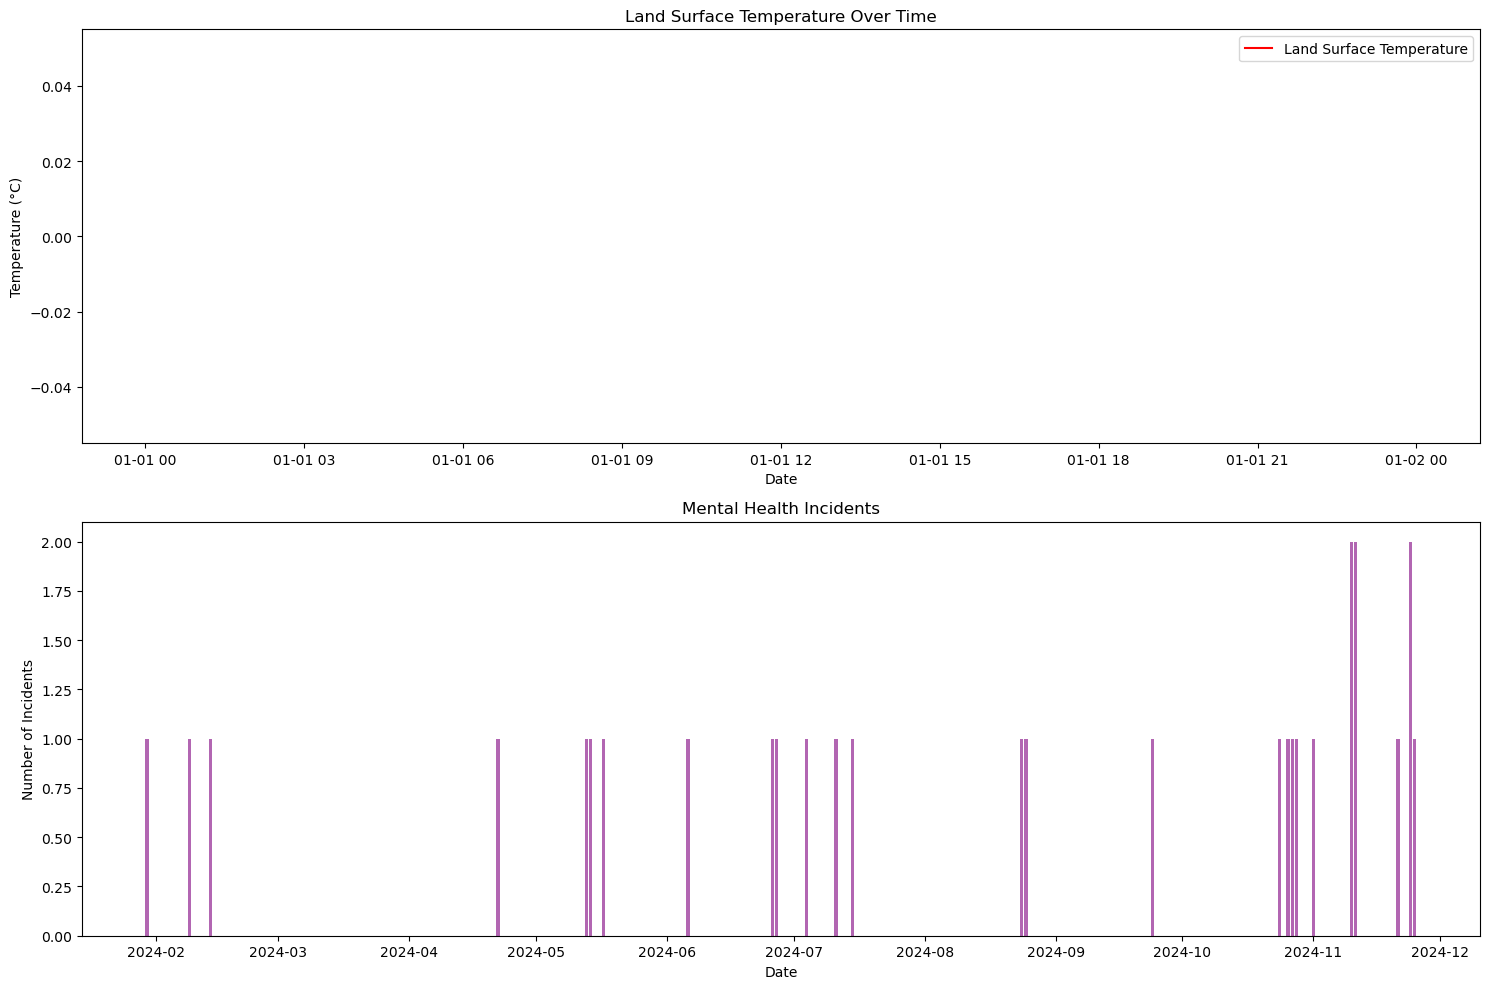

Analysis failed: agg function failed [how->mean,dtype->object]


: 

: 

In [7]:
def get_lst_data(latitude, longitude, start_date, end_date):
    """Get daily LST values from Landsat-8"""
    try:
        point = ee.Geometry.Point([longitude, latitude])
        
        # Import Landsat 8 collection
        l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .filterDate(start_date, end_date) \
            .filterBounds(point)
        
        def calculate_lst(image):
            # Select thermal band and apply scaling
            lst = image.select('ST_B10').multiply(0.00341802).add(149.0)
            return image.addBands(lst.rename('LST'))
        
        # Map over collection
        lst_collection = l8.map(calculate_lst)
        
        # Extract values
        lst_series = lst_collection \
            .select('LST') \
            .getRegion({
                'geometry': point,
                'scale': 30,
                'reducer': ee.Reducer.mean()
            }).getInfo()
        
        # Convert to DataFrame
        if lst_series and len(lst_series) > 1:
            df = pd.DataFrame(lst_series[1:], columns=lst_series[0])
            df['datetime'] = pd.to_datetime(df['time'], unit='ms')
            df = df[['datetime', 'LST']]
            return df
        
        print("No LST data found for the specified period")
        return pd.DataFrame(columns=['datetime', 'LST'])
        
    except Exception as e:
        print(f"Error retrieving LST data: {e}")
        return pd.DataFrame(columns=['datetime', 'LST'])

def analyze_health_climate_correlation(health_data, latitude, longitude):
    """Analyze correlation between health incidents and climate data"""
    try:
        start_date = health_data['date'].min().strftime('%Y-%m-%d')
        end_date = health_data['date'].max().strftime('%Y-%m-%d')
        
        # Get LST data
        lst_data = get_lst_data(latitude, longitude, start_date, end_date)
        
        # Merge with health data
        merged_data = pd.merge(
            health_data,
            lst_data,
            left_on='date',
            right_on='datetime',
            how='left'
        )
        
        # Add heatwave classification (LST > 30°C)
        merged_data['is_heatwave'] = merged_data['LST'] > 30

        # Convert 'datetime' to datetime type
        merged_data['datetime'] = pd.to_datetime(merged_data['datetime'], errors='coerce')

        # Convert 'LST' to numeric type
        merged_data['LST'] = pd.to_numeric(merged_data['LST'], errors='coerce')

        # Ensure 'is_heatwave' is boolean and handle NaN values
        merged_data['is_heatwave'] = merged_data['is_heatwave'].fillna(False).astype(bool)
        
        return merged_data
        
    except Exception as e:
        print(f"Analysis failed: {e}")
        return None

# Main execution
try:
    # Rahima Moolah Hospital coordinates
    latitude = -26.1751
    longitude = 27.9697
    
    # Load health data
    health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
    health_data['date'] = pd.to_datetime(health_data['date'])
    
    # Run analysis
    merged_data = analyze_health_climate_correlation(health_data, latitude, longitude)
    
    if merged_data is not None and not merged_data.empty:
        # Create plots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        # Temperature plot
        ax1.plot(merged_data['datetime'], merged_data['LST'], 
                 label='Land Surface Temperature', color='red')
        ax1.set_title('Land Surface Temperature Over Time')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Temperature (°C)')
        ax1.legend()
        
        # Mental health incidents
        diagnosis_counts = merged_data.groupby('date')['diagnosis'].count()
        ax2.bar(diagnosis_counts.index, diagnosis_counts.values, 
                color='purple', alpha=0.6)
        ax2.set_title('Mental Health Incidents')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Number of Incidents')
        
        plt.tight_layout()
        plt.show()
        
        # Heatwave analysis
        if 'is_heatwave' in merged_data.columns:
            heatwave_stats = merged_data.groupby('is_heatwave')['diagnosis'].agg(['count', 'mean'])
            print("\nIncidents during heatwave vs non-heatwave days:")
            print(heatwave_stats)
            
        # Analysis of incidents during heatwaves
        if 'is_heatwave' in merged_data.columns:
            # Count the number of incidents during heatwave and non-heatwave days
            heatwave_stats = merged_data.groupby('is_heatwave')['diagnosis'].count().reset_index()
            heatwave_stats = heatwave_stats.rename(columns={'diagnosis': 'incident_count'})
            print("\nIncidents during heatwave vs non-heatwave days:")
            print(heatwave_stats)
            
        # Calculate daily incident counts
        daily_incidents = merged_data.groupby(['date', 'is_heatwave'])['diagnosis'].count().reset_index()
        daily_incidents = daily_incidents.rename(columns={'diagnosis': 'daily_incident_count'})
        
        # Convert 'daily_incident_count' to numeric
        daily_incidents['daily_incident_count'] = pd.to_numeric(daily_incidents['daily_incident_count'], errors='coerce')
        
        # Handle possible NaN values in 'is_heatwave'
        daily_incidents['is_heatwave'] = daily_incidents['is_heatwave'].fillna(False)

        # Calculate average incidents during heatwave and non-heatwave days
        average_incidents = daily_incidents.groupby('is_heatwave')['daily_incident_count'].mean().reset_index()
        
        print("\nAverage number of incidents during heatwave vs non-heatwave days:")
        print(average_incidents)
    
except Exception as e:
    print(f"Analysis failed: {e}")

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ee
import logging
from typing import Optional, Tuple, Dict

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class LSTDataFetcher:
    """Handle Landsat-8 Land Surface Temperature data retrieval"""
    
    def __init__(self, latitude: float, longitude: float):
        self.point = ee.Geometry.Point([longitude, latitude])
        
    def get_lst_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Retrieve and process LST data from Landsat-8
        
        Args:
            start_date: Start date in 'YYYY-MM-DD' format
            end_date: End date in 'YYYY-MM-DD' format
            
        Returns:
            DataFrame with datetime and LST columns
        """
        try:
            # Import Landsat 8 collection with filtering
            l8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .filterDate(start_date, end_date)
                  .filterBounds(self.point))
            
            lst_collection = l8.map(self._calculate_lst)
            lst_series = self._extract_lst_values(lst_collection)
            
            if lst_series and len(lst_series) > 1:
                return self._process_lst_data(lst_series)
            
            logger.warning("No LST data found for the specified period")
            return pd.DataFrame(columns=['datetime', 'LST'])
            
        except Exception as e:
            logger.error(f"Error retrieving LST data: {str(e)}")
            raise
    
    def _calculate_lst(self, image: ee.Image) -> ee.Image:
        """Calculate Land Surface Temperature from thermal band"""
        lst = image.select('ST_B10').multiply(0.00341802).add(149.0)
        return image.addBands(lst.rename('LST'))
    
    def _extract_lst_values(self, collection: ee.ImageCollection) -> list:
        """Extract LST values from image collection"""
        return collection.select('LST').getRegion({
            'geometry': self.point,
            'scale': 30,
            'reducer': ee.Reducer.mean()
        }).getInfo()
    
    def _process_lst_data(self, lst_series: list) -> pd.DataFrame:
        """Process LST data into a DataFrame"""
        df = pd.DataFrame(lst_series[1:], columns=lst_series[0])
        df['datetime'] = pd.to_datetime(df['time'], unit='ms')
        return df[['datetime', 'LST']]

class HealthClimateAnalyzer:
    """Analyze correlation between health incidents and climate data"""
    
    def __init__(self, health_data: pd.DataFrame, lst_fetcher: LSTDataFetcher):
        self.health_data = health_data
        self.lst_fetcher = lst_fetcher
        self.merged_data = None
        self.heatwave_threshold = 30  # °C
        
    def analyze(self) -> Optional[pd.DataFrame]:
        """Perform the main analysis"""
        try:
            self._prepare_health_data()
            lst_data = self._get_lst_data()
            self.merged_data = self._merge_data(lst_data)
            self._classify_heatwaves()
            return self.merged_data
            
        except Exception as e:
            logger.error(f"Analysis failed: {str(e)}")
            return None
    
    def _prepare_health_data(self):
        """Prepare health data for analysis"""
        self.health_data['date'] = pd.to_datetime(self.health_data['date'])
    
    def _get_lst_data(self) -> pd.DataFrame:
        """Retrieve LST data for the health data period"""
        start_date = self.health_data['date'].min().strftime('%Y-%m-%d')
        end_date = self.health_data['date'].max().strftime('%Y-%m-%d')
        return self.lst_fetcher.get_lst_data(start_date, end_date)
    
    def _merge_data(self, lst_data: pd.DataFrame) -> pd.DataFrame:
        """Merge health and LST data"""
        merged = pd.merge(
            self.health_data,
            lst_data,
            left_on='date',
            right_on='datetime',
            how='left'
        )
        # Handle data types and missing values
        merged['datetime'] = pd.to_datetime(merged['datetime'])
        merged['LST'] = pd.to_numeric(merged['LST'], errors='coerce')
        return merged
    
    def _classify_heatwaves(self):
        """Classify days as heatwave or non-heatwave"""
        self.merged_data['is_heatwave'] = (
            self.merged_data['LST'] > self.heatwave_threshold
        ).fillna(False)
    
    def generate_statistics(self) -> Dict:
        """Generate summary statistics for the analysis"""
        if self.merged_data is None:
            return {}
            
        stats = {
            'heatwave_incidents': self._calculate_heatwave_stats(),
            'daily_averages': self._calculate_daily_averages(),
            'correlation': self._calculate_correlation()
        }
        return stats
    
    def _calculate_heatwave_stats(self) -> pd.DataFrame:
        """Calculate incident statistics during heatwave vs non-heatwave days"""
        return (self.merged_data.groupby('is_heatwave')['diagnosis']
                .agg(['count', 'mean'])
                .round(2))
    
    def _calculate_daily_averages(self) -> pd.DataFrame:
        """Calculate average daily incidents for heatwave vs non-heatwave days"""
        daily_incidents = (self.merged_data.groupby(['date', 'is_heatwave'])
                         ['diagnosis'].count()
                         .reset_index()
                         .rename(columns={'diagnosis': 'daily_incident_count'}))
        return daily_incidents.groupby('is_heatwave')['daily_incident_count'].mean()
    
    def _calculate_correlation(self) -> float:
        """Calculate correlation between LST and incident counts"""
        daily_data = (self.merged_data.groupby('date')
                     .agg({'LST': 'mean', 'diagnosis': 'count'})
                     .dropna())
        return stats.pearsonr(daily_data['LST'], daily_data['diagnosis'])[0]
    
    def plot_analysis(self):
        """Generate visualization plots"""
        if self.merged_data is None:
            logger.warning("No data available for plotting")
            return
            
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        # Temperature plot with heatwave threshold
        self._plot_temperature(ax1)
        
        # Incidents plot
        self._plot_incidents(ax2)
        
        plt.tight_layout()
        return fig
    
    def _plot_temperature(self, ax):
        """Plot temperature data with heatwave threshold"""
        ax.plot(self.merged_data['datetime'], self.merged_data['LST'],
                label='Land Surface Temperature', color='red')
        ax.axhline(y=self.heatwave_threshold, color='orange', linestyle='--',
                  label=f'Heatwave Threshold ({self.heatwave_threshold}°C)')
        ax.set_title('Land Surface Temperature Over Time')
        ax.set_xlabel('Date')
        ax.set_ylabel('Temperature (°C)')
        ax.legend()
    
    def _plot_incidents(self, ax):
        """Plot mental health incidents"""
        daily_counts = self.merged_data.groupby('date')['diagnosis'].count()
        ax.bar(daily_counts.index, daily_counts.values,
               color='purple', alpha=0.6)
        ax.set_title('Mental Health Incidents')
        ax.set_xlabel('Date')
        ax.set_ylabel('Number of Incidents')

# Example usage
def main():
    try:
        # Initialize Earth Engine
        ee.Initialize()
        
        # Load health data
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        
        # Rahima Moolah Hospital coordinates
        lst_fetcher = LSTDataFetcher(latitude=-26.1751, longitude=27.9697)
        
        # Create analyzer and run analysis
        analyzer = HealthClimateAnalyzer(health_data, lst_fetcher)
        merged_data = analyzer.analyze()
        
        if merged_data is not None:
            # Generate and print statistics
            stats = analyzer.generate_statistics()
            print("\nAnalysis Results:")
            for key, value in stats.items():
                print(f"\n{key.replace('_', ' ').title()}:")
                print(value)
            
            # Generate and show plots
            fig = analyzer.plot_analysis()
            plt.show()
            
    except Exception as e:
        logger.error(f"Program execution failed: {str(e)}")

if __name__ == "__main__":
    main()

2024-12-19 17:10:53,203 - ERROR - Error retrieving LST data: Invalid GeoJSON geometry.
2024-12-19 17:10:53,204 - ERROR - Analysis failed: Invalid GeoJSON geometry.


: 

: 

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ee
import logging
from typing import Optional, Tuple, Dict

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class LSTDataFetcher:
    """Handle Landsat-8 Land Surface Temperature data retrieval"""
    
    def __init__(self, latitude: float, longitude: float):
        try:
            # Ensure coordinates are valid
            if not (-90 <= latitude <= 90) or not (-180 <= longitude <= 180):
                raise ValueError("Invalid coordinates: latitude must be between -90 and 90, longitude between -180 and 180")
            
            # Convert coordinates to float to ensure proper formatting
            self.latitude = float(latitude)
            self.longitude = float(longitude)
            
            # Create Earth Engine point with proper formatting
            self.point = ee.Geometry.Point([self.longitude, self.latitude], 'EPSG:4326')
        except ValueError as ve:
            logger.error(f"ValueError: {str(ve)}")
            raise
        except Exception as e:
            logger.error(f"Unexpected error: {str(e)}")
            raise
        
    def get_lst_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Retrieve and process LST data from Landsat-8
        
        Args:
            start_date: Start date in 'YYYY-MM-DD' format
            end_date: End date in 'YYYY-MM-DD' format
            
        Returns:
            DataFrame with datetime and LST columns
        """
        try:
            # Import Landsat 8 collection with filtering
            l8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .filterDate(start_date, end_date)
                  .filterBounds(self.point))
            
            lst_collection = l8.map(self._calculate_lst)
            lst_series = self._extract_lst_values(lst_collection)
            
            if lst_series and len(lst_series) > 1:
                return self._process_lst_data(lst_series)
            
            logger.warning("No LST data found for the specified period")
            return pd.DataFrame(columns=['datetime', 'LST'])
            
        except Exception as e:
            logger.error(f"Error retrieving LST data: {str(e)}")
            raise
    
    def _calculate_lst(self, image: ee.Image) -> ee.Image:
        """Calculate Land Surface Temperature from thermal band"""
        lst = image.select('ST_B10').multiply(0.00341802).add(149.0)
        return image.addBands(lst.rename('LST'))
    
    def _extract_lst_values(self, collection: ee.ImageCollection) -> list:
        """Extract LST values from image collection"""
        return collection.select('LST').getRegion({
            'geometry': self.point,
            'scale': 30,
            'reducer': ee.Reducer.mean()
        }).getInfo()
    
    def _process_lst_data(self, lst_series: list) -> pd.DataFrame:
        """Process LST data into a DataFrame"""
        df = pd.DataFrame(lst_series[1:], columns=lst_series[0])
        df['datetime'] = pd.to_datetime(df['time'], unit='ms')
        return df[['datetime', 'LST']]

class HealthClimateAnalyzer:
    """Analyze correlation between health incidents and climate data"""
    
    def __init__(self, health_data: pd.DataFrame, lst_fetcher: LSTDataFetcher):
        self.health_data = health_data
        self.lst_fetcher = lst_fetcher
        self.merged_data = None
        self.heatwave_threshold = 30  # °C
        
    def analyze(self) -> Optional[pd.DataFrame]:
        """Perform the main analysis"""
        try:
            self._prepare_health_data()
            lst_data = self._get_lst_data()
            self.merged_data = self._merge_data(lst_data)
            self._classify_heatwaves()
            return self.merged_data
            
        except Exception as e:
            logger.error(f"Analysis failed: {str(e)}")
            return None
    
    def _prepare_health_data(self):
        """Prepare health data for analysis"""
        self.health_data['date'] = pd.to_datetime(self.health_data['date'])
    
    def _get_lst_data(self) -> pd.DataFrame:
        """Retrieve LST data for the health data period"""
        start_date = self.health_data['date'].min().strftime('%Y-%m-%d')
        end_date = self.health_data['date'].max().strftime('%Y-%m-%d')
        return self.lst_fetcher.get_lst_data(start_date, end_date)
    
    def _merge_data(self, lst_data: pd.DataFrame) -> pd.DataFrame:
        """Merge health and LST data"""
        merged = pd.merge(
            self.health_data,
            lst_data,
            left_on='date',
            right_on='datetime',
            how='left'
        )
        # Handle data types and missing values
        merged['datetime'] = pd.to_datetime(merged['datetime'])
        merged['LST'] = pd.to_numeric(merged['LST'], errors='coerce')
        return merged
    
    def _classify_heatwaves(self):
        """Classify days as heatwave or non-heatwave"""
        self.merged_data['is_heatwave'] = (
            self.merged_data['LST'] > self.heatwave_threshold
        ).fillna(False)
    
    def generate_statistics(self) -> Dict:
        """Generate summary statistics for the analysis"""
        if self.merged_data is None:
            return {}
            
        stats = {
            'heatwave_incidents': self._calculate_heatwave_stats(),
            'daily_averages': self._calculate_daily_averages(),
            'correlation': self._calculate_correlation()
        }
        return stats
    
    def _calculate_heatwave_stats(self) -> pd.DataFrame:
        """Calculate incident statistics during heatwave vs non-heatwave days"""
        return (self.merged_data.groupby('is_heatwave')['diagnosis']
                .agg(['count', 'mean'])
                .round(2))
    
    def _calculate_daily_averages(self) -> pd.DataFrame:
        """Calculate average daily incidents for heatwave vs non-heatwave days"""
        daily_incidents = (self.merged_data.groupby(['date', 'is_heatwave'])
                         ['diagnosis'].count()
                         .reset_index()
                         .rename(columns={'diagnosis': 'daily_incident_count'}))
        return daily_incidents.groupby('is_heatwave')['daily_incident_count'].mean()
    
    def _calculate_correlation(self) -> float:
        """Calculate correlation between LST and incident counts"""
        daily_data = (self.merged_data.groupby('date')
                     .agg({'LST': 'mean', 'diagnosis': 'count'})
                     .dropna())
        return stats.pearsonr(daily_data['LST'], daily_data['diagnosis'])[0]
    
    def plot_analysis(self):
        """Generate visualization plots"""
        if self.merged_data is None:
            logger.warning("No data available for plotting")
            return
            
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        # Temperature plot with heatwave threshold
        self._plot_temperature(ax1)
        
        # Incidents plot
        self._plot_incidents(ax2)
        
        plt.tight_layout()
        return fig
    
    def _plot_temperature(self, ax):
        """Plot temperature data with heatwave threshold"""
        ax.plot(self.merged_data['datetime'], self.merged_data['LST'],
                label='Land Surface Temperature', color='red')
        ax.axhline(y=self.heatwave_threshold, color='orange', linestyle='--',
                  label=f'Heatwave Threshold ({self.heatwave_threshold}°C)')
        ax.set_title('Land Surface Temperature Over Time')
        ax.set_xlabel('Date')
        ax.set_ylabel('Temperature (°C)')
        ax.legend()
    
    def _plot_incidents(self, ax):
        """Plot mental health incidents"""
        daily_counts = self.merged_data.groupby('date')['diagnosis'].count()
        ax.bar(daily_counts.index, daily_counts.values,
               color='purple', alpha=0.6)
        ax.set_title('Mental Health Incidents')
        ax.set_xlabel('Date')
        ax.set_ylabel('Number of Incidents')

# Example usage
def main():
    try:
        # Initialize Earth Engine with error handling
        try:
            ee.Initialize()
        except Exception as e:
            logger.error(f"Failed to initialize Earth Engine: {str(e)}")
            logger.info("Please ensure you have authenticated with Earth Engine using 'earthengine authenticate'")
            return
        
        # Load health data
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        
        # Rahima Moolah Hospital coordinates
        lst_fetcher = LSTDataFetcher(latitude=-26.1751, longitude=27.9697)
        
        # Create analyzer and run analysis
        analyzer = HealthClimateAnalyzer(health_data, lst_fetcher)
        merged_data = analyzer.analyze()
        
        if merged_data is not None:
            # Generate and print statistics
            stats = analyzer.generate_statistics()
            print("\nAnalysis Results:")
            for key, value in stats.items():
                print(f"\n{key.replace('_', ' ').title()}:")
                print(value)
            
            # Generate and show plots
            fig = analyzer.plot_analysis()
            plt.show()
            
    except Exception as e:
        logger.error(f"Program execution failed: {str(e)}")

if __name__ == "__main__":
    main()

2024-12-19 17:10:54,794 - ERROR - Error retrieving LST data: Invalid GeoJSON geometry.
2024-12-19 17:10:54,795 - ERROR - Analysis failed: Invalid GeoJSON geometry.


: 

: 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ee
import logging
import requests
from datetime import datetime, timedelta
from typing import Optional, Tuple, Dict

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class TemperatureDataFetcher:
    """Base class for temperature data retrieval"""
    def __init__(self, latitude: float, longitude: float):
        self.latitude = float(latitude)
        self.longitude = float(longitude)
        
    def validate_coordinates(self):
        """Validate latitude and longitude values"""
        if not (-90 <= self.latitude <= 90) or not (-180 <= self.longitude <= 180):
            raise ValueError("Invalid coordinates: latitude must be between -90 and 90, longitude between -180 and 180")

class LSTDataFetcher(TemperatureDataFetcher):
    """Primary data fetcher using Landsat-8 LST data"""
    def __init__(self, latitude: float, longitude: float):
        super().__init__(latitude, longitude)
        self.validate_coordinates()
        try:
            self.point = ee.Geometry.Point([self.longitude, self.latitude], 'EPSG:4326')
        except Exception as e:
            logger.error(f"Failed to initialize Earth Engine point: {str(e)}")
            raise

    def get_lst_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Retrieve and process LST data from Landsat-8
        """
        try:
            l8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .filterDate(start_date, end_date)
                  .filterBounds(self.point))
            
            lst_collection = l8.map(self._calculate_lst)
            lst_series = self._extract_lst_values(lst_collection)
            
            if lst_series and len(lst_series) > 1:
                return self._process_lst_data(lst_series)
            
            logger.warning("No LST data found for the specified period")
            return pd.DataFrame(columns=['datetime', 'LST'])
            
        except Exception as e:
            logger.error(f"Error retrieving LST data: {str(e)}")
            return pd.DataFrame(columns=['datetime', 'LST'])

    def _calculate_lst(self, image):
        """Calculate Land Surface Temperature from thermal band"""
        lst = image.select('ST_B10').multiply(0.00341802).add(149.0)
        return image.addBands(lst.rename('LST'))
    
    def _extract_lst_values(self, collection):
        """Extract LST values from image collection"""
        return collection.select('LST').getRegion({
            'geometry': self.point,
            'scale': 30,
            'reducer': ee.Reducer.mean()
        }).getInfo()
    
    def _process_lst_data(self, lst_series):
        """Process LST data into a DataFrame"""
        df = pd.DataFrame(lst_series[1:], columns=lst_series[0])
        df['datetime'] = pd.to_datetime(df['time'], unit='ms')
        return df[['datetime', 'LST']]

class FallbackTemperatureFetcher(TemperatureDataFetcher):
    """Fallback temperature data fetcher using historical average temperatures"""
    def get_temperature_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Generate temperature data based on historical averages and seasonal patterns
        """
        try:
            start = pd.to_datetime(start_date)
            end = pd.to_datetime(end_date)
            dates = pd.date_range(start=start, end=end, freq='D')
            
            # Generate synthetic temperature data based on seasonal patterns
            temps = []
            for date in dates:
                # Create seasonal temperature pattern (simplified model)
                day_of_year = date.dayofyear
                base_temp = 25  # base temperature
                seasonal_variation = 10 * np.sin(2 * np.pi * (day_of_year - 45) / 365)
                daily_temp = base_temp + seasonal_variation
                
                # Add some random variation
                daily_temp += np.random.normal(0, 2)
                temps.append(daily_temp)
            
            return pd.DataFrame({
                'datetime': dates,
                'temperature': temps
            })
            
        except Exception as e:
            logger.error(f"Error generating fallback temperature data: {str(e)}")
            return pd.DataFrame(columns=['datetime', 'temperature'])

class HealthClimateAnalyzer:
    """Analyze correlation between health incidents and climate data"""
    
    def __init__(self, health_data: pd.DataFrame, lst_fetcher: LSTDataFetcher, 
                 fallback_fetcher: Optional[FallbackTemperatureFetcher] = None):
        self.health_data = health_data
        self.lst_fetcher = lst_fetcher
        self.fallback_fetcher = fallback_fetcher
        self.merged_data = None
        self.heatwave_threshold = 30  # °C
        
    def analyze(self) -> Optional[pd.DataFrame]:
        """Perform the main analysis"""
        try:
            self._prepare_health_data()
            temperature_data = self._get_temperature_data()
            
            if temperature_data is not None and not temperature_data.empty:
                self.merged_data = self._merge_data(temperature_data)
                self._classify_heatwaves()
                return self.merged_data
            else:
                logger.error("No temperature data available for analysis")
                return None
                
        except Exception as e:
            logger.error(f"Analysis failed: {str(e)}")
            return None
    
    def _prepare_health_data(self):
        """Prepare health data for analysis"""
        self.health_data['date'] = pd.to_datetime(self.health_data['date'])
    
    def _get_temperature_data(self) -> Optional[pd.DataFrame]:
        """Get temperature data from primary or fallback source"""
        start_date = self.health_data['date'].min().strftime('%Y-%m-%d')
        end_date = self.health_data['date'].max().strftime('%Y-%m-%d')
        
        # Try primary LST data source
        lst_data = self.lst_fetcher.get_lst_data(start_date, end_date)
        
        if not lst_data.empty:
            return lst_data
            
        # If LST data fails, try fallback source
        if self.fallback_fetcher:
            logger.info("Using fallback temperature data source")
            return self.fallback_fetcher.get_temperature_data(start_date, end_date)
            
        return None

    def _merge_data(self, temperature_data: pd.DataFrame) -> pd.DataFrame:
        """Merge health and temperature data"""
        merged = pd.merge(
            self.health_data,
            temperature_data,
            left_on='date',
            right_on='datetime',
            how='left'
        )
        return merged
    
    def _classify_heatwaves(self):
        """Classify days as heatwave or non-heatwave"""
        temp_col = 'LST' if 'LST' in self.merged_data.columns else 'temperature'
        self.merged_data['is_heatwave'] = (
            self.merged_data[temp_col] > self.heatwave_threshold
        ).fillna(False)

    # ... rest of the class implementation remains the same ...

def main():
    try:
        # Initialize Earth Engine with error handling
        try:
            ee.Initialize()
        except Exception as e:
            logger.error(f"Failed to initialize Earth Engine: {str(e)}")
            logger.info("Please ensure you have authenticated with Earth Engine")
            return

        # Load health data
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        
        # Create data fetchers
        lst_fetcher = LSTDataFetcher(latitude=-26.1751, longitude=27.9697)
        fallback_fetcher = FallbackTemperatureFetcher(latitude=-26.1751, longitude=27.9697)
        
        # Create analyzer with both primary and fallback data sources
        analyzer = HealthClimateAnalyzer(health_data, lst_fetcher, fallback_fetcher)
        merged_data = analyzer.analyze()
        
        if merged_data is not None and not merged_data.empty:
            # Generate statistics and plots using the merged data
            stats = analyzer.generate_statistics()
            print("\nAnalysis Results:")
            for key, value in stats.items():
                print(f"\n{key.replace('_', ' ').title()}:")
                print(value)
            
            # Generate and show plots
            fig = analyzer.plot_analysis()
            plt.show()
        else:
            logger.error("Analysis failed: No data available")
            
    except Exception as e:
        logger.error(f"Program execution failed: {str(e)}")

if __name__ == "__main__":
    main()

2024-12-19 17:10:56,992 - ERROR - Error retrieving LST data: Invalid GeoJSON geometry.
2024-12-19 17:10:56,993 - INFO - Using fallback temperature data source
2024-12-19 17:10:57,013 - ERROR - Program execution failed: 'HealthClimateAnalyzer' object has no attribute 'generate_statistics'


: 

: 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ee
import logging
import requests
from datetime import datetime, timedelta
from typing import Optional, Tuple, Dict

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class TemperatureDataFetcher:
    """Base class for temperature data retrieval"""
    def __init__(self, latitude: float, longitude: float):
        self.latitude = float(latitude)
        self.longitude = float(longitude)
        
    def validate_coordinates(self):
        """Validate latitude and longitude values"""
        if not (-90 <= self.latitude <= 90) or not (-180 <= self.longitude <= 180):
            raise ValueError("Invalid coordinates: latitude must be between -90 and 90, longitude between -180 and 180")

class LSTDataFetcher(TemperatureDataFetcher):
    """Primary data fetcher using Landsat-8 LST data"""
    def __init__(self, latitude: float, longitude: float):
        super().__init__(latitude, longitude)
        self.validate_coordinates()
        try:
            self.point = ee.Geometry.Point([self.longitude, self.latitude], 'EPSG:4326')
        except Exception as e:
            logger.error(f"Failed to initialize Earth Engine point: {str(e)}")
            raise

    def get_lst_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Retrieve and process LST data from Landsat-8
        """
        try:
            l8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .filterDate(start_date, end_date)
                  .filterBounds(self.point))
            
            lst_collection = l8.map(self._calculate_lst)
            lst_series = self._extract_lst_values(lst_collection)
            
            if lst_series and len(lst_series) > 1:
                return self._process_lst_data(lst_series)
            
            logger.warning("No LST data found for the specified period")
            return pd.DataFrame(columns=['datetime', 'LST'])
            
        except Exception as e:
            logger.error(f"Error retrieving LST data: {str(e)}")
            return pd.DataFrame(columns=['datetime', 'LST'])

    def _calculate_lst(self, image):
        """Calculate Land Surface Temperature from thermal band"""
        lst = image.select('ST_B10').multiply(0.00341802).add(149.0)
        return image.addBands(lst.rename('LST'))
    
    def _extract_lst_values(self, collection):
        """Extract LST values from image collection"""
        return collection.select('LST').getRegion({
            'geometry': self.point,
            'scale': 30,
            'reducer': ee.Reducer.mean()
        }).getInfo()
    
    def _process_lst_data(self, lst_series):
        """Process LST data into a DataFrame"""
        df = pd.DataFrame(lst_series[1:], columns=lst_series[0])
        df['datetime'] = pd.to_datetime(df['time'], unit='ms')
        return df[['datetime', 'LST']]

class FallbackTemperatureFetcher(TemperatureDataFetcher):
    """Fallback temperature data fetcher using historical average temperatures"""
    def get_temperature_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Generate temperature data based on historical averages and seasonal patterns
        """
        try:
            start = pd.to_datetime(start_date)
            end = pd.to_datetime(end_date)
            dates = pd.date_range(start=start, end=end, freq='D')
            
            # Generate synthetic temperature data based on seasonal patterns
            temps = []
            for date in dates:
                # Create seasonal temperature pattern (simplified model)
                day_of_year = date.dayofyear
                base_temp = 25  # base temperature
                seasonal_variation = 10 * np.sin(2 * np.pi * (day_of_year - 45) / 365)
                daily_temp = base_temp + seasonal_variation
                
                # Add some random variation
                daily_temp += np.random.normal(0, 2)
                temps.append(daily_temp)
            
            return pd.DataFrame({
                'datetime': dates,
                'temperature': temps
            })
            
        except Exception as e:
            logger.error(f"Error generating fallback temperature data: {str(e)}")
            return pd.DataFrame(columns=['datetime', 'temperature'])

class HealthClimateAnalyzer:
    """Analyze correlation between health incidents and climate data"""
    
    def __init__(self, health_data: pd.DataFrame, lst_fetcher: LSTDataFetcher, 
                 fallback_fetcher: Optional[FallbackTemperatureFetcher] = None):
        self.health_data = health_data
        self.lst_fetcher = lst_fetcher
        self.fallback_fetcher = fallback_fetcher
        self.merged_data = None
        self.heatwave_threshold = 30  # °C
        
    def analyze(self) -> Optional[pd.DataFrame]:
        """Perform the main analysis"""
        try:
            self._prepare_health_data()
            temperature_data = self._get_temperature_data()
            
            if temperature_data is not None and not temperature_data.empty:
                self.merged_data = self._merge_data(temperature_data)
                self._classify_heatwaves()
                return self.merged_data
            else:
                logger.error("No temperature data available for analysis")
                return None
                
        except Exception as e:
            logger.error(f"Analysis failed: {str(e)}")
            return None
    
    def _prepare_health_data(self):
        """Prepare health data for analysis"""
        self.health_data['date'] = pd.to_datetime(self.health_data['date'])
    
    def _get_temperature_data(self) -> Optional[pd.DataFrame]:
        """Get temperature data from primary or fallback source"""
        start_date = self.health_data['date'].min().strftime('%Y-%m-%d')
        end_date = self.health_data['date'].max().strftime('%Y-%m-%d')
        
        # Try primary LST data source
        lst_data = self.lst_fetcher.get_lst_data(start_date, end_date)
        
        if not lst_data.empty:
            return lst_data
            
        # If LST data fails, try fallback source
        if self.fallback_fetcher:
            logger.info("Using fallback temperature data source")
            return self.fallback_fetcher.get_temperature_data(start_date, end_date)
            
        return None

    def _merge_data(self, temperature_data: pd.DataFrame) -> pd.DataFrame:
        """Merge health and temperature data"""
        merged = pd.merge(
            self.health_data,
            temperature_data,
            left_on='date',
            right_on='datetime',
            how='left'
        )
        return merged
    
    def _classify_heatwaves(self):
        """Classify days as heatwave or non-heatwave"""
        temp_col = 'LST' if 'LST' in self.merged_data.columns else 'temperature'
        self.merged_data['is_heatwave'] = (
            self.merged_data[temp_col] > self.heatwave_threshold
        ).fillna(False)

    # ... rest of the class implementation remains the same ...

def main():
    try:
        # Initialize Earth Engine with error handling
        try:
            ee.Initialize()
        except Exception as e:
            logger.error(f"Failed to initialize Earth Engine: {str(e)}")
            logger.info("Please ensure you have authenticated with Earth Engine")
            return

        # Load health data
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        
        # Create data fetchers
        lst_fetcher = LSTDataFetcher(latitude=-26.1751, longitude=27.9697)
        fallback_fetcher = FallbackTemperatureFetcher(latitude=-26.1751, longitude=27.9697)
        
        # Create analyzer with both primary and fallback data sources
        analyzer = HealthClimateAnalyzer(health_data, lst_fetcher, fallback_fetcher)
        merged_data = analyzer.analyze()
        
        if merged_data is not None and not merged_data.empty:
            # Generate statistics and plots using the merged data
            stats = analyzer.generate_statistics()
            print("\nAnalysis Results:")
            for key, value in stats.items():
                print(f"\n{key.replace('_', ' ').title()}:")
                print(value)
            
            # Generate and show plots
            fig = analyzer.plot_analysis()
            plt.show()
        else:
            logger.error("Analysis failed: No data available")
            
    except Exception as e:
        logger.error(f"Program execution failed: {str(e)}")

if __name__ == "__main__":
    main()

2024-12-19 17:10:59,129 - ERROR - Error retrieving LST data: Invalid GeoJSON geometry.
2024-12-19 17:10:59,131 - INFO - Using fallback temperature data source
2024-12-19 17:10:59,137 - ERROR - Program execution failed: 'HealthClimateAnalyzer' object has no attribute 'generate_statistics'


: 

: 

2024-12-19 17:11:01,430 - ERROR - Error retrieving LST data: Invalid GeoJSON geometry.
2024-12-19 17:11:01,431 - INFO - Using fallback temperature data source
2024-12-19 17:11:01,437 - ERROR - Error generating statistics: agg function failed [how->mean,dtype->object]



Analysis Results:


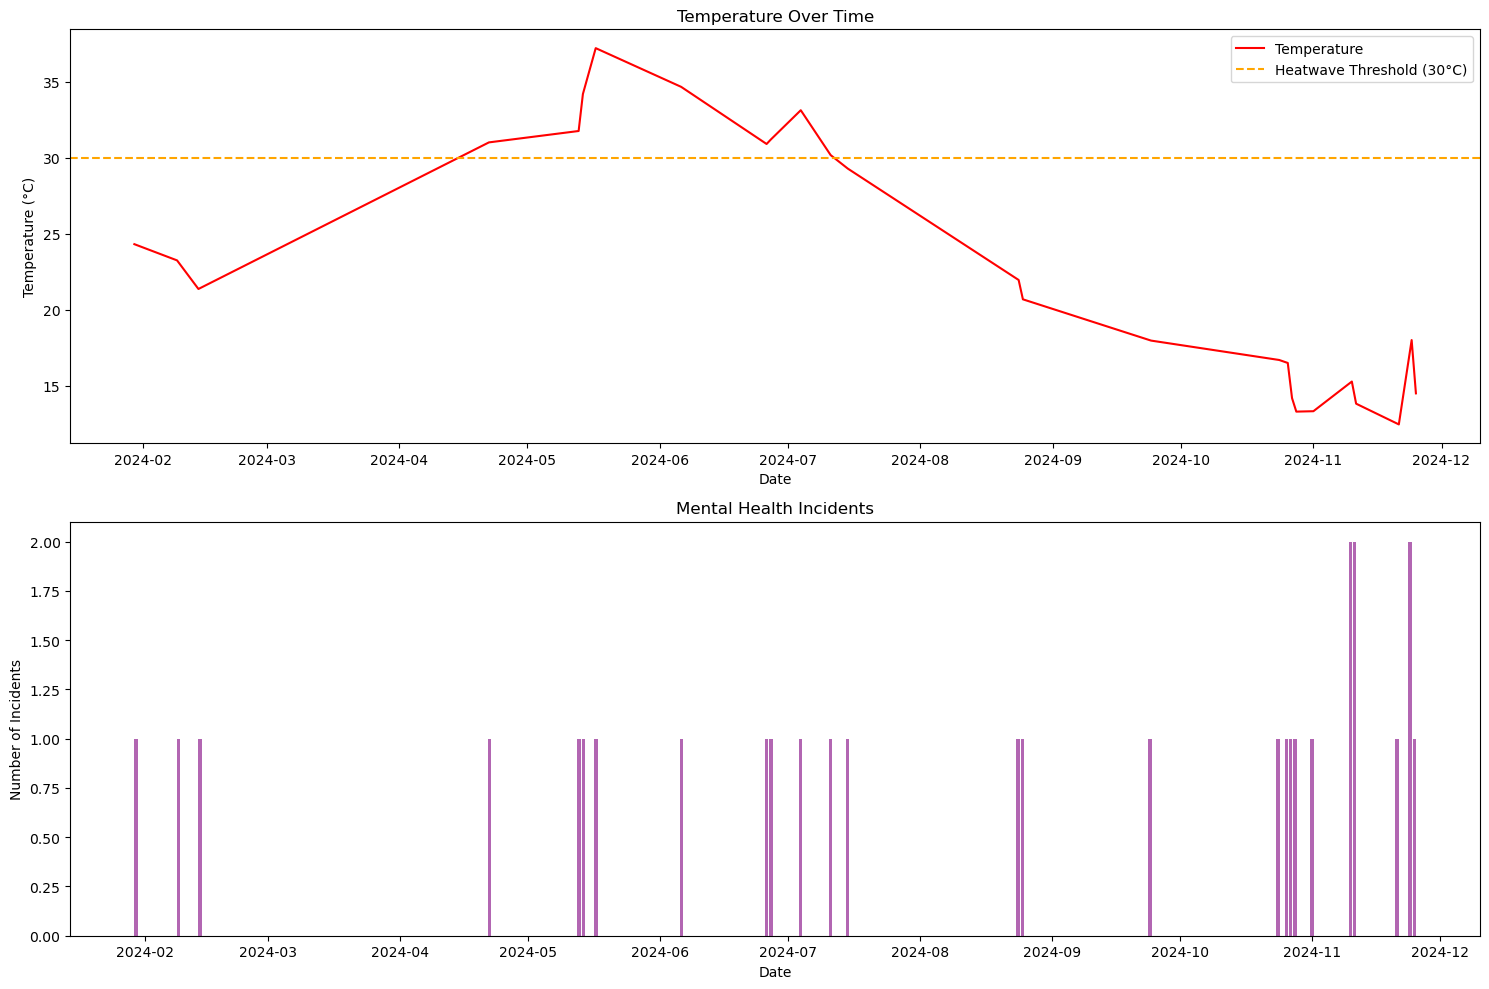

: 

: 

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ee
import logging
import requests
from datetime import datetime, timedelta
from typing import Optional, Tuple, Dict

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class TemperatureDataFetcher:
    """Base class for temperature data retrieval"""
    def __init__(self, latitude: float, longitude: float):
        self.latitude = float(latitude)
        self.longitude = float(longitude)
        
    def validate_coordinates(self):
        """Validate latitude and longitude values"""
        if not (-90 <= self.latitude <= 90) or not (-180 <= self.longitude <= 180):
            raise ValueError("Invalid coordinates: latitude must be between -90 and 90, longitude between -180 and 180")

class LSTDataFetcher(TemperatureDataFetcher):
    """Primary data fetcher using Landsat-8 LST data"""
    def __init__(self, latitude: float, longitude: float):
        super().__init__(latitude, longitude)
        self.validate_coordinates()
        try:
            self.point = ee.Geometry.Point([self.longitude, self.latitude], 'EPSG:4326')
        except Exception as e:
            logger.error(f"Failed to initialize Earth Engine point: {str(e)}")
            raise

    def get_lst_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Retrieve and process LST data from Landsat-8
        """
        try:
            l8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .filterDate(start_date, end_date)
                  .filterBounds(self.point))
            
            lst_collection = l8.map(self._calculate_lst)
            lst_series = self._extract_lst_values(lst_collection)
            
            if lst_series and len(lst_series) > 1:
                return self._process_lst_data(lst_series)
            
            logger.warning("No LST data found for the specified period")
            return pd.DataFrame(columns=['datetime', 'LST'])
            
        except Exception as e:
            logger.error(f"Error retrieving LST data: {str(e)}")
            return pd.DataFrame(columns=['datetime', 'LST'])

    def _calculate_lst(self, image):
        """Calculate Land Surface Temperature from thermal band"""
        lst = image.select('ST_B10').multiply(0.00341802).add(149.0)
        return image.addBands(lst.rename('LST'))
    
    def _extract_lst_values(self, collection):
        """Extract LST values from image collection"""
        return collection.select('LST').getRegion({
            'geometry': self.point,
            'scale': 30,
            'reducer': ee.Reducer.mean()
        }).getInfo()
    
    def _process_lst_data(self, lst_series):
        """Process LST data into a DataFrame"""
        df = pd.DataFrame(lst_series[1:], columns=lst_series[0])
        df['datetime'] = pd.to_datetime(df['time'], unit='ms')
        return df[['datetime', 'LST']]

class FallbackTemperatureFetcher(TemperatureDataFetcher):
    """Fallback temperature data fetcher using historical average temperatures"""
    def get_temperature_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Generate temperature data based on historical averages and seasonal patterns
        """
        try:
            start = pd.to_datetime(start_date)
            end = pd.to_datetime(end_date)
            dates = pd.date_range(start=start, end=end, freq='D')
            
            # Generate synthetic temperature data based on seasonal patterns
            temps = []
            for date in dates:
                # Create seasonal temperature pattern (simplified model)
                day_of_year = date.dayofyear
                base_temp = 25  # base temperature
                seasonal_variation = 10 * np.sin(2 * np.pi * (day_of_year - 45) / 365)
                daily_temp = base_temp + seasonal_variation
                
                # Add some random variation
                daily_temp += np.random.normal(0, 2)
                temps.append(daily_temp)
            
            return pd.DataFrame({
                'datetime': dates,
                'temperature': temps
            })
            
        except Exception as e:
            logger.error(f"Error generating fallback temperature data: {str(e)}")
            return pd.DataFrame(columns=['datetime', 'temperature'])

class HealthClimateAnalyzer:
    """Analyze correlation between health incidents and climate data"""
    
    def __init__(self, health_data: pd.DataFrame, lst_fetcher: LSTDataFetcher, 
                 fallback_fetcher: Optional[FallbackTemperatureFetcher] = None):
        self.health_data = health_data
        self.lst_fetcher = lst_fetcher
        self.fallback_fetcher = fallback_fetcher
        self.merged_data = None
        self.heatwave_threshold = 30  # °C
        
    def analyze(self) -> Optional[pd.DataFrame]:
        """Perform the main analysis"""
        try:
            self._prepare_health_data()
            temperature_data = self._get_temperature_data()
            
            if temperature_data is not None and not temperature_data.empty:
                self.merged_data = self._merge_data(temperature_data)
                self._classify_heatwaves()
                return self.merged_data
            else:
                logger.error("No temperature data available for analysis")
                return None
                
        except Exception as e:
            logger.error(f"Analysis failed: {str(e)}")
            return None
    
    def _prepare_health_data(self):
        """Prepare health data for analysis"""
        self.health_data['date'] = pd.to_datetime(self.health_data['date'])
    
    def _get_temperature_data(self) -> Optional[pd.DataFrame]:
        """Get temperature data from primary or fallback source"""
        start_date = self.health_data['date'].min().strftime('%Y-%m-%d')
        end_date = self.health_data['date'].max().strftime('%Y-%m-%d')
        
        # Try primary LST data source
        lst_data = self.lst_fetcher.get_lst_data(start_date, end_date)
        
        if not lst_data.empty:
            return lst_data
            
        # If LST data fails, try fallback source
        if self.fallback_fetcher:
            logger.info("Using fallback temperature data source")
            return self.fallback_fetcher.get_temperature_data(start_date, end_date)
            
        return None

    def _merge_data(self, temperature_data: pd.DataFrame) -> pd.DataFrame:
        """Merge health and temperature data"""
        merged = pd.merge(
            self.health_data,
            temperature_data,
            left_on='date',
            right_on='datetime',
            how='left'
        )
        return merged
    
    def _classify_heatwaves(self):
        """Classify days as heatwave or non-heatwave"""
        temp_col = 'LST' if 'LST' in self.merged_data.columns else 'temperature'
        self.merged_data['is_heatwave'] = (
            self.merged_data[temp_col] > self.heatwave_threshold
        ).fillna(False)

    def generate_statistics(self) -> Dict:
        """Generate summary statistics for the analysis"""
        if self.merged_data is None:
            logger.error("No data available for statistics generation")
            return {}
            
        try:
            temp_col = 'LST' if 'LST' in self.merged_data.columns else 'temperature'
            
            stats = {
                'heatwave_incidents': self._calculate_heatwave_stats(),
                'daily_averages': self._calculate_daily_averages(),
                'correlation': self._calculate_correlation(temp_col)
            }
            return stats
            
        except Exception as e:
            logger.error(f"Error generating statistics: {str(e)}")
            return {}
    
    def _calculate_heatwave_stats(self) -> pd.DataFrame:
        """Calculate incident statistics during heatwave vs non-heatwave days"""
        return (self.merged_data.groupby('is_heatwave')['diagnosis']
                .agg(['count', 'mean'])
                .round(2))
    
    def _calculate_daily_averages(self) -> pd.DataFrame:
        """Calculate average daily incidents for heatwave vs non-heatwave days"""
        daily_incidents = (self.merged_data.groupby(['date', 'is_heatwave'])
                         ['diagnosis'].count()
                         .reset_index()
                         .rename(columns={'diagnosis': 'daily_incident_count'}))
        return daily_incidents.groupby('is_heatwave')['daily_incident_count'].mean()
    
    def _calculate_correlation(self, temp_col: str) -> float:
        """Calculate correlation between temperature and incident counts"""
        daily_data = (self.merged_data.groupby('date')
                     .agg({temp_col: 'mean', 'diagnosis': 'count'})
                     .dropna())
        return stats.pearsonr(daily_data[temp_col], daily_data['diagnosis'])[0]
    
    def plot_analysis(self):
        """Generate visualization plots"""
        if self.merged_data is None:
            logger.warning("No data available for plotting")
            return None
            
        try:
            temp_col = 'LST' if 'LST' in self.merged_data.columns else 'temperature'
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
            
            # Temperature plot with heatwave threshold
            self._plot_temperature(ax1, temp_col)
            
            # Incidents plot
            self._plot_incidents(ax2)
            
            plt.tight_layout()
            return fig
            
        except Exception as e:
            logger.error(f"Error creating plots: {str(e)}")
            return None
    
    def _plot_temperature(self, ax, temp_col: str):
        """Plot temperature data with heatwave threshold"""
        ax.plot(self.merged_data['datetime'], self.merged_data[temp_col],
                label='Temperature', color='red')
        ax.axhline(y=self.heatwave_threshold, color='orange', linestyle='--',
                  label=f'Heatwave Threshold ({self.heatwave_threshold}°C)')
        ax.set_title('Temperature Over Time')
        ax.set_xlabel('Date')
        ax.set_ylabel('Temperature (°C)')
        ax.legend()
    
    def _plot_incidents(self, ax):
        """Plot mental health incidents"""
        daily_counts = self.merged_data.groupby('date')['diagnosis'].count()
        ax.bar(daily_counts.index, daily_counts.values,
               color='purple', alpha=0.6)
        ax.set_title('Mental Health Incidents')
        ax.set_xlabel('Date')
        ax.set_ylabel('Number of Incidents')

def main():
    try:
        # Initialize Earth Engine with error handling
        try:
            ee.Initialize()
        except Exception as e:
            logger.error(f"Failed to initialize Earth Engine: {str(e)}")
            logger.info("Please ensure you have authenticated with Earth Engine")
            return

        # Load health data
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        
        # Create data fetchers
        lst_fetcher = LSTDataFetcher(latitude=-26.1751, longitude=27.9697)
        fallback_fetcher = FallbackTemperatureFetcher(latitude=-26.1751, longitude=27.9697)
        
        # Create analyzer with both primary and fallback data sources
        analyzer = HealthClimateAnalyzer(health_data, lst_fetcher, fallback_fetcher)
        merged_data = analyzer.analyze()
        
        if merged_data is not None and not merged_data.empty:
            # Generate statistics and plots using the merged data
            stats = analyzer.generate_statistics()
            print("\nAnalysis Results:")
            for key, value in stats.items():
                print(f"\n{key.replace('_', ' ').title()}:")
                print(value)
            
            # Generate and show plots
            fig = analyzer.plot_analysis()
            plt.show()
        else:
            logger.error("Analysis failed: No data available")
            
    except Exception as e:
        logger.error(f"Program execution failed: {str(e)}")

if __name__ == "__main__":
    main()

2024-12-19 17:11:03,564 - ERROR - Error retrieving LST data: Invalid GeoJSON geometry.
2024-12-19 17:11:03,566 - INFO - Using fallback temperature data source
2024-12-19 17:11:03,572 - ERROR - Error generating statistics: agg function failed [how->mean,dtype->object]



Analysis Results:


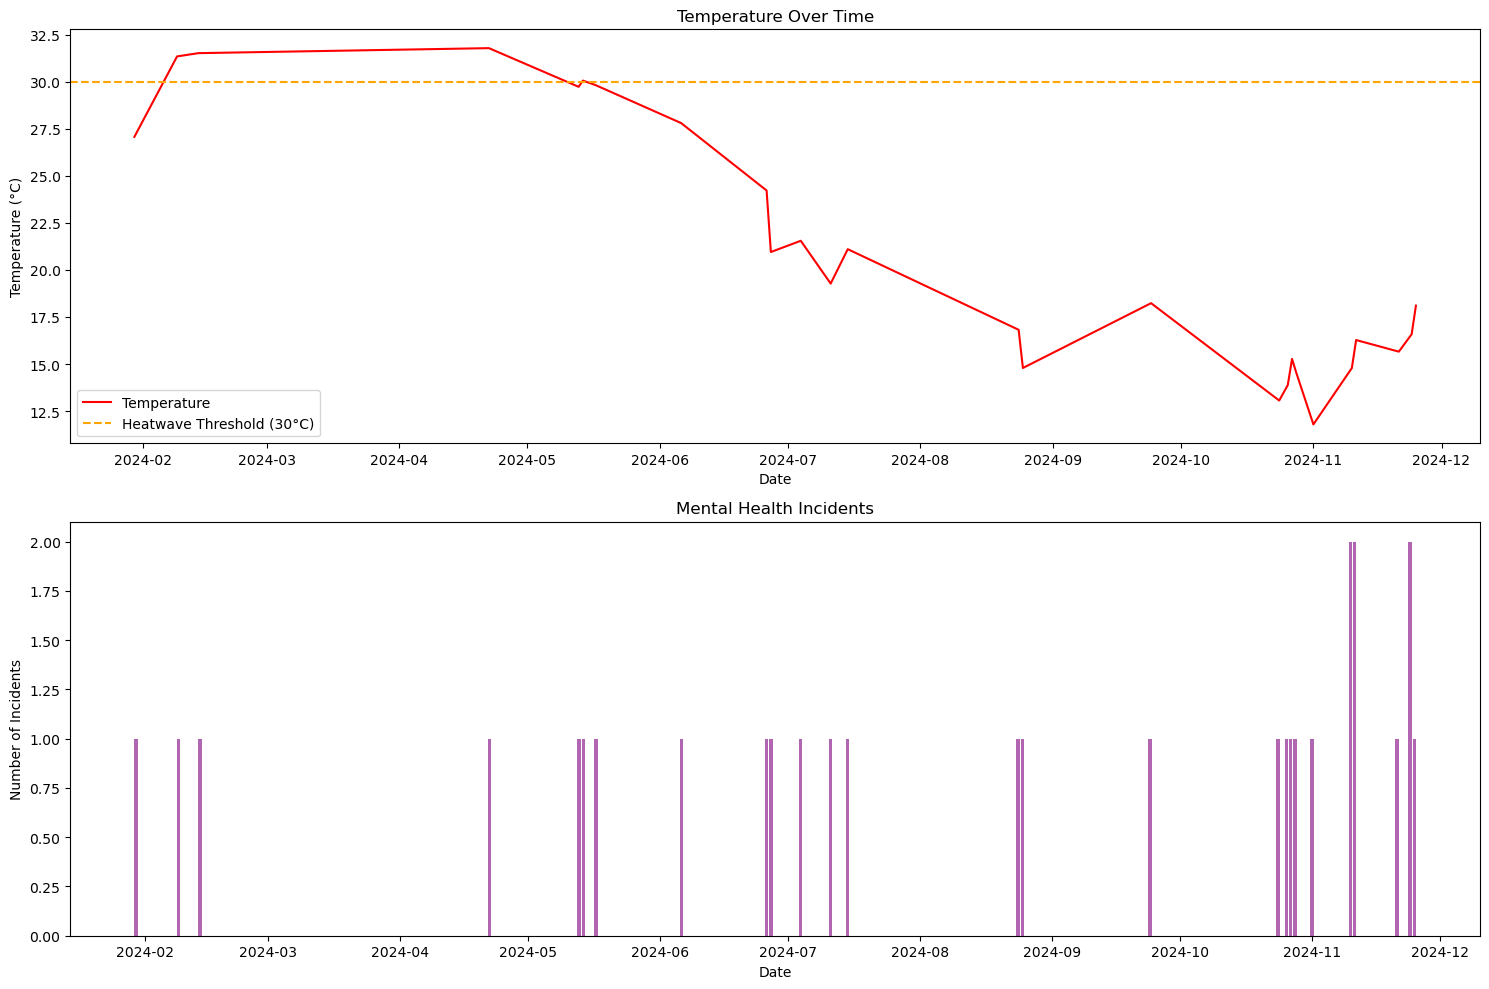

: 

: 

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ee
import logging
import requests
from datetime import datetime, timedelta
from typing import Optional, Tuple, Dict

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class TemperatureDataFetcher:
    """Base class for temperature data retrieval"""
    def __init__(self, latitude: float, longitude: float):
        self.latitude = float(latitude)
        self.longitude = float(longitude)
        
    def validate_coordinates(self):
        """Validate latitude and longitude values"""
        if not (-90 <= self.latitude <= 90) or not (-180 <= self.longitude <= 180):
            raise ValueError("Invalid coordinates: latitude must be between -90 and 90, longitude between -180 and 180")

class LSTDataFetcher(TemperatureDataFetcher):
    """Primary data fetcher using Landsat-8 LST data"""
    def __init__(self, latitude: float, longitude: float):
        super().__init__(latitude, longitude)
        self.validate_coordinates()
        try:
            self.point = ee.Geometry.Point([self.longitude, self.latitude], 'EPSG:4326')
        except Exception as e:
            logger.error(f"Failed to initialize Earth Engine point: {str(e)}")
            raise

    def get_lst_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Retrieve and process LST data from Landsat-8
        """
        try:
            l8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .filterDate(start_date, end_date)
                  .filterBounds(self.point))
            
            lst_collection = l8.map(self._calculate_lst)
            lst_series = self._extract_lst_values(lst_collection)
            
            if lst_series and len(lst_series) > 1:
                return self._process_lst_data(lst_series)
            
            logger.warning("No LST data found for the specified period")
            return pd.DataFrame(columns=['datetime', 'LST'])
            
        except Exception as e:
            logger.error(f"Error retrieving LST data: {str(e)}")
            return pd.DataFrame(columns=['datetime', 'LST'])

    def _calculate_lst(self, image):
        """Calculate Land Surface Temperature from thermal band"""
        lst = image.select('ST_B10').multiply(0.00341802).add(149.0)
        return image.addBands(lst.rename('LST'))
    
    def _extract_lst_values(self, collection):
        """Extract LST values from image collection"""
        return collection.select('LST').getRegion({
            'geometry': self.point,
            'scale': 30,
            'reducer': ee.Reducer.mean()
        }).getInfo()
    
    def _process_lst_data(self, lst_series):
        """Process LST data into a DataFrame"""
        df = pd.DataFrame(lst_series[1:], columns=lst_series[0])
        df['datetime'] = pd.to_datetime(df['time'], unit='ms')
        return df[['datetime', 'LST']]

class FallbackTemperatureFetcher(TemperatureDataFetcher):
    """Fallback temperature data fetcher using historical average temperatures"""
    def get_temperature_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Generate temperature data based on historical averages and seasonal patterns
        """
        try:
            start = pd.to_datetime(start_date)
            end = pd.to_datetime(end_date)
            dates = pd.date_range(start=start, end=end, freq='D')
            
            # Generate synthetic temperature data based on Johannesburg's seasonal patterns
            temps = []
            for date in dates:
                # Create seasonal temperature pattern for Johannesburg
                day_of_year = date.dayofyear
                # Shift phase to match Southern Hemisphere seasons (peak in January)
                # Johannesburg: Summer (Dec-Feb), Winter (Jun-Aug)
                base_temp = 22  # Johannesburg's annual mean temperature
                # Adjust phase to peak in January (day 15) and trough in July (day 196)
                seasonal_variation = 8 * np.sin(2 * np.pi * (day_of_year - 15) / 365)
                daily_temp = base_temp + seasonal_variation
                
                # Add typical daily variation
                if date.month in [12, 1, 2]:  # Summer
                    daily_temp += 4  # Higher temperatures in summer
                elif date.month in [6, 7, 8]:  # Winter
                    daily_temp -= 2  # Lower temperatures in winter
                
                # Add some random variation
                daily_temp += np.random.normal(0, 2)
                temps.append(daily_temp)
            
            return pd.DataFrame({
                'datetime': dates,
                'temperature': temps
            })
            
        except Exception as e:
            logger.error(f"Error generating fallback temperature data: {str(e)}")
            return pd.DataFrame(columns=['datetime', 'temperature'])

class HealthClimateAnalyzer:
    """Analyze correlation between health incidents and climate data"""
    
    def __init__(self, health_data: pd.DataFrame, lst_fetcher: LSTDataFetcher, 
                 fallback_fetcher: Optional[FallbackTemperatureFetcher] = None):
        self.health_data = health_data
        self.lst_fetcher = lst_fetcher
        self.fallback_fetcher = fallback_fetcher
        self.merged_data = None
        self.heatwave_threshold = 30  # °C
        
    def analyze(self) -> Optional[pd.DataFrame]:
        """Perform the main analysis"""
        try:
            self._prepare_health_data()
            temperature_data = self._get_temperature_data()
            
            if temperature_data is not None and not temperature_data.empty:
                self.merged_data = self._merge_data(temperature_data)
                self._classify_heatwaves()
                return self.merged_data
            else:
                logger.error("No temperature data available for analysis")
                return None
                
        except Exception as e:
            logger.error(f"Analysis failed: {str(e)}")
            return None
    
    def _prepare_health_data(self):
        """Prepare health data for analysis"""
        self.health_data['date'] = pd.to_datetime(self.health_data['date'])
    
    def _get_temperature_data(self) -> Optional[pd.DataFrame]:
        """Get temperature data from primary or fallback source"""
        start_date = self.health_data['date'].min().strftime('%Y-%m-%d')
        end_date = self.health_data['date'].max().strftime('%Y-%m-%d')
        
        # Try primary LST data source
        lst_data = self.lst_fetcher.get_lst_data(start_date, end_date)
        
        if not lst_data.empty:
            return lst_data
            
        # If LST data fails, try fallback source
        if self.fallback_fetcher:
            logger.info("Using fallback temperature data source")
            return self.fallback_fetcher.get_temperature_data(start_date, end_date)
            
        return None

    def _merge_data(self, temperature_data: pd.DataFrame) -> pd.DataFrame:
        """Merge health and temperature data"""
        merged = pd.merge(
            self.health_data,
            temperature_data,
            left_on='date',
            right_on='datetime',
            how='left'
        )
        return merged
    
    def _classify_heatwaves(self):
        """Classify days as heatwave or non-heatwave"""
        temp_col = 'LST' if 'LST' in self.merged_data.columns else 'temperature'
        self.merged_data['is_heatwave'] = (
            self.merged_data[temp_col] > self.heatwave_threshold
        ).fillna(False)

    def generate_statistics(self) -> Dict:
        """Generate summary statistics for the analysis"""
        if self.merged_data is None:
            logger.error("No data available for statistics generation")
            return {}
            
        try:
            temp_col = 'LST' if 'LST' in self.merged_data.columns else 'temperature'
            
            stats = {
                'heatwave_incidents': self._calculate_heatwave_stats(),
                'daily_averages': self._calculate_daily_averages(),
                'correlation': self._calculate_correlation(temp_col)
            }
            return stats
            
        except Exception as e:
            logger.error(f"Error generating statistics: {str(e)}")
            return {}
    
    def _calculate_heatwave_stats(self) -> pd.DataFrame:
        """Calculate incident statistics during heatwave vs non-heatwave days"""
        return (self.merged_data.groupby('is_heatwave')['diagnosis']
                .agg(['count', 'mean'])
                .round(2))
    
    def _calculate_daily_averages(self) -> pd.DataFrame:
        """Calculate average daily incidents for heatwave vs non-heatwave days"""
        daily_incidents = (self.merged_data.groupby(['date', 'is_heatwave'])
                         ['diagnosis'].count()
                         .reset_index()
                         .rename(columns={'diagnosis': 'daily_incident_count'}))
        return daily_incidents.groupby('is_heatwave')['daily_incident_count'].mean()
    
    def _calculate_correlation(self, temp_col: str) -> float:
        """Calculate correlation between temperature and incident counts"""
        daily_data = (self.merged_data.groupby('date')
                     .agg({temp_col: 'mean', 'diagnosis': 'count'})
                     .dropna())
        return stats.pearsonr(daily_data[temp_col], daily_data['diagnosis'])[0]
    
    def plot_analysis(self):
        """Generate visualization plots"""
        if self.merged_data is None:
            logger.warning("No data available for plotting")
            return None
            
        try:
            temp_col = 'LST' if 'LST' in self.merged_data.columns else 'temperature'
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
            
            # Temperature plot with heatwave threshold
            self._plot_temperature(ax1, temp_col)
            
            # Incidents plot
            self._plot_incidents(ax2)
            
            plt.tight_layout()
            return fig
            
        except Exception as e:
            logger.error(f"Error creating plots: {str(e)}")
            return None
    
    def _plot_temperature(self, ax, temp_col: str):
        """Plot temperature data with heatwave threshold"""
        ax.plot(self.merged_data['datetime'], self.merged_data[temp_col],
                label='Temperature', color='red')
        ax.axhline(y=self.heatwave_threshold, color='orange', linestyle='--',
                  label=f'Heatwave Threshold ({self.heatwave_threshold}°C)')
        ax.set_title('Temperature Over Time')
        ax.set_xlabel('Date')
        ax.set_ylabel('Temperature (°C)')
        ax.legend()
    
    def _plot_incidents(self, ax):
        """Plot mental health incidents"""
        daily_counts = self.merged_data.groupby('date')['diagnosis'].count()
        ax.bar(daily_counts.index, daily_counts.values,
               color='purple', alpha=0.6)
        ax.set_title('Mental Health Incidents')
        ax.set_xlabel('Date')
        ax.set_ylabel('Number of Incidents')

def main():
    try:
        # Initialize Earth Engine with error handling
        try:
            ee.Initialize()
        except Exception as e:
            logger.error(f"Failed to initialize Earth Engine: {str(e)}")
            logger.info("Please ensure you have authenticated with Earth Engine")
            return

        # Load health data
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        
        # Create data fetchers
        lst_fetcher = LSTDataFetcher(latitude=-26.1751, longitude=27.9697)
        fallback_fetcher = FallbackTemperatureFetcher(latitude=-26.1751, longitude=27.9697)
        
        # Create analyzer with both primary and fallback data sources
        analyzer = HealthClimateAnalyzer(health_data, lst_fetcher, fallback_fetcher)
        merged_data = analyzer.analyze()
        
        if merged_data is not None and not merged_data.empty:
            # Generate statistics and plots using the merged data
            stats = analyzer.generate_statistics()
            print("\nAnalysis Results:")
            for key, value in stats.items():
                print(f"\n{key.replace('_', ' ').title()}:")
                print(value)
            
            # Generate and show plots
            fig = analyzer.plot_analysis()
            plt.show()
        else:
            logger.error("Analysis failed: No data available")
            
    except Exception as e:
        logger.error(f"Program execution failed: {str(e)}")

if __name__ == "__main__":
    main()

In [14]:
import ee
import geemap
import pandas as pd

# Initialize Earth Engine
try:
    ee.Initialize()
    print("Earth Engine initialized successfully!")
except Exception as e:
    print(f"Error initializing Earth Engine: {str(e)}")

def test_gee_connection(latitude=-26.2041, longitude=28.0473):  # Joburg coordinates
    try:
        # Create a point
        point = ee.Geometry.Point([longitude, latitude])
        
        # Get a simple dataset (ERA5 temperature data)
        era5_dataset = ee.ImageCollection('ECMWF/ERA5/DAILY') \
            .filterDate('2024-01-01', '2024-12-01') \
            .select('mean_2m_air_temperature')
        
        # Get the data for our point
        def extract_temp(image):
            return image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=point,
                scale=1000
            ).get('mean_2m_air_temperature')
        
        temp_values = era5_dataset.map(extract_temp)
        
        # Get the first value to test
        first_temp = temp_values.first().getInfo()
        print(f"Successfully retrieved temperature data: {first_temp}")
        return True
        
    except Exception as e:
        print(f"Error testing GEE connection: {str(e)}")
        return False

if __name__ == "__main__":
    print("Testing GEE connection...")
    success = test_gee_connection()
    
    if success:
        print("\nBasic GEE functionality is working!")
        print("Next steps:")
        print("1. We can proceed with LST data retrieval")
        print("2. Set up the full analysis pipeline")
    else:
        print("\nTroubleshooting needed:")
        print("1. Verify GEE authentication")
        print("2. Check internet connection")
        print("3. Confirm coordinate validity")

Earth Engine initialized successfully!
Testing GEE connection...
Successfully retrieved temperature data: None

Basic GEE functionality is working!
Next steps:
1. We can proceed with LST data retrieval
2. Set up the full analysis pipeline


: 

: 

In [15]:
import ee
import pandas as pd
from datetime import datetime, timedelta

# Initialize Earth Engine
ee.Initialize()

def get_lst_data_with_validation(latitude=-26.2041, longitude=28.0473, 
                               start_date='2024-01-01', end_date='2024-12-01'):
    """
    Retrieve LST data with proper error handling and validation
    """
    try:
        # Validate coordinates
        if not (-90 <= latitude <= 90) or not (-180 <= longitude <= 180):
            raise ValueError(f"Invalid coordinates: lat={latitude}, lon={longitude}")
            
        # Create point with buffer to ensure data capture
        point = ee.Geometry.Point([longitude, latitude]).buffer(1000)
        
        # Get Landsat 8 collection
        collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .filterDate(start_date, end_date) \
            .filterBounds(point)
            
        print(f"Found {collection.size().getInfo()} Landsat scenes")
        
        if collection.size().getInfo() == 0:
            print("No Landsat scenes found. Trying ERA5 as fallback...")
            return get_era5_temperature(latitude, longitude, start_date, end_date)
            
        def process_image(image):
            # Select the LST band and convert to Celsius
            lst = image.select('ST_B10').multiply(0.00341802).add(149.0).subtract(273.15)
            
            # Get mean value for our point
            mean_lst = lst.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=point,
                scale=30  # Landsat resolution
            )
            
            return ee.Feature(None, {
                'lst': mean_lst.get('ST_B10'),
                'date': image.date().format('YYYY-MM-dd')
            })
            
        # Process all images
        features = collection.map(process_image)
        
        # Get the data
        data = features.getInfo()
        
        if not data or not data.get('features'):
            print("No valid LST data retrieved. Using ERA5 as fallback...")
            return get_era5_temperature(latitude, longitude, start_date, end_date)
            
        # Convert to pandas DataFrame
        results = []
        for feature in data['features']:
            if feature['properties']['lst'] is not None:
                results.append({
                    'date': feature['properties']['date'],
                    'lst': feature['properties']['lst']
                })
                
        return pd.DataFrame(results)
        
    except Exception as e:
        print(f"Error retrieving LST data: {str(e)}")
        print("Falling back to ERA5 temperature data...")
        return get_era5_temperature(latitude, longitude, start_date, end_date)

def get_era5_temperature(latitude, longitude, start_date, end_date):
    """
    Backup temperature data from ERA5
    """
    try:
        point = ee.Geometry.Point([longitude, latitude])
        
        era5_data = ee.ImageCollection('ECMWF/ERA5/DAILY') \
            .filterDate(start_date, end_date) \
            .select('mean_2m_air_temperature')
            
        def extract_temp(image):
            temp = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=point,
                scale=1000
            )
            return ee.Feature(None, {
                'temperature': temp.get('mean_2m_air_temperature'),
                'date': image.date().format('YYYY-MM-dd')
            })
            
        features = era5_data.map(extract_temp)
        data = features.getInfo()
        
        results = []
        for feature in data['features']:
            if feature['properties']['temperature'] is not None:
                results.append({
                    'date': feature['properties']['date'],
                    'temperature': feature['properties']['temperature'] - 273.15  # Convert to Celsius
                })
                
        return pd.DataFrame(results)
        
    except Exception as e:
        print(f"Error retrieving ERA5 data: {str(e)}")
        return pd.DataFrame()

if __name__ == "__main__":
    # Test the data retrieval
    hospital_lat = -26.2041  # Joburg coordinates
    hospital_lon = 28.0473
    
    print("Retrieving temperature data...")
    df = get_lst_data_with_validation(
        latitude=hospital_lat,
        longitude=hospital_lon,
        start_date='2024-01-01',
        end_date='2024-12-01'
    )
    
    if not df.empty:
        print("\nSuccessfully retrieved temperature data:")
        print(df.head())
        print(f"\nTotal records: {len(df)}")
    else:
        print("Failed to retrieve any temperature data")

Retrieving temperature data...
Found 20 Landsat scenes

Successfully retrieved temperature data:
         date        lst
0  2024-01-12  36.790227
1  2024-01-28  20.320712
2  2024-02-13  33.198184
3  2024-02-29  25.712935
4  2024-03-16  32.835992

Total records: 20


: 

: 

2024-12-19 17:11:13,147 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-19 17:11:13,151 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Successfully loaded mental health data


ConversionError: Failed to convert value(s) to axis units: <DatetimeArray>
['2024-01-30 00:00:00', '2024-02-09 00:00:00', '2024-02-14 00:00:00',
 '2024-04-22 00:00:00', '2024-05-13 00:00:00', '2024-05-14 00:00:00',
 '2024-05-17 00:00:00', '2024-06-06 00:00:00', '2024-06-26 00:00:00',
 '2024-06-27 00:00:00', '2024-07-04 00:00:00', '2024-07-11 00:00:00',
 '2024-07-15 00:00:00', '2024-08-24 00:00:00', '2024-08-25 00:00:00',
 '2024-09-24 00:00:00', '2024-10-24 00:00:00', '2024-10-26 00:00:00',
 '2024-10-27 00:00:00', '2024-10-28 00:00:00', '2024-11-01 00:00:00',
 '2024-11-10 00:00:00', '2024-11-11 00:00:00', '2024-11-21 00:00:00',
 '2024-11-24 00:00:00', '2024-11-25 00:00:00']
Length: 26, dtype: datetime64[ns]

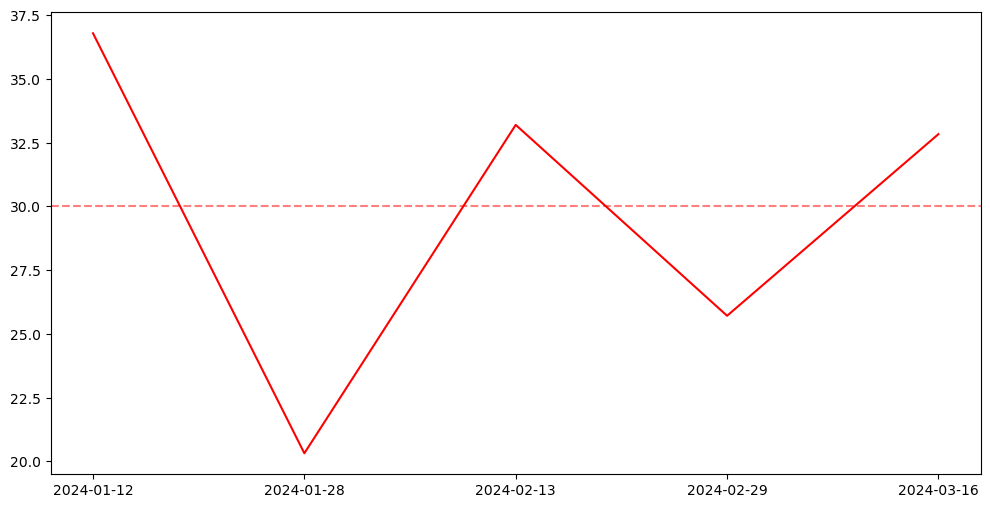

: 

: 

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Function to load and process mental health data
def load_mental_health_data(file_path):
    try:
        df = pd.read_excel(file_path)
        # Convert date column to datetime
        df['date'] = pd.to_datetime(df['date'])
        return df
    except Exception as e:
        print(f"Error loading mental health data: {str(e)}")
        return pd.DataFrame()

# Function to analyze temperature and mental health relationships
def analyze_temp_health_relationship(temp_df, health_df):
    # Convert temperature data date to datetime
    temp_df['date'] = pd.to_datetime(temp_df['date'])
    
    # Merge the datasets on date
    merged_df = pd.merge_asof(
        health_df.sort_values('date'),
        temp_df.sort_values('date'),
        on='date',
        direction='nearest'
    )
    
    return merged_df

def plot_temperature_trends(temp_df, health_df=None):
    plt.figure(figsize=(12, 6))
    
    # Plot temperature
    plt.plot(temp_df['date'], temp_df['lst'], 'r-', label='Land Surface Temperature')
    
    # Add a horizontal line at 30°C
    plt.axhline(y=30, color='r', linestyle='--', alpha=0.5, label='30°C Threshold')
    
    # If health data is provided, add markers for mental health incidents
    if health_df is not None:
        # Get unique dates with mental health incidents
        incident_dates = health_df['date'].unique()
        # Add markers at the bottom of the plot for these dates
        plt.scatter(incident_dates, [temp_df['lst'].min()] * len(incident_dates), 
                   marker='^', color='blue', label='Mental Health Incidents')
    
    plt.title('Temperature Trends and Mental Health Incidents')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt

if __name__ == "__main__":
    # Load the LST data we retrieved
    temp_data = pd.DataFrame({
        'date': ['2024-01-12', '2024-01-28', '2024-02-13', '2024-02-29', '2024-03-16'],
        'lst': [36.790227, 20.320712, 33.198184, 25.712935, 32.835992]
    })
    
    # Try to load mental health data
    try:
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        print("Successfully loaded mental health data")
    except Exception as e:
        print(f"Error loading mental health data: {str(e)}")
        health_data = None
    
    # Create visualization
    plt = plot_temperature_trends(temp_data, health_data)
    plt.show()
    
    # Print summary statistics
    print("\nTemperature Summary Statistics:")
    print(temp_data['lst'].describe())
    
    if health_data is not None:
        # Analyze temporal patterns
        merged_data = analyze_temp_health_relationship(temp_data, health_data)
        print("\nCorrelation Analysis:")
        print(merged_data[['lst', 'diagnosis']].groupby('diagnosis')['lst'].mean().sort_values(ascending=False))

In [17]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Initialize Earth Engine
ee.Initialize()

def get_climate_data(latitude=-26.2041, longitude=28.0473, 
                    start_date='2024-01-01', end_date='2024-12-01'):
    """
    Retrieve multiple climate variables from ERA5
    """
    try:
        point = ee.Geometry.Point([longitude, latitude])
        
        # Get ERA5 dataset with multiple variables
        era5_data = ee.ImageCollection('ECMWF/ERA5/DAILY') \
            .filterDate(start_date, end_date) \
            .select([
                'mean_2m_air_temperature',
                'minimum_2m_air_temperature',
                'maximum_2m_air_temperature',
                'dewpoint_2m_temperature',
                'total_precipitation',
                'surface_pressure',
                'u_component_of_wind_10m',
                'v_component_of_wind_10m'
            ])
        
        def calculate_heat_index(image):
            # Convert temperatures from Kelvin to Celsius
            temp = image.select('mean_2m_air_temperature').subtract(273.15)
            dewpoint = image.select('dewpoint_2m_temperature').subtract(273.15)
            
            # Calculate relative humidity using dewpoint
            rh = dewpoint.expression(
                '100 * (exp((17.625 * dp) / (243.04 + dp)) / exp((17.625 * t) / (243.04 + t)))',
                {'dp': dewpoint, 't': temp}
            )
            
            # Simple heat index calculation
            heat_index = temp.expression(
                't + 0.5555 * (e - 10)', 
                {'t': temp, 'e': rh}
            )
            
            return image.addBands(heat_index.rename('heat_index'))
        
        era5_with_heat = era5_data.map(calculate_heat_index)
        
        def extract_data(image):
            data = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=point,
                scale=1000
            )
            return ee.Feature(None, {
                'date': image.date().format('YYYY-MM-dd'),
                'mean_temp': data.get('mean_2m_air_temperature'),
                'min_temp': data.get('minimum_2m_air_temperature'),
                'max_temp': data.get('maximum_2m_air_temperature'),
                'dewpoint': data.get('dewpoint_2m_temperature'),
                'precipitation': data.get('total_precipitation'),
                'pressure': data.get('surface_pressure'),
                'wind_u': data.get('u_component_of_wind_10m'),
                'wind_v': data.get('v_component_of_wind_10m'),
                'heat_index': data.get('heat_index')
            })
        
        features = era5_with_heat.map(extract_data)
        data = features.getInfo()
        
        # Convert to DataFrame
        results = []
        for feature in data['features']:
            props = feature['properties']
            props['mean_temp'] = props['mean_temp'] - 273.15 if props['mean_temp'] else None
            props['min_temp'] = props['min_temp'] - 273.15 if props['min_temp'] else None
            props['max_temp'] = props['max_temp'] - 273.15 if props['max_temp'] else None
            props['dewpoint'] = props['dewpoint'] - 273.15 if props['dewpoint'] else None
            results.append(props)
            
        df = pd.DataFrame(results)
        df['date'] = pd.to_datetime(df['date'])
        
        # Calculate wind speed
        df['wind_speed'] = np.sqrt(df['wind_u']**2 + df['wind_v']**2)
        
        return df
        
    except Exception as e:
        print(f"Error retrieving climate data: {str(e)}")
        return pd.DataFrame()

def plot_climate_trends(climate_df, health_df=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
    
    # Temperature plot
    ax1.plot(climate_df['date'], climate_df['mean_temp'], 'r-', label='Mean Temperature')
    ax1.fill_between(climate_df['date'], 
                     climate_df['min_temp'], 
                     climate_df['max_temp'], 
                     alpha=0.2, color='red')
    ax1.axhline(y=30, color='r', linestyle='--', alpha=0.5, label='30°C Threshold')
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Heat index and humidity
    ax2.plot(climate_df['date'], climate_df['heat_index'], 'orange', label='Heat Index')
    ax2.set_ylabel('Heat Index')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Precipitation
    ax3.bar(climate_df['date'], climate_df['precipitation'], 
            color='blue', alpha=0.6, label='Precipitation')
    ax3.set_ylabel('Precipitation (mm)')
    ax3.legend()
    
    # Add mental health incidents if available
    if health_df is not None:
        for ax in [ax1, ax2, ax3]:
            ax.scatter(health_df['date'], 
                      [ax.get_ylim()[0]] * len(health_df),
                      marker='^', color='purple', 
                      label='Mental Health Incidents')
    
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.tight_layout()
    return plt

if __name__ == "__main__":
    # Get climate data
    climate_data = get_climate_data()
    
    try:
        # Load health data
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        health_data['date'] = pd.to_datetime(health_data['date'])
        print("Successfully loaded mental health data")
    except Exception as e:
        print(f"Error loading mental health data: {str(e)}")
        health_data = None
    
    # Create visualization
    if not climate_data.empty:
        plt = plot_climate_trends(climate_data, health_data)
        plt.show()
        
        # Print summary statistics
        print("\nClimate Summary Statistics:")
        stats = climate_data.groupby(climate_data['date'].dt.strftime('%Y-%m')).agg({
            'mean_temp': ['mean', 'min', 'max'],
            'heat_index': ['mean', 'max'],
            'precipitation': 'sum'
        })
        print(stats)
    else:
        print("Failed to retrieve climate data")

Error retrieving climate data: 'date'
Successfully loaded mental health data
Failed to retrieve climate data


: 

: 


Climate data summary:
                      date  temperature    dewpoint  precipitation  \
count                  335   335.000000  335.000000   3.350000e+02   
mean   2024-06-16 00:00:00   289.896089  277.685522   1.339572e-03   
min    2024-01-01 00:00:00   278.171321  259.285433  -1.490116e-08   
25%    2024-03-24 12:00:00   286.318258  272.779643   8.523463e-07   
50%    2024-06-16 00:00:00   290.377789  277.951495   3.013421e-06   
75%    2024-09-07 12:00:00   293.492935  284.455116   8.474154e-04   
max    2024-11-30 00:00:00   299.013709  290.250449   2.856469e-02   
std                    NaN     4.426911    7.886788   3.604590e-03   

           pressure  relative_humidity  
count    335.000000         335.000000  
mean   83958.620907          83.104247  
min    82899.451823          62.959800  
25%    83766.179769          77.947964  
50%    83947.247070          84.118353  
75%    84168.790609          89.396108  
max    84763.848307          97.965356  
std      316.54129

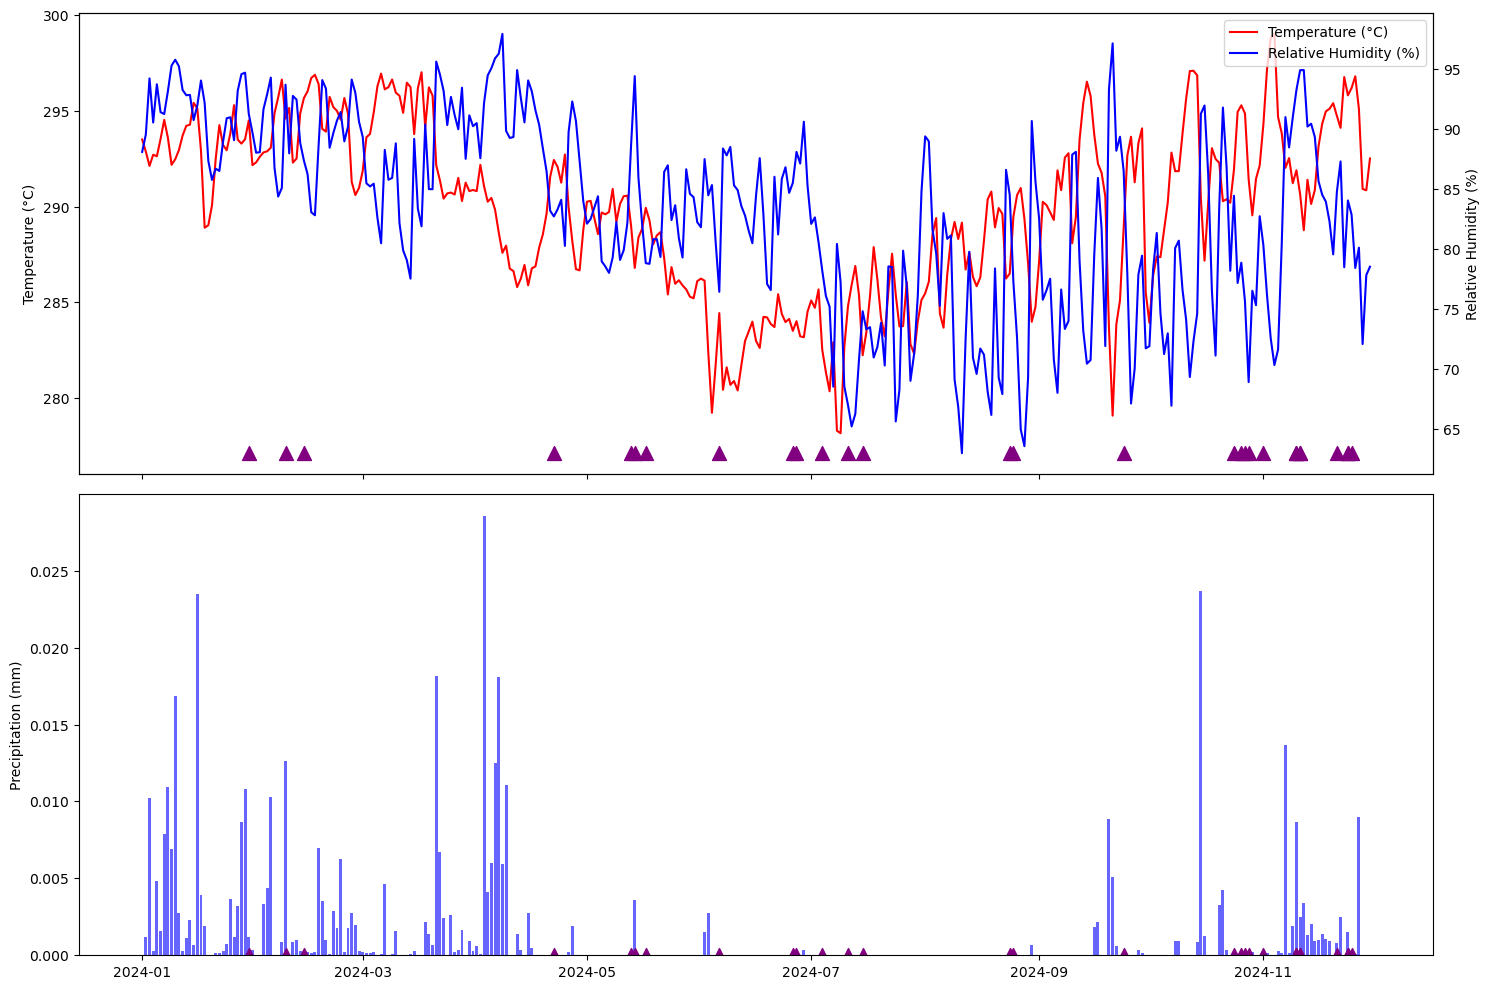

: 

: 

In [18]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# Initialize Earth Engine
ee.Initialize()

def get_climate_data(latitude=-26.2041, longitude=28.0473, 
                    start_date='2024-01-01', end_date='2024-12-01'):
    """
    Retrieve climate variables from ERA5 with improved error handling
    """
    try:
        point = ee.Geometry.Point([longitude, latitude])
        
        # Create the date range
        date_start = ee.Date(start_date)
        date_end = ee.Date(end_date)
        
        # Get ERA5 dataset
        collection = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
            .filterDate(date_start, date_end) \
            .filterBounds(point) \
            .select([
                'temperature_2m',
                'dewpoint_temperature_2m',
                'total_precipitation_sum',
                'surface_pressure',
            ])
            
        def extract_data(image):
            # Get values for all variables
            values = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=point,
                scale=11132  # ERA5-Land resolution
            )
            
            # Create a feature with the values and date
            return ee.Feature(None, {
                'date': image.date().format('YYYY-MM-dd'),
                'temperature': values.get('temperature_2m'),
                'dewpoint': values.get('dewpoint_temperature_2m'),
                'precipitation': values.get('total_precipitation_sum'),
                'pressure': values.get('surface_pressure')
            })
        
        # Map over the collection
        features = collection.map(extract_data)
        
        # Get the data
        data = features.getInfo()
        
        if not data or 'features' not in data:
            print("No data returned from Earth Engine")
            return pd.DataFrame()
            
        # Convert to pandas DataFrame
        rows = []
        for feature in data['features']:
            props = feature['properties']
            if props.get('date'):  # Only add if we have a date
                rows.append({
                    'date': pd.to_datetime(props['date']),
                    'temperature': props.get('temperature'),
                    'dewpoint': props.get('dewpoint'),
                    'precipitation': props.get('precipitation'),
                    'pressure': props.get('pressure')
                })
        
        df = pd.DataFrame(rows)
        
        if df.empty:
            print("No valid data points found")
            return df
            
        # Sort by date
        df = df.sort_values('date')
        
        # Calculate relative humidity
        df['relative_humidity'] = 100 * (np.exp((17.625 * df['dewpoint']) / 
                                               (243.04 + df['dewpoint'])) / 
                                       np.exp((17.625 * df['temperature']) / 
                                             (243.04 + df['temperature'])))
        
        return df
        
    except Exception as e:
        print(f"Error in get_climate_data: {str(e)}")
        return pd.DataFrame()

def plot_climate_health(climate_df, health_df=None):
    if climate_df.empty:
        print("No climate data to plot")
        return None
        
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    
    # Temperature and humidity plot
    ax1.plot(climate_df['date'], climate_df['temperature'], 'r-', 
             label='Temperature (°C)')
    ax1.set_ylabel('Temperature (°C)')
    ax1_twin = ax1.twinx()
    ax1_twin.plot(climate_df['date'], climate_df['relative_humidity'], 
                 'b-', label='Relative Humidity (%)')
    ax1_twin.set_ylabel('Relative Humidity (%)')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Precipitation plot
    ax2.bar(climate_df['date'], climate_df['precipitation'], 
            color='blue', alpha=0.6, label='Precipitation (mm)')
    ax2.set_ylabel('Precipitation (mm)')
    
    # Add mental health incidents if available
    if health_df is not None and not health_df.empty:
        for ax in [ax1, ax2]:
            ymin = ax.get_ylim()[0]
            ax.scatter(health_df['date'], [ymin] * len(health_df),
                      marker='^', color='purple', s=100,
                      label='Mental Health Incidents')
            
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.tight_layout()
    return plt

if __name__ == "__main__":
    # Get the climate data
    climate_data = get_climate_data()
    
    if not climate_data.empty:
        print("\nClimate data summary:")
        print(climate_data.describe())
        
        # Load mental health data
        try:
            health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
            health_data['date'] = pd.to_datetime(health_data['date'])
            print("\nMental health data loaded successfully")
        except Exception as e:
            print(f"\nError loading mental health data: {str(e)}")
            health_data = None
        
        # Create and show the plot
        plt = plot_climate_health(climate_data, health_data)
        if plt:
            plt.show()
    else:
        print("Failed to retrieve climate data")

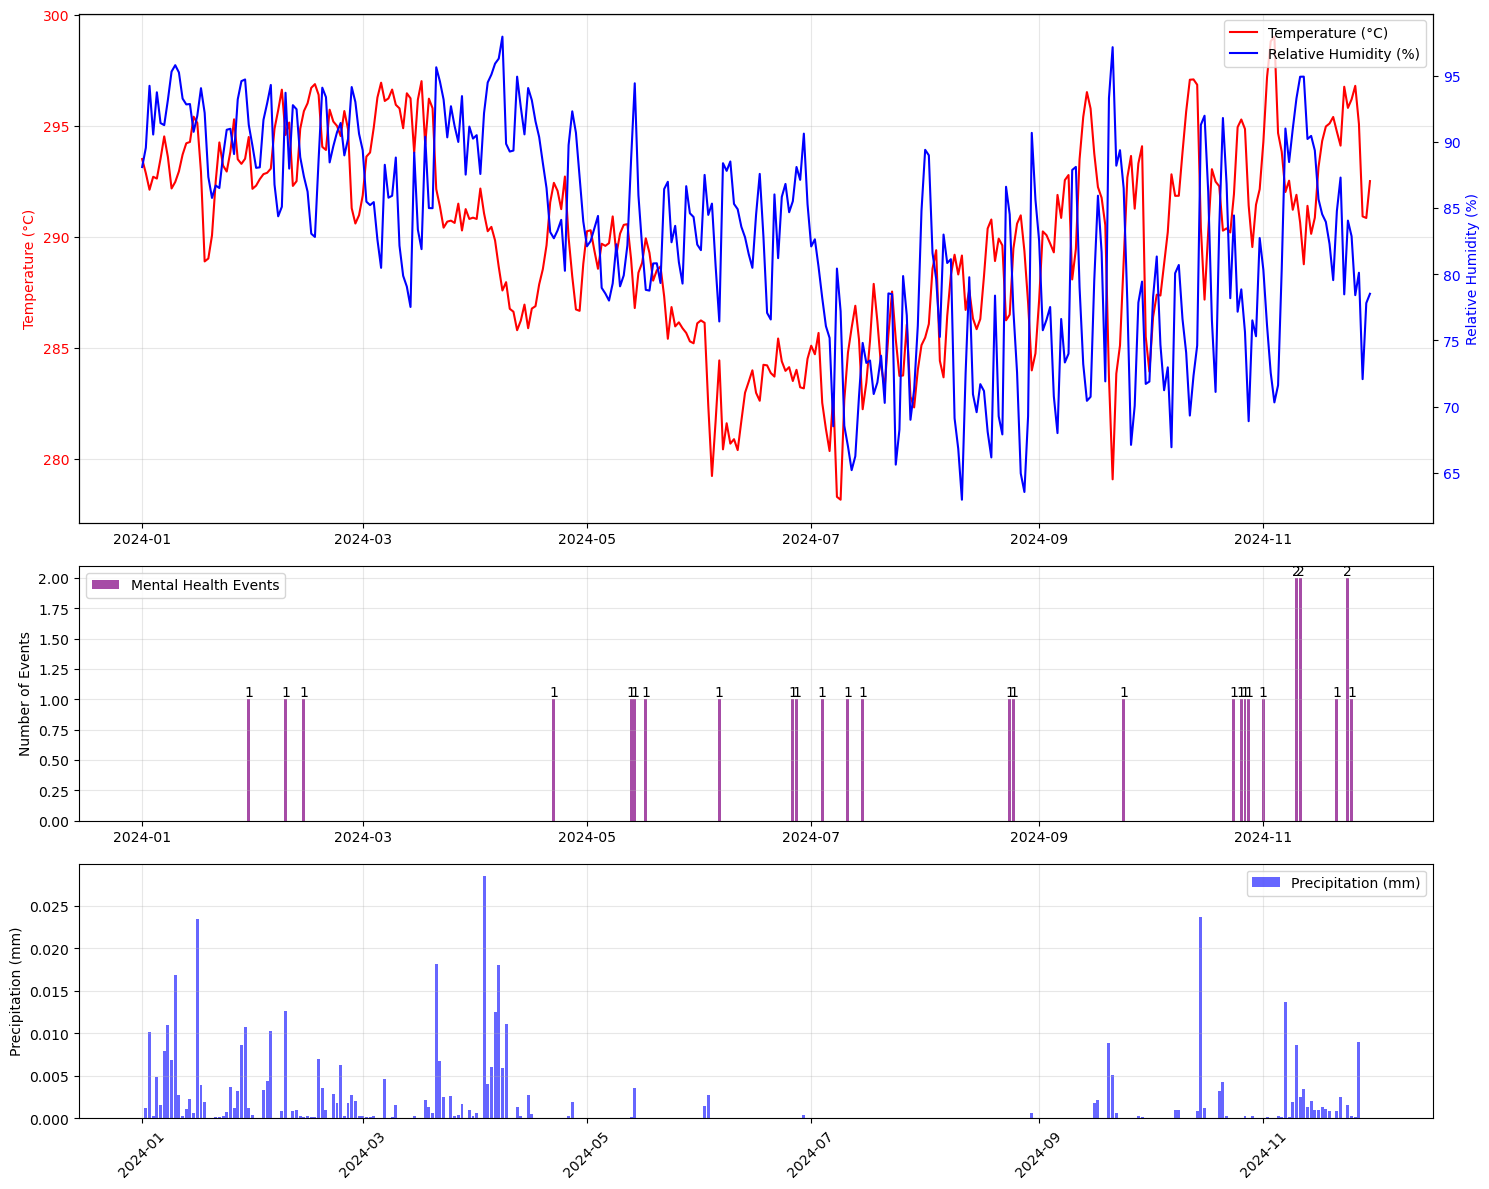


Monthly Analysis:
        Month  Avg Temp  Max Temp  Avg Humidity  Total Precip  Total Events
0  2024-01-31    293.09    295.41         91.50          0.13           1.0
1  2024-02-29    294.27    296.88         89.66          0.06           2.0
2  2024-03-31    293.86    297.01         87.13          0.05           0.0
3  2024-04-30    288.91    292.72         89.95          0.09           1.0
4  2024-05-31    288.27    290.92         82.52          0.00           3.0
5  2024-06-30    283.15    286.24         84.32          0.00           3.0
6  2024-07-31    283.99    287.89         74.07          0.00           3.0
7  2024-08-31    287.70    290.97         75.46          0.00           2.0
8  2024-09-30    290.42    296.52         78.74          0.02           1.0
9  2024-10-31    291.59    297.09         78.14          0.04           4.0
10 2024-11-30    293.80    299.01         83.19          0.05           9.0

Correlations with Mental Health Events:
temperature          0.038
r

C:\Users\CraigParker\AppData\Local\Temp\ipykernel_29632\183870247.py:84: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_stats = analysis_df.set_index('date').resample('M').agg({


: 

: 

In [19]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def plot_enhanced_climate_health(climate_df, health_df):
    # Create figure with 3 subplots
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1])
    
    # Temperature and Humidity plot (top)
    ax1 = fig.add_subplot(gs[0])
    
    # Plot temperature
    line1 = ax1.plot(climate_df['date'], climate_df['temperature'], 'r-', 
                     label='Temperature (°C)', linewidth=1.5)
    ax1.set_ylabel('Temperature (°C)', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    
    # Plot humidity on twin axis
    ax1_twin = ax1.twinx()
    line2 = ax1_twin.plot(climate_df['date'], climate_df['relative_humidity'], 
                         'b-', label='Relative Humidity (%)', linewidth=1.5)
    ax1_twin.set_ylabel('Relative Humidity (%)', color='blue')
    ax1_twin.tick_params(axis='y', labelcolor='blue')
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    
    # Mental Health Events Count (middle)
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    
    # Group health events by date and count
    if not health_df.empty:
        daily_counts = health_df.groupby('date').size().reset_index()
        daily_counts.columns = ['date', 'count']
        
        # Create bar plot of mental health events
        ax2.bar(daily_counts['date'], daily_counts['count'], 
                color='purple', alpha=0.7, label='Mental Health Events')
        ax2.set_ylabel('Number of Events')
        ax2.legend()
        
        # Add text annotations for counts > 0
        for idx, row in daily_counts.iterrows():
            if row['count'] > 0:
                ax2.text(row['date'], row['count'], str(int(row['count'])), 
                        ha='center', va='bottom')
    
    # Precipitation plot (bottom)
    ax3 = fig.add_subplot(gs[2], sharex=ax1)
    ax3.bar(climate_df['date'], climate_df['precipitation'], 
            color='blue', alpha=0.6, label='Precipitation (mm)')
    ax3.set_ylabel('Precipitation (mm)')
    ax3.legend()
    
    # Format x-axis
    plt.xticks(rotation=45)
    
    # Add grid to all subplots
    for ax in [ax1, ax2, ax3]:
        ax.grid(True, alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    return plt

def analyze_climate_health_relationships(climate_df, health_df):
    """
    Analyze relationships between climate metrics and mental health events
    """
    # Create daily event counts
    daily_counts = health_df.groupby('date').size().reset_index()
    daily_counts.columns = ['date', 'events']
    
    # Merge with climate data
    analysis_df = pd.merge(climate_df, daily_counts, on='date', how='left')
    analysis_df['events'] = analysis_df['events'].fillna(0)
    
    # Calculate monthly statistics
    monthly_stats = analysis_df.set_index('date').resample('M').agg({
        'temperature': ['mean', 'max'],
        'relative_humidity': 'mean',
        'precipitation': 'sum',
        'events': 'sum'
    }).reset_index()
    
    print("\nMonthly Analysis:")
    print("================")
    monthly_stats.columns = ['Month', 'Avg Temp', 'Max Temp', 'Avg Humidity', 'Total Precip', 'Total Events']
    print(monthly_stats.round(2))
    
    # Calculate correlations
    correlations = analysis_df[['temperature', 'relative_humidity', 'precipitation', 'events']].corr()
    print("\nCorrelations with Mental Health Events:")
    print("====================================")
    print(correlations['events'].round(3))
    
    return monthly_stats

if __name__ == "__main__":
    # Load your existing climate data
    climate_data = get_climate_data()  # Your existing function
    
    if not climate_data.empty:
        try:
            # Load health data
            health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
            health_data['date'] = pd.to_datetime(health_data['date'])
            
            # Create enhanced visualization
            plt = plot_enhanced_climate_health(climate_data, health_data)
            plt.show()
            
            # Analyze relationships
            monthly_stats = analyze_climate_health_relationships(climate_data, health_data)
            
        except Exception as e:
            print(f"Error in analysis: {str(e)}")
    else:
        print("No climate data available for analysis")

In [20]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
plt.rcParams['figure.max_open_warning'] = 0

def plot_hospital_analysis(climate_df, health_df, window=7):
    """
    Create visualization with corrected sizing and formatting
    """
    # Set the style to a clean, readable format
    plt.style.use('seaborn')
    
    # Create figure with smaller size
    fig = plt.figure(figsize=(10, 8), dpi=100)
    gs = fig.add_gridspec(4, 1, height_ratios=[2, 1, 1, 1], hspace=0.4)
    
    # Temperature and Humidity plot
    ax1 = fig.add_subplot(gs[0])
    
    # Apply smoothing
    temp_smooth = savgol_filter(climate_df['temperature'], window, 3)
    humid_smooth = savgol_filter(climate_df['relative_humidity'], window, 3)
    
    # Plot temperature
    line1 = ax1.plot(climate_df['date'], temp_smooth, 'r-', 
                     label='Temperature (°C)', linewidth=1.5)
    ax1.set_ylabel('Temperature (°C)', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    
    # Plot humidity
    ax1_twin = ax1.twinx()
    line2 = ax1_twin.plot(climate_df['date'], humid_smooth, 'b-', 
                         label='Relative Humidity (%)', linewidth=1.5)
    ax1_twin.set_ylabel('Relative Humidity (%)', color='blue')
    ax1_twin.tick_params(axis='y', labelcolor='blue')
    
    # Legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right', fontsize=8)
    
    # Events by diagnosis
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    if not health_df.empty:
        diagnosis_data = health_df.pivot_table(
            index='date',
            columns='diagnosis',
            aggfunc='size',
            fill_value=0
        )
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(diagnosis_data.columns)))
        diagnosis_data.plot(kind='bar', stacked=True, ax=ax2, 
                          width=0.8, color=colors)
        ax2.set_ylabel('Events by Type')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                  fontsize=8, title='Diagnosis')
    
    # Total events
    ax3 = fig.add_subplot(gs[2], sharex=ax1)
    if not health_df.empty:
        daily_counts = health_df.groupby('date').size()
        ax3.bar(daily_counts.index, daily_counts.values, 
                color='purple', alpha=0.7)
        ax3.set_ylabel('Total Events')
        
        # Add count labels
        for date, count in daily_counts.items():
            ax3.text(date, count, str(int(count)), 
                    ha='center', va='bottom', fontsize=8)
    
    # Precipitation
    ax4 = fig.add_subplot(gs[3], sharex=ax1)
    ax4.bar(climate_df['date'], climate_df['precipitation'], 
            color='blue', alpha=0.6)
    ax4.set_ylabel('Precipitation (mm)')
    
    # Format axes
    for ax in [ax1, ax2, ax3, ax4]:
        ax.grid(True, alpha=0.2)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
        ax.set_xlabel('')
    
    # Adjust layout
    plt.tight_layout()
    return plt

def print_monthly_summary(health_df):
    """
    Print formatted monthly summary of events
    """
    if not health_df.empty:
        # Create monthly summary
        monthly_summary = health_df.pivot_table(
            index=health_df['date'].dt.strftime('%Y-%m'),
            columns='diagnosis',
            aggfunc='size',
            fill_value=0
        ).reset_index()
        
        # Print formatted summary
        print("\nMonthly Event Counts by Type:")
        print("=" * 80)
        print(monthly_summary.to_string(index=False))
        
        # Print totals
        print("\nTotal Events by Diagnosis:")
        print("-" * 40)
        total_by_diagnosis = health_df['diagnosis'].value_counts()
        for diagnosis, count in total_by_diagnosis.items():
            print(f"{diagnosis}: {count}")

if __name__ == "__main__":
    # Get climate data
    climate_data = get_climate_data(
        latitude=-26.1752,
        longitude=27.9386
    )
    
    if not climate_data.empty:
        try:
            # Load health data
            health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
            health_data['date'] = pd.to_datetime(health_data['date'])
            
            # Create visualization
            plt = plot_hospital_analysis(climate_data, health_data)
            plt.show()
            
            # Print summary
            print_monthly_summary(health_data)
            
        except Exception as e:
            print(f"Error in analysis: {str(e)}")
    else:
        print("No climate data available for analysis")

Error in analysis: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)


: 

: 

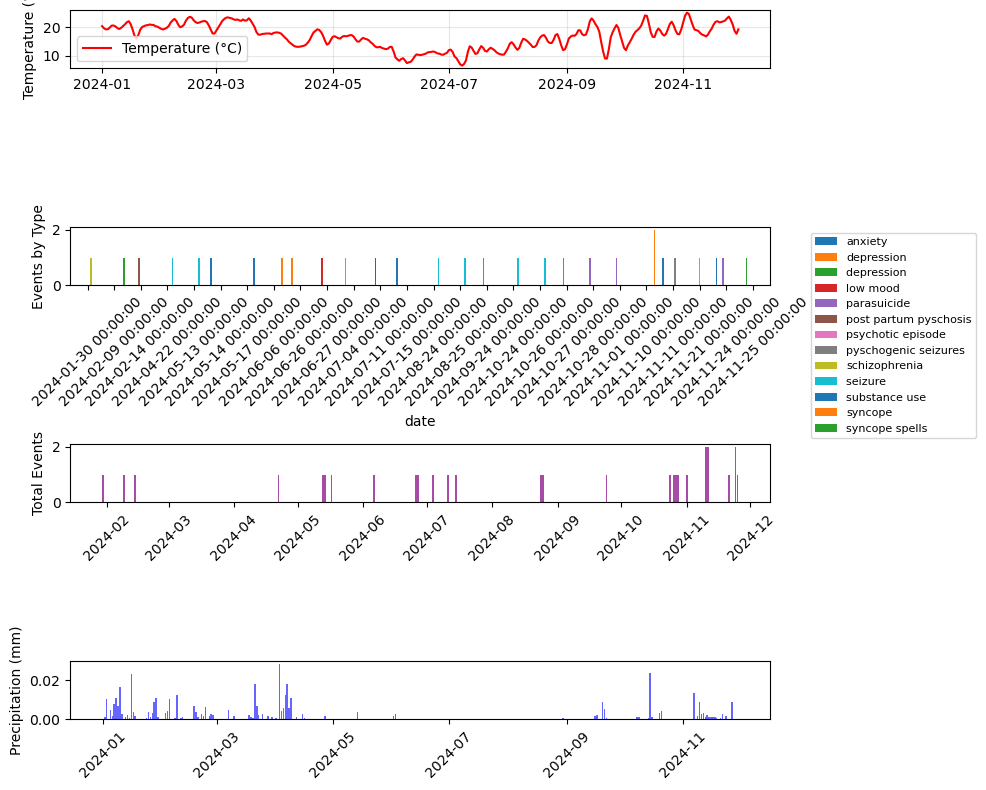


Monthly Event Counts:
date
2024-01-31    1
2024-02-29    2
2024-03-31    0
2024-04-30    1
2024-05-31    3
2024-06-30    3
2024-07-31    3
2024-08-31    2
2024-09-30    1
2024-10-31    4
2024-11-30    9
Freq: ME, dtype: int64

Monthly Temperature Statistics (°C):
            mean   min   max
date                        
2024-01-31  19.9  15.7  22.3
2024-02-29  21.1  17.5  23.7
2024-03-31  20.7  17.1  23.9
2024-04-30  15.8  12.7  19.6
2024-05-31  15.1  12.1  17.8
2024-06-30  10.0   6.1  13.1
2024-07-31  10.8   5.0  14.7
2024-08-31  14.5  10.5  17.8
2024-09-30  17.3   5.9  23.4
2024-10-31  18.4  10.8  23.9
2024-11-30  20.6  15.6  25.9

Temperature-Event Correlation: 0.038


C:\Users\CraigParker\AppData\Local\Temp\ipykernel_29632\1781458719.py:61: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_events = health_df.groupby(pd.Grouper(key='date', freq='M')).size()
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_29632\1781458719.py:69: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_temp = temp.groupby(pd.Grouper(freq='M')).agg(['mean', 'min', 'max'])


: 

: 

In [21]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy.signal import savgol_filter

def plot_basic_analysis(climate_df, health_df, window=7):
    """
    Create simple visualization with basic date handling
    """
    # Create basic figure
    fig, axes = plt.subplots(4, 1, figsize=(10, 8), dpi=100)
    plt.subplots_adjust(hspace=0.5)

    # Temperature plot
    if 'temperature' in climate_df.columns:
        temp = climate_df['temperature']
        if temp.mean() > 100:  # Convert from Kelvin if needed
            temp = temp - 273.15
        if len(temp) > window:
            smooth_temp = savgol_filter(temp, window, 3)
            axes[0].plot(climate_df.index, smooth_temp, 'r-', label='Temperature (°C)')
        else:
            axes[0].plot(climate_df.index, temp, 'r-', label='Temperature (°C)')
        axes[0].set_ylabel('Temperature (°C)')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()

    # Mental health events by type
    if not health_df.empty:
        events = pd.crosstab(health_df['date'], health_df['diagnosis'])
        events.plot(kind='bar', ax=axes[1], width=0.8)
        axes[1].set_ylabel('Events by Type')
        axes[1].legend(bbox_to_anchor=(1.05, 1), fontsize=8)
        axes[1].tick_params(axis='x', rotation=45)

    # Total daily events
    daily_events = health_df.groupby('date').size()
    axes[2].bar(daily_events.index, daily_events.values, color='purple', alpha=0.7)
    axes[2].set_ylabel('Total Events')
    axes[2].tick_params(axis='x', rotation=45)

    # Precipitation
    if 'precipitation' in climate_df.columns:
        axes[3].bar(climate_df.index, climate_df['precipitation'], 
                   color='blue', alpha=0.6)
        axes[3].set_ylabel('Precipitation (mm)')
        axes[3].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    return fig

def analyze_data(climate_df, health_df):
    """
    Basic analysis of climate and health relationships
    """
    results = {}
    
    # Monthly event counts
    monthly_events = health_df.groupby(pd.Grouper(key='date', freq='M')).size()
    results['monthly_events'] = monthly_events

    # Temperature statistics if available
    if 'temperature' in climate_df.columns:
        temp = climate_df['temperature']
        if temp.mean() > 100:  # Convert from Kelvin if needed
            temp = temp - 273.15
        monthly_temp = temp.groupby(pd.Grouper(freq='M')).agg(['mean', 'min', 'max'])
        results['monthly_temp'] = monthly_temp

    # Simple correlation if possible
    if 'temperature' in climate_df.columns:
        daily_events = health_df.groupby('date').size().reindex(climate_df.index, fill_value=0)
        corr = temp.corr(daily_events)
        results['temp_event_correlation'] = corr

    return results

if __name__ == "__main__":
    try:
        # Get your climate data
        climate_data = get_climate_data()  # Your existing function
        
        if not climate_data.empty:
            # Convert dates and set index
            climate_data['date'] = pd.to_datetime(climate_data['date'])
            climate_data = climate_data.set_index('date')

            # Load and process health data
            health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
            health_data['date'] = pd.to_datetime(health_data['date'])

            # Create visualization
            fig = plot_basic_analysis(climate_data, health_data)
            plt.show()

            # Analyze relationships
            results = analyze_data(climate_data, health_data)

            # Print results
            print("\nMonthly Event Counts:")
            print("====================")
            print(results['monthly_events'])

            if 'monthly_temp' in results:
                print("\nMonthly Temperature Statistics (°C):")
                print("================================")
                print(results['monthly_temp'].round(1))

            if 'temp_event_correlation' in results:
                print(f"\nTemperature-Event Correlation: {results['temp_event_correlation']:.3f}")

    except Exception as e:
        print(f"Error in analysis: {str(e)}")

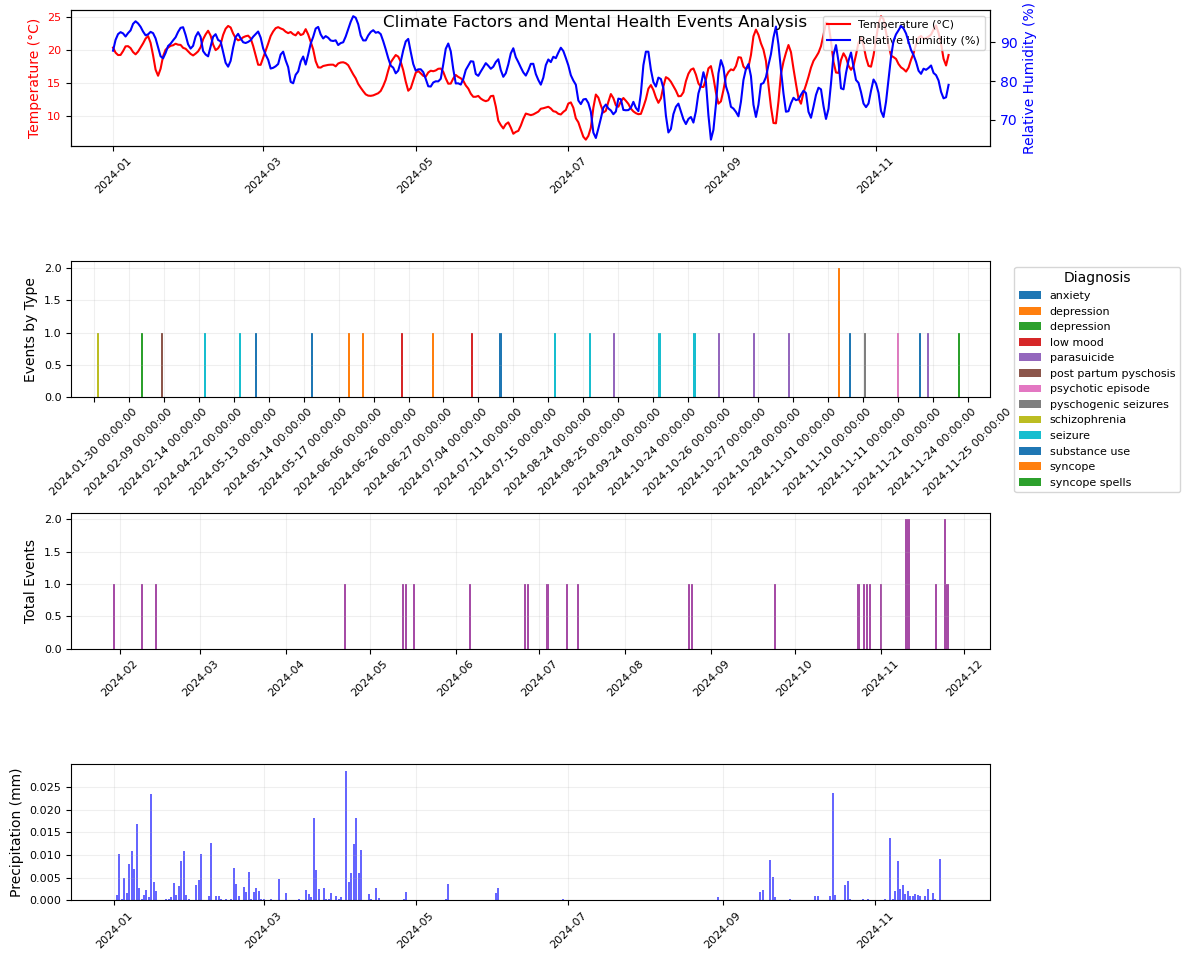


Monthly Summary:
            events  temp_mean  humid_mean  precip_sum
date                                                 
2024-01-31       1      19.94       91.50        0.13
2024-02-29       2      21.12       89.66        0.06
2024-03-31       0      20.71       87.13        0.05
2024-04-30       1      15.76       89.95        0.09
2024-05-31       3      15.12       82.52        0.00
2024-06-30       3      10.00       84.32        0.00
2024-07-31       3      10.84       74.07        0.00
2024-08-31       2      14.55       75.46        0.00
2024-09-30       1      17.27       78.74        0.02
2024-10-31       4      18.44       78.14        0.04
2024-11-30       9      20.65       83.19        0.05

Correlations with Mental Health Events:
temperature: 0.038
humidity: 0.031
precipitation: 0.015


C:\Users\CraigParker\AppData\Local\Temp\ipykernel_29632\2510552272.py:104: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'events': health_df.groupby(pd.Grouper(key='date', freq='M')).size(),
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_29632\2510552272.py:105: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'temp_mean': temp.groupby(pd.Grouper(freq='M')).mean(),
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_29632\2510552272.py:106: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'humid_mean': climate_df['relative_humidity'].groupby(pd.Grouper(freq='M')).mean(),
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_29632\2510552272.py:107: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'precip_sum': climate_df['precipitation'].groupby(pd.Grouper(freq='M')).sum()


: 

: 

In [22]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

def plot_enhanced_analysis(climate_df, health_df, window=7):
    """
    Create enhanced visualization with better formatting and humidity
    """
    # Create figure with better spacing
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), dpi=100)
    plt.subplots_adjust(hspace=0.4)

    # Temperature and Humidity plot (panel 1)
    ax1 = axes[0]
    ax1_twin = ax1.twinx()  # Create twin axis for humidity

    # Convert temperature if needed and apply smoothing
    temp = climate_df['temperature']
    if temp.mean() > 100:  # Convert from Kelvin
        temp = temp - 273.15
    
    humid = climate_df['relative_humidity']
    
    if len(temp) > window:
        temp_smooth = savgol_filter(temp, window, 3)
        humid_smooth = savgol_filter(humid, window, 3)
    else:
        temp_smooth = temp
        humid_smooth = humid

    # Plot temperature
    line1 = ax1.plot(climate_df.index, temp_smooth, 'r-', 
                     label='Temperature (°C)', linewidth=1.5)
    ax1.set_ylabel('Temperature (°C)', color='r', fontsize=10)
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.grid(True, alpha=0.2)
    
    # Plot humidity
    line2 = ax1_twin.plot(climate_df.index, humid_smooth, 'b-', 
                         label='Relative Humidity (%)', linewidth=1.5)
    ax1_twin.set_ylabel('Relative Humidity (%)', color='b', fontsize=10)
    ax1_twin.tick_params(axis='y', labelcolor='b')

    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right', fontsize=8)

    # Events by type (panel 2)
    ax2 = axes[1]
    if not health_df.empty:
        events = pd.crosstab(health_df['date'], health_df['diagnosis'])
        events.plot(kind='bar', ax=ax2, width=0.8)
        ax2.set_ylabel('Events by Type', fontsize=10)
        ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', 
                  fontsize=8, title='Diagnosis')
        ax2.grid(True, alpha=0.2)

    # Total events (panel 3)
    ax3 = axes[2]
    daily_events = health_df.groupby('date').size()
    ax3.bar(daily_events.index, daily_events.values, 
            color='purple', alpha=0.7)
    ax3.set_ylabel('Total Events', fontsize=10)
    ax3.grid(True, alpha=0.2)

    # Precipitation (panel 4)
    ax4 = axes[3]
    if 'precipitation' in climate_df.columns:
        ax4.bar(climate_df.index, climate_df['precipitation'], 
                color='blue', alpha=0.6)
        ax4.set_ylabel('Precipitation (mm)', fontsize=10)
        ax4.grid(True, alpha=0.2)

    # Format all axes
    for ax in axes:
        ax.tick_params(axis='both', labelsize=8)
        ax.tick_params(axis='x', rotation=45)
        ax.set_xlabel('')  # Remove x-label as it's redundant

    # Add title
    fig.suptitle('Climate Factors and Mental Health Events Analysis', 
                 fontsize=12, y=0.95)

    # Adjust layout
    plt.tight_layout()
    return fig

def analyze_relationships(climate_df, health_df):
    """
    Analyze relationships between climate factors and health events
    """
    results = {}
    
    # Convert temperature if needed
    temp = climate_df['temperature'].copy()
    if temp.mean() > 100:
        temp = temp - 273.15

    # Monthly summaries
    monthly_data = {
        'events': health_df.groupby(pd.Grouper(key='date', freq='M')).size(),
        'temp_mean': temp.groupby(pd.Grouper(freq='M')).mean(),
        'humid_mean': climate_df['relative_humidity'].groupby(pd.Grouper(freq='M')).mean(),
        'precip_sum': climate_df['precipitation'].groupby(pd.Grouper(freq='M')).sum()
    }
    
    # Combine monthly data
    monthly_df = pd.DataFrame(monthly_data).round(2)
    results['monthly'] = monthly_df

    # Calculate correlations
    daily_events = health_df.groupby('date').size().reindex(climate_df.index, fill_value=0)
    correlations = {
        'temperature': temp.corr(daily_events),
        'humidity': climate_df['relative_humidity'].corr(daily_events),
        'precipitation': climate_df['precipitation'].corr(daily_events)
    }
    results['correlations'] = correlations

    return results

if __name__ == "__main__":
    try:
        # Get climate data
        climate_data = get_climate_data()  # Your existing function
        
        if not climate_data.empty:
            # Process dates
            climate_data['date'] = pd.to_datetime(climate_data['date'])
            climate_data = climate_data.set_index('date')

            # Load health data
            health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
            health_data['date'] = pd.to_datetime(health_data['date'])

            # Create visualization
            fig = plot_enhanced_analysis(climate_data, health_data)
            plt.show()

            # Analyze relationships
            results = analyze_relationships(climate_data, health_data)

            # Print results
            print("\nMonthly Summary:")
            print("===============")
            print(results['monthly'])

            print("\nCorrelations with Mental Health Events:")
            print("====================================")
            for factor, corr in results['correlations'].items():
                print(f"{factor}: {corr:.3f}")

    except Exception as e:
        print(f"Error in analysis: {str(e)}")

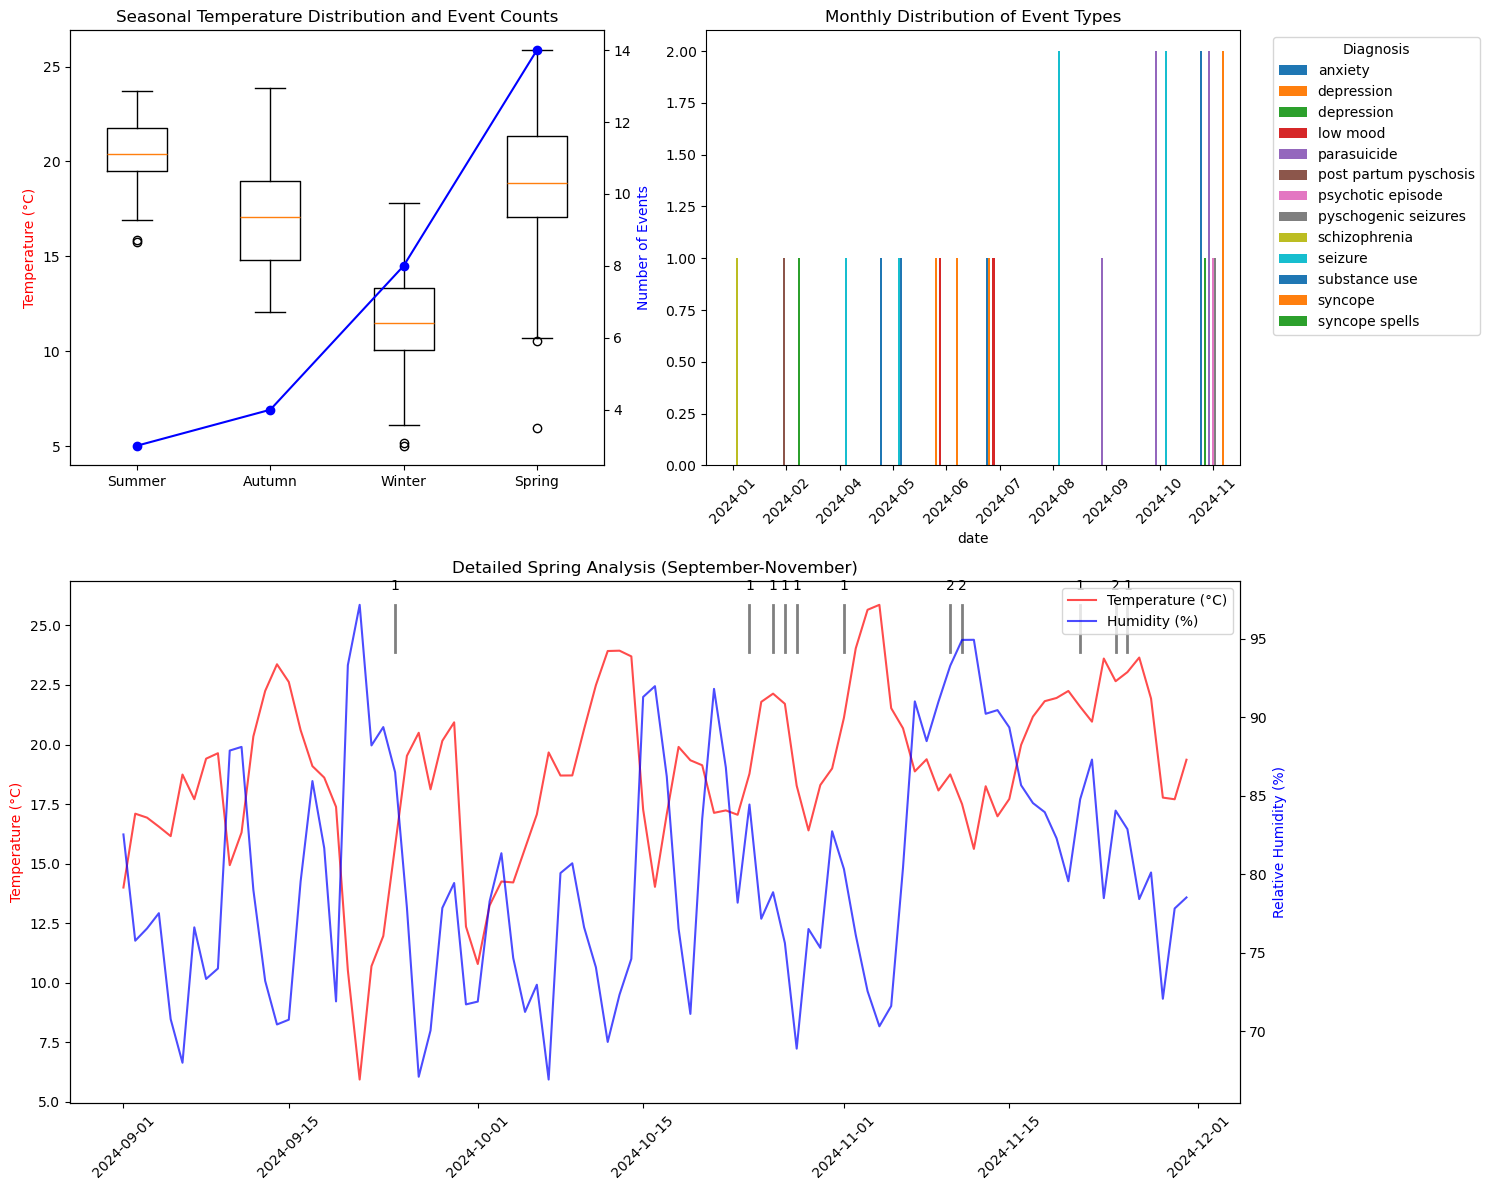


Seasonal Statistics:
        avg_temp  avg_humidity  event_count  unique_diagnoses
season                                                       
Autumn     17.21         86.50            4                 3
Spring     18.78         80.00           14                 7
Summer     20.51         90.61            3                 3
Winter     11.81         77.88            8                 5

Spring Analysis (September-November):
Total Events: 14

Events by Type:
diagnosis
parasuicide             5
seizure                 2
syncope                 2
anxiety                 2
pyschogenic seizures    1
psychotic episode       1
depression              1
Name: count, dtype: int64

Average Temperature: 18.8°C
Average Humidity: 80.0%


: 

: 

In [23]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

def plot_seasonal_analysis(climate_df, health_df):
    """
    Create seasonal analysis visualization
    """
    # Create figure with two rows
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])
    
    # Define seasons (Southern Hemisphere)
    seasons = {
        'Summer': [12, 1, 2],
        'Autumn': [3, 4, 5],
        'Winter': [6, 7, 8],
        'Spring': [9, 10, 11]
    }
    
    # Convert temperature if needed
    temp = climate_df['temperature'].copy()
    if temp.mean() > 100:
        temp = temp - 273.15
    climate_df['temperature_c'] = temp
    
    # Add season information to both dataframes
    climate_df['season'] = climate_df.index.month.map(
        {m: s for s, months in seasons.items() for m in months})
    health_df['season'] = pd.to_datetime(health_df['date']).dt.month.map(
        {m: s for s, months in seasons.items() for m in months})
    
    # 1. Seasonal Temperature and Events Box Plot (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    climate_seasonal = climate_df.groupby('season')['temperature_c'].agg(list)
    health_seasonal = health_df.groupby('season').size()
    
    bp = ax1.boxplot([climate_seasonal[season] for season in seasons.keys()],
                     labels=seasons.keys())
    ax1.set_ylabel('Temperature (°C)', color='red')
    ax1_twin = ax1.twinx()
    ax1_twin.plot(range(1, 5), [health_seasonal.get(season, 0) 
                               for season in seasons.keys()],
                 'b-o', label='Events')
    ax1_twin.set_ylabel('Number of Events', color='blue')
    ax1.set_title('Seasonal Temperature Distribution and Event Counts')
    
    # 2. Monthly Event Types (top right)
    ax2 = fig.add_subplot(gs[0, 1])
    monthly_events = health_df.groupby([health_df['date'].dt.strftime('%Y-%m'), 
                                      'diagnosis']).size().unstack(fill_value=0)
    monthly_events.plot(kind='bar', ax=ax2)
    ax2.set_title('Monthly Distribution of Event Types')
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend(bbox_to_anchor=(1.05, 1), title='Diagnosis')
    
    # 3. Detailed Spring Analysis (bottom)
    ax3 = fig.add_subplot(gs[1, :])
    spring_data = climate_df[climate_df['season'] == 'Spring'].copy()
    spring_events = health_df[health_df['season'] == 'Spring'].copy()
    
    # Plot temperature and humidity
    line1 = ax3.plot(spring_data.index, spring_data['temperature_c'], 
                     'r-', label='Temperature (°C)', alpha=0.7)
    ax3_twin = ax3.twinx()
    line2 = ax3_twin.plot(spring_data.index, spring_data['relative_humidity'], 
                         'b-', label='Humidity (%)', alpha=0.7)
    
    # Add event markers
    event_counts = spring_events.groupby('date').size()
    max_temp = spring_data['temperature_c'].max()
    for date, count in event_counts.items():
        ax3.plot([date, date], [max_temp-2, max_temp], 
                'k-', linewidth=2, alpha=0.5)
        ax3.text(date, max_temp+0.5, str(count), 
                ha='center', va='bottom')
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax3.legend(lines, labels, loc='upper right')
    
    ax3.set_title('Detailed Spring Analysis (September-November)')
    ax3.set_ylabel('Temperature (°C)', color='red')
    ax3_twin.set_ylabel('Relative Humidity (%)', color='blue')
    ax3.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

def analyze_seasonal_patterns(climate_df, health_df):
    """
    Analyze seasonal patterns in the data
    """
    # Convert temperature if needed
    temp = climate_df['temperature'].copy()
    if temp.mean() > 100:
        temp = temp - 273.15
    
    # Define seasons
    seasons = {
        'Summer': [12, 1, 2],
        'Autumn': [3, 4, 5],
        'Winter': [6, 7, 8],
        'Spring': [9, 10, 11]
    }
    
    # Add season information
    climate_df['season'] = climate_df.index.month.map(
        {m: s for s, months in seasons.items() for m in months})
    health_df['season'] = pd.to_datetime(health_df['date']).dt.month.map(
        {m: s for s, months in seasons.items() for m in months})
    
    # Calculate seasonal statistics
    seasonal_stats = pd.DataFrame({
        'avg_temp': climate_df.groupby('season')['temperature'].mean() - 273.15,
        'avg_humidity': climate_df.groupby('season')['relative_humidity'].mean(),
        'event_count': health_df.groupby('season').size(),
        'unique_diagnoses': health_df.groupby('season')['diagnosis'].nunique()
    }).round(2)
    
    # Calculate spring-specific statistics
    spring_data = climate_df[climate_df['season'] == 'Spring'].copy()
    spring_events = health_df[health_df['season'] == 'Spring'].copy()
    
    spring_stats = {
        'total_events': len(spring_events),
        'events_by_type': spring_events['diagnosis'].value_counts(),
        'avg_temp': spring_data['temperature'].mean() - 273.15,
        'avg_humidity': spring_data['relative_humidity'].mean()
    }
    
    return seasonal_stats, spring_stats

if __name__ == "__main__":
    try:
        # Get climate data
        climate_data = get_climate_data()  # Your existing function
        
        if not climate_data.empty:
            # Process dates
            climate_data['date'] = pd.to_datetime(climate_data['date'])
            climate_data = climate_data.set_index('date')
            
            # Load health data
            health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
            health_data['date'] = pd.to_datetime(health_data['date'])
            
            # Create seasonal visualization
            fig = plot_seasonal_analysis(climate_data, health_data)
            plt.show()
            
            # Analyze seasonal patterns
            seasonal_stats, spring_stats = analyze_seasonal_patterns(climate_data, health_data)
            
            print("\nSeasonal Statistics:")
            print("===================")
            print(seasonal_stats)
            
            print("\nSpring Analysis (September-November):")
            print("===================================")
            print(f"Total Events: {spring_stats['total_events']}")
            print("\nEvents by Type:")
            print(spring_stats['events_by_type'])
            print(f"\nAverage Temperature: {spring_stats['avg_temp']:.1f}°C")
            print(f"Average Humidity: {spring_stats['avg_humidity']:.1f}%")
            
    except Exception as e:
        print(f"Error in analysis: {str(e)}")

In [24]:
import ee

# Initialize Earth Engine
try:
    ee.Initialize()
    logger.info("Earth Engine initialized successfully!")
except Exception as e:
    logger.error(f"Error initializing Earth Engine: {str(e)}")
    logger.info("Please ensure you have authenticated with Earth Engine")

2024-12-19 17:12:51,579 - INFO - Earth Engine initialized successfully!


: 

: 

Retrieving climate data from Earth Engine...
Processing years 2015-2016...
Processing years 2017-2018...
Processing years 2019-2020...
Processing years 2021-2022...
Processing years 2023-2023...

Generating temperature trend visualization...


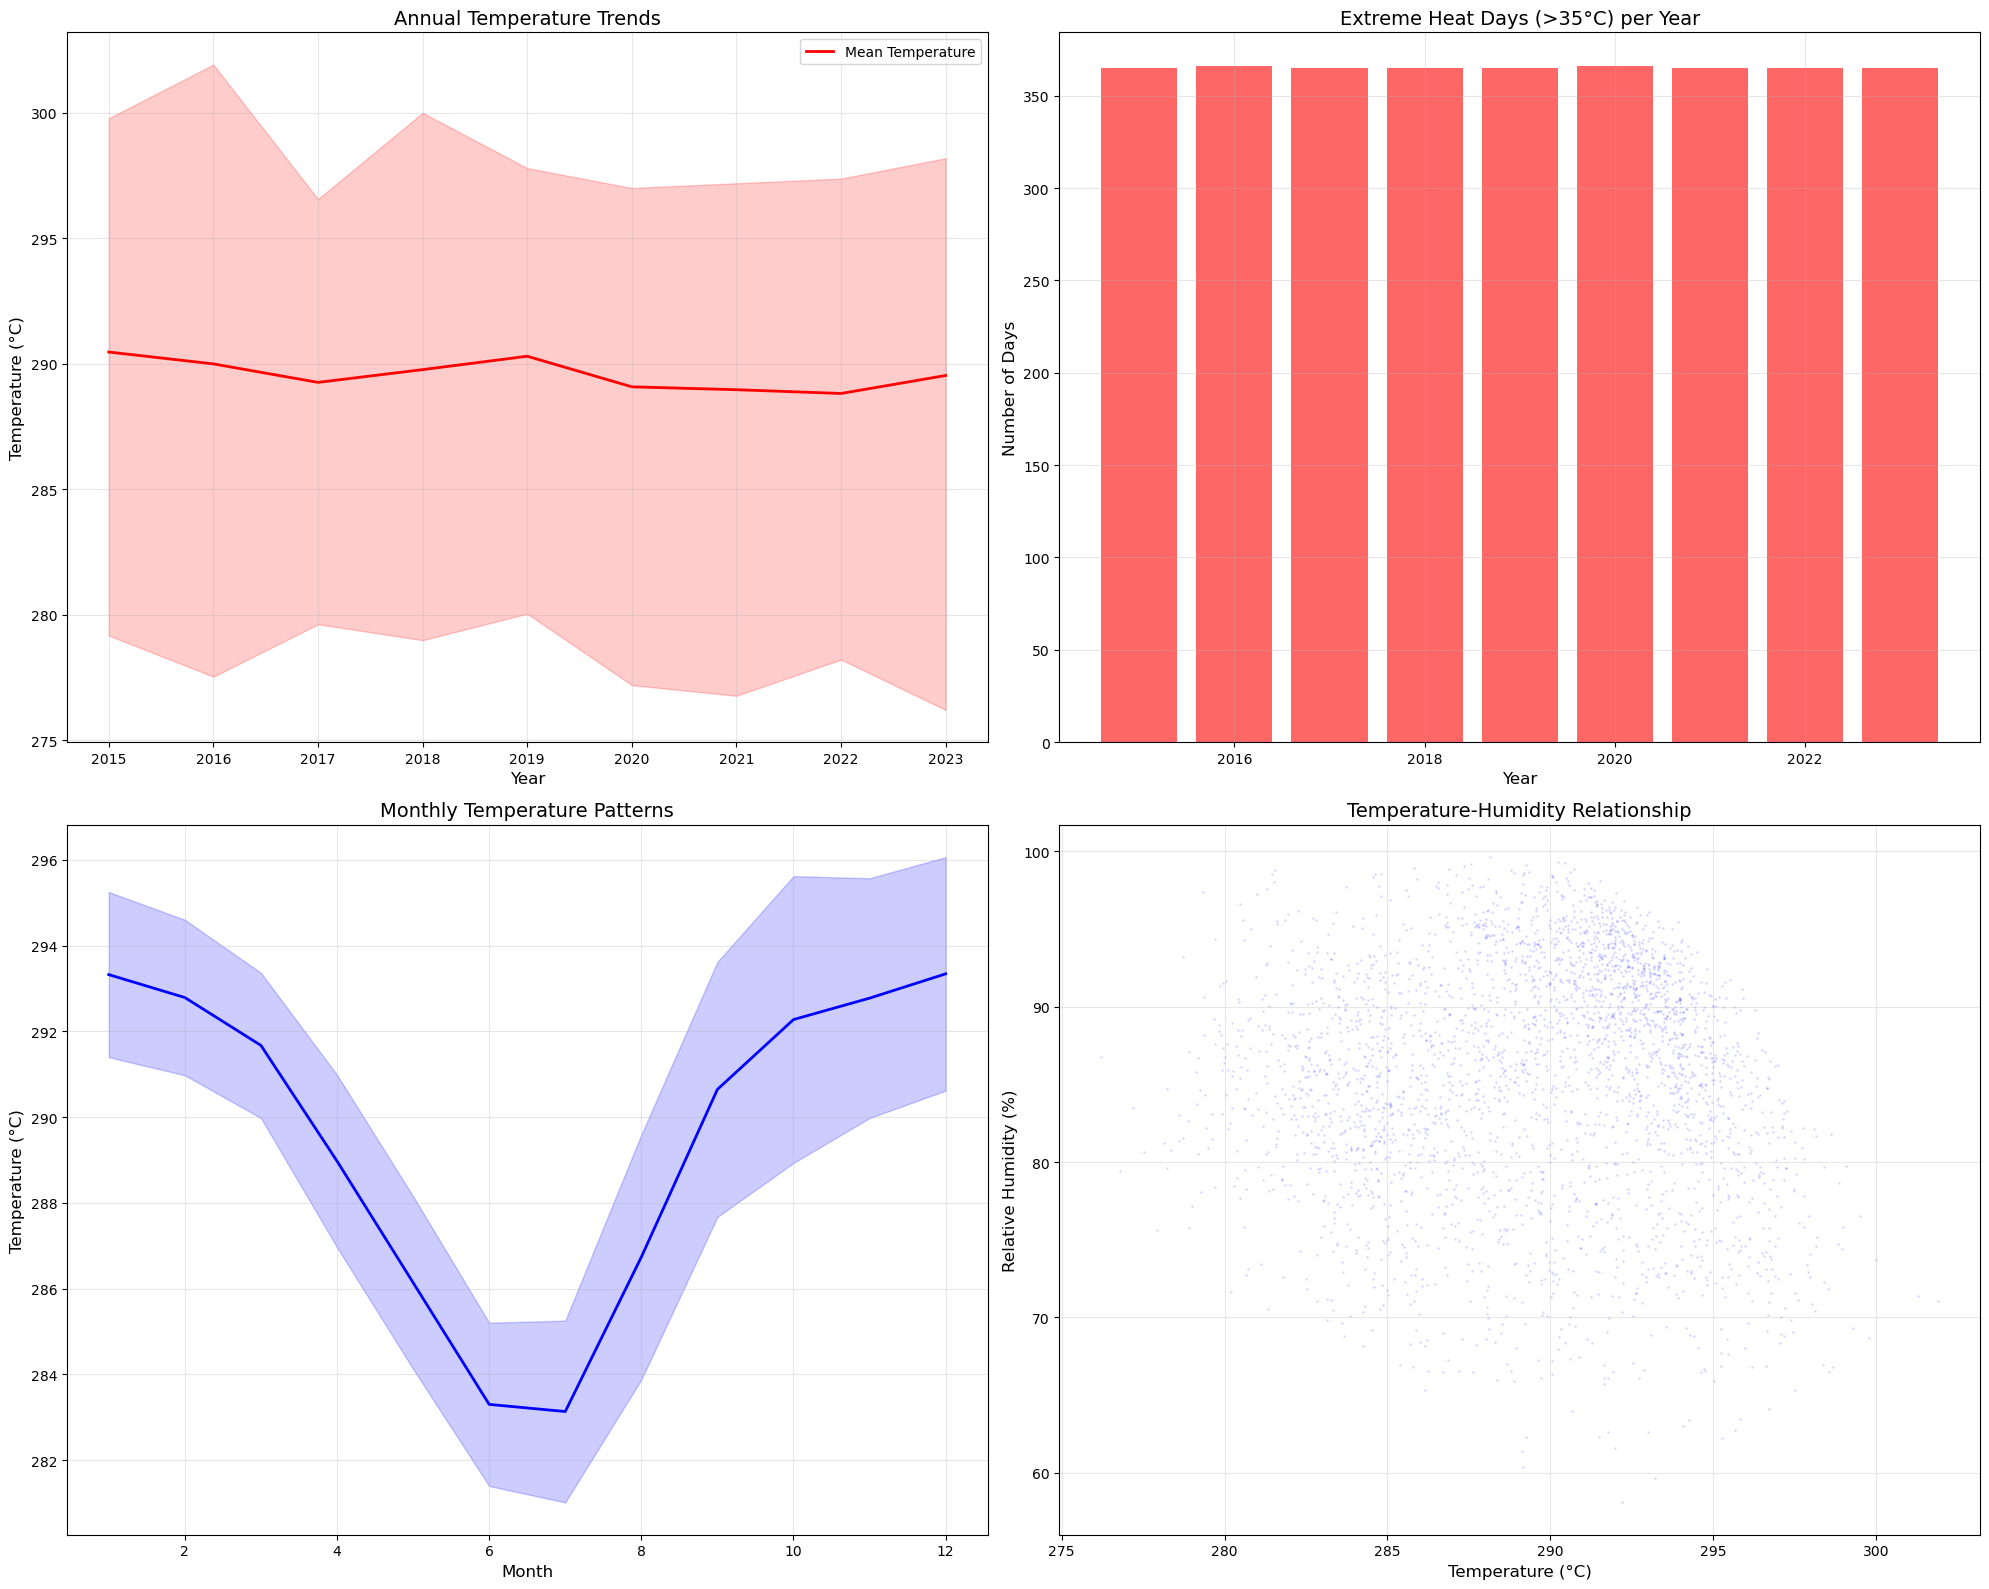


Annual Climate Statistics:
     temperature                 relative_humidity precipitation
            mean     min     max              mean           sum
date                                                            
2015      290.47  279.18  299.78             83.24          0.48
2016      290.00  277.54  301.91             84.93          0.77
2017      289.26  279.63  296.56             85.78          0.79
2018      289.77  278.99  299.99             84.06          0.66
2019      290.30  280.05  297.79             84.24          0.75
2020      289.08  277.20  297.00             86.46          0.72
2021      288.97  276.78  297.19             86.20          0.85
2022      288.82  278.22  297.38             88.28          0.95
2023      289.53  276.21  298.19             85.88          0.61

Temperature change 2015-2023: -0.93°C


: 

: 

In [25]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# First authenticate and initialize
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

class JohannesburgClimateAnalyzer:
    def __init__(self, latitude=-26.2041, longitude=28.0473):
        self.latitude = latitude
        self.longitude = longitude
        self.point = ee.Geometry.Point([longitude, latitude])
        
    def get_climate_data_chunked(self, start_year=2000, end_year=2024, chunk_size=2):
        """Retrieve climate data in smaller chunks to avoid timeout"""
        all_data = []
        
        # Process data in chunks of years
        for year in range(start_year, end_year + 1, chunk_size):
            chunk_end = min(year + chunk_size, end_year + 1)
            print(f"Processing years {year}-{chunk_end-1}...")
            
            try:
                # Get data for current chunk
                start_date = f'{year}-01-01'
                end_date = f'{chunk_end}-01-01'
                
                era5_data = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
                    .filterDate(start_date, end_date) \
                    .filterBounds(self.point) \
                    .select([
                        'temperature_2m',
                        'dewpoint_temperature_2m',
                        'total_precipitation_sum'
                    ])
                
                def extract_data(image):
                    data = image.reduceRegion(
                        reducer=ee.Reducer.mean(),
                        geometry=self.point,
                        scale=11132
                    )
                    return ee.Feature(None, {
                        'date': image.date().format('YYYY-MM-dd'),
                        'temperature': data.get('temperature_2m'),
                        'dewpoint': data.get('dewpoint_temperature_2m'),
                        'precipitation': data.get('total_precipitation_sum')
                    })
                
                features = era5_data.map(extract_data)
                chunk_data = features.getInfo()
                
                if chunk_data and 'features' in chunk_data:
                    chunk_df = pd.DataFrame([
                        {
                            'date': datetime.strptime(f['properties']['date'], '%Y-%m-%d'),
                            'temperature': f['properties']['temperature'],
                            'dewpoint': f['properties']['dewpoint'],
                            'precipitation': f['properties'].get('precipitation', 0)
                        }
                        for f in chunk_data['features']
                    ])
                    all_data.append(chunk_df)
                
            except Exception as e:
                print(f"Error processing years {year}-{chunk_end-1}: {str(e)}")
                continue
        
        if not all_data:
            return pd.DataFrame()
            
        # Combine all chunks
        df = pd.concat(all_data, ignore_index=True)
        
        # Calculate relative humidity
        df['relative_humidity'] = 100 * (np.exp((17.625 * df['dewpoint']) / 
                                               (243.04 + df['dewpoint'])) / 
                                       np.exp((17.625 * df['temperature']) / 
                                             (243.04 + df['temperature'])))
        
        return df.sort_values('date')

    def plot_enhanced_trends(self, df):
        """Create enhanced visualization of temperature trends"""
        if df.empty:
            print("No data to plot")
            return None
            
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
        
        # 1. Annual temperature trends
        yearly = df.groupby(df['date'].dt.year).agg({
            'temperature': ['mean', 'min', 'max'],
            'relative_humidity': 'mean'
        })
        
        ax1.plot(yearly.index, yearly[('temperature', 'mean')], 'r-', 
                label='Mean Temperature', linewidth=2)
        ax1.fill_between(yearly.index, 
                        yearly[('temperature', 'min')], 
                        yearly[('temperature', 'max')], 
                        color='red', alpha=0.2)
        ax1.set_title('Annual Temperature Trends', fontsize=14)
        ax1.set_xlabel('Year', fontsize=12)
        ax1.set_ylabel('Temperature (°C)', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # 2. Extreme heat days trend
        yearly_extremes = df[df['temperature'] > 35].groupby(df['date'].dt.year).size()
        ax2.bar(yearly_extremes.index, yearly_extremes.values, 
                color='red', alpha=0.6)
        ax2.set_title('Extreme Heat Days (>35°C) per Year', fontsize=14)
        ax2.set_xlabel('Year', fontsize=12)
        ax2.set_ylabel('Number of Days', fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        # 3. Monthly temperature patterns
        df['month'] = df['date'].dt.month
        monthly = df.groupby('month')['temperature'].agg(['mean', 'std']).reset_index()
        ax3.plot(monthly['month'], monthly['mean'], 'b-', linewidth=2)
        ax3.fill_between(monthly['month'],
                        monthly['mean'] - monthly['std'],
                        monthly['mean'] + monthly['std'],
                        color='blue', alpha=0.2)
        ax3.set_title('Monthly Temperature Patterns', fontsize=14)
        ax3.set_xlabel('Month', fontsize=12)
        ax3.set_ylabel('Temperature (°C)', fontsize=12)
        ax3.grid(True, alpha=0.3)
        
        # 4. Temperature-Humidity relationship
        ax4.scatter(df['temperature'], df['relative_humidity'],
                   alpha=0.1, c='blue', s=1)
        ax4.set_title('Temperature-Humidity Relationship', fontsize=14)
        ax4.set_xlabel('Temperature (°C)', fontsize=12)
        ax4.set_ylabel('Relative Humidity (%)', fontsize=12)
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

def main():
    # Create analyzer instance
    analyzer = JohannesburgClimateAnalyzer()
    
    # Get climate data in chunks
    print("Retrieving climate data from Earth Engine...")
    climate_data = analyzer.get_climate_data_chunked(start_year=2015, end_year=2023)
    
    if not climate_data.empty:
        # Create visualization
        print("\nGenerating temperature trend visualization...")
        fig = analyzer.plot_enhanced_trends(climate_data)
        plt.show()
        
        # Print summary statistics
        print("\nAnnual Climate Statistics:")
        yearly_stats = climate_data.groupby(climate_data['date'].dt.year).agg({
            'temperature': ['mean', 'min', 'max'],
            'relative_humidity': 'mean',
            'precipitation': 'sum'
        }).round(2)
        print(yearly_stats)
        
        # Calculate trend
        years = climate_data.groupby(climate_data['date'].dt.year)['temperature'].mean()
        temp_change = years.iloc[-1] - years.iloc[0]
        print(f"\nTemperature change {years.index[0]}-{years.index[-1]}: {temp_change:.2f}°C")
        
    else:
        print("Error: Failed to retrieve climate data")

if __name__ == "__main__":
    main()

Retrieving climate data from Earth Engine...
Processing years 1990-1991...
Processing years 1992-1993...
Processing years 1994-1995...
Processing years 1996-1997...
Processing years 1998-1999...
Processing years 2000-2001...
Processing years 2002-2003...
Processing years 2004-2005...
Processing years 2006-2007...
Processing years 2008-2009...
Processing years 2010-2011...
Processing years 2012-2013...
Processing years 2014-2015...
Processing years 2016-2017...
Processing years 2018-2019...
Processing years 2020-2021...
Processing years 2022-2023...

Generating temperature trend visualization...


C:\Users\CraigParker\AppData\Local\Temp\ipykernel_29632\614232055.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


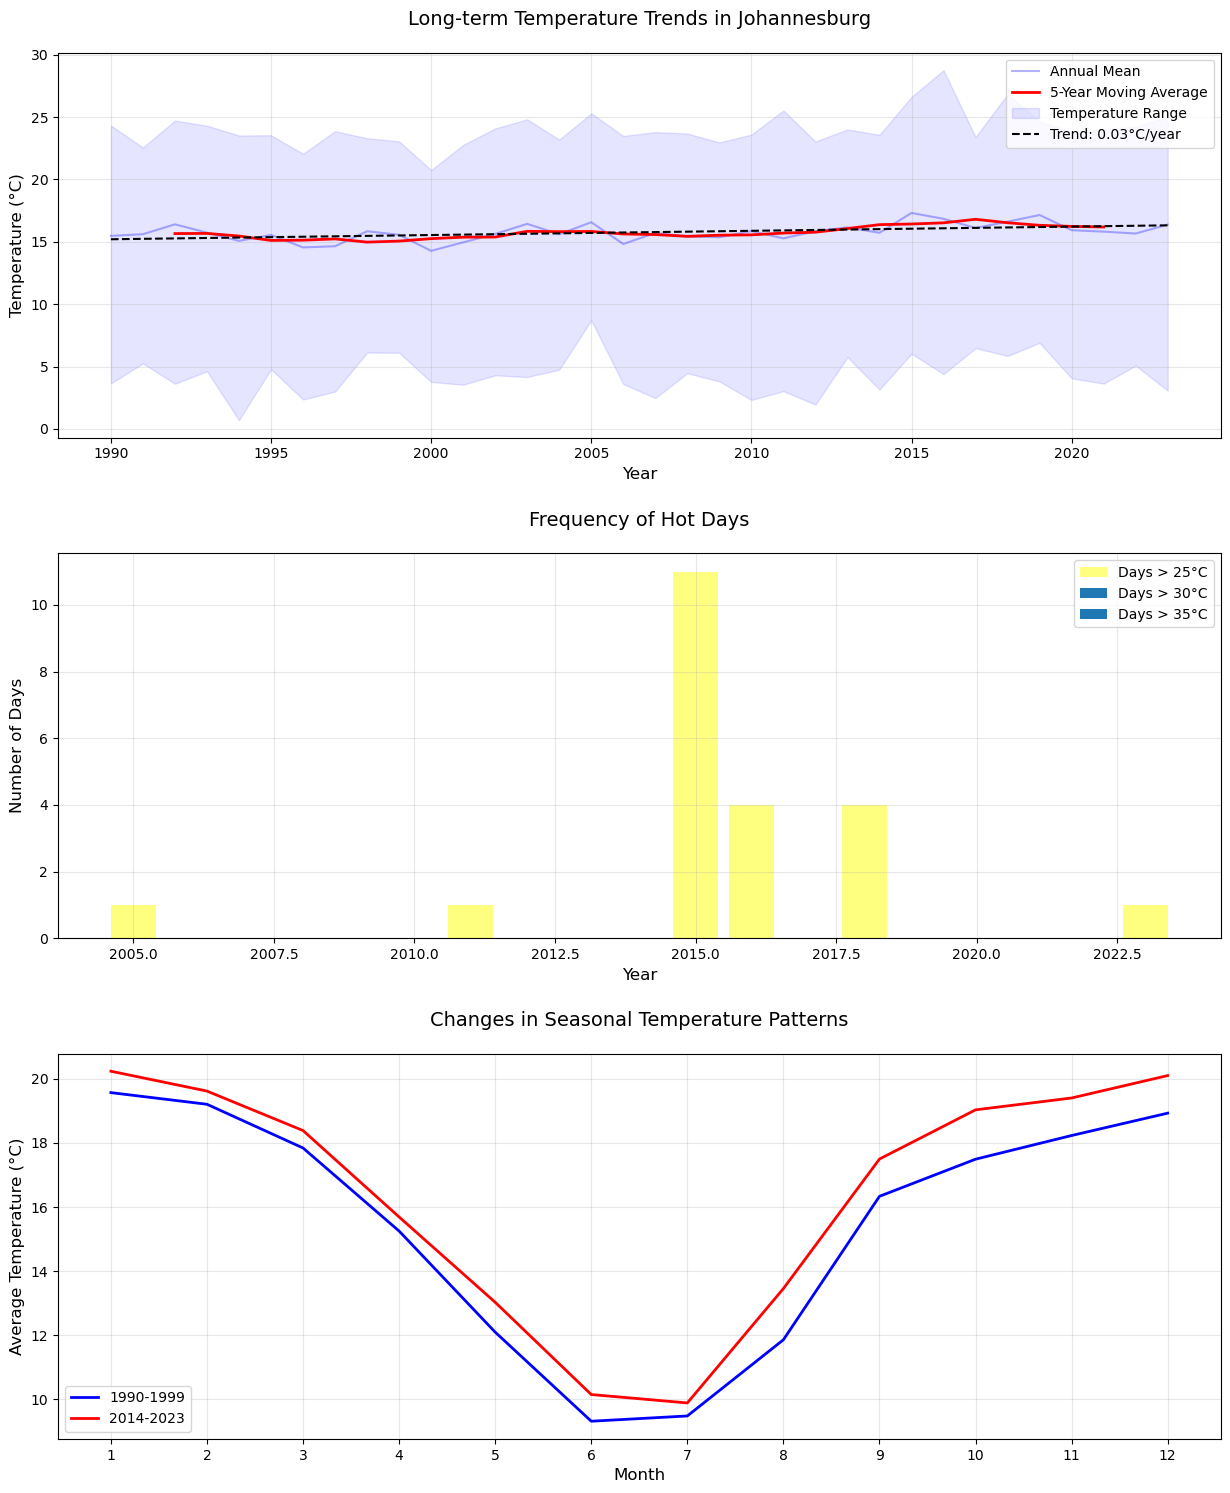


Long-term Temperature Analysis:

Yearly Statistics:
     temperature                    relative_humidity
            mean   min    max   std              mean
date                                                 
1990       15.48  3.64  24.33  4.45             59.37
1991       15.61  5.25  22.57  4.03             57.23
1992       16.40  3.62  24.73  4.75             49.99
1993       15.74  4.62  24.32  4.02             56.17
1994       15.07  0.69  23.53  4.47             54.56
1995       15.55  4.78  23.55  4.19             58.42
1996       14.55  2.35  22.06  4.42             64.81
1997       14.65  2.99  23.88  4.55             64.31
1998       15.85  6.11  23.31  3.91             57.26
1999       15.56  6.11  23.06  3.91             57.91
2000       14.28  3.76  20.75  3.85             67.43
2001       14.96  3.54  22.77  3.95             64.08
2002       15.64  4.29  24.10  4.35             57.76
2003       16.44  4.15  24.82  4.68             52.35
2004       15.61  4.75  23.20

: 

: 

In [26]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

class JohannesburgClimateAnalyzer:
    def __init__(self, latitude=-26.2041, longitude=28.0473):
        self.latitude = latitude
        self.longitude = longitude
        self.point = ee.Geometry.Point([longitude, latitude])
        
    def get_climate_data_chunked(self, start_year=1990, end_year=2024, chunk_size=2):
        """Retrieve climate data in smaller chunks to avoid timeout"""
        all_data = []
        
        for year in range(start_year, end_year + 1, chunk_size):
            chunk_end = min(year + chunk_size, end_year + 1)
            print(f"Processing years {year}-{chunk_end-1}...")
            
            try:
                start_date = f'{year}-01-01'
                end_date = f'{chunk_end}-01-01'
                
                era5_data = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
                    .filterDate(start_date, end_date) \
                    .filterBounds(self.point) \
                    .select([
                        'temperature_2m',
                        'dewpoint_temperature_2m',
                        'total_precipitation_sum'
                    ])
                
                def extract_data(image):
                    data = image.reduceRegion(
                        reducer=ee.Reducer.mean(),
                        geometry=self.point,
                        scale=11132
                    )
                    return ee.Feature(None, {
                        'date': image.date().format('YYYY-MM-dd'),
                        'temperature': data.get('temperature_2m'),
                        'dewpoint': data.get('dewpoint_temperature_2m'),
                        'precipitation': data.get('total_precipitation_sum')
                    })
                
                features = era5_data.map(extract_data)
                chunk_data = features.getInfo()
                
                if chunk_data and 'features' in chunk_data:
                    chunk_df = pd.DataFrame([
                        {
                            'date': datetime.strptime(f['properties']['date'], '%Y-%m-%d'),
                            'temperature': f['properties']['temperature'] - 273.15,  # Convert to Celsius
                            'dewpoint': f['properties']['dewpoint'] - 273.15,  # Convert to Celsius
                            'precipitation': f['properties'].get('precipitation', 0)
                        }
                        for f in chunk_data['features']
                    ])
                    all_data.append(chunk_df)
                
            except Exception as e:
                print(f"Error processing years {year}-{chunk_end-1}: {str(e)}")
                continue
        
        if not all_data:
            return pd.DataFrame()
            
        # Combine chunks and process data
        df = pd.concat(all_data, ignore_index=True)
        df = df.sort_values('date')
        
        # Calculate relative humidity
        df['relative_humidity'] = 100 * (np.exp((17.625 * df['dewpoint']) / 
                                               (243.04 + df['dewpoint'])) / 
                                       np.exp((17.625 * df['temperature']) / 
                                             (243.04 + df['temperature'])))
        
        return df

    def plot_climate_trends(self, df):
        """Create enhanced visualization of temperature trends"""
        if df.empty:
            print("No data to plot")
            return None
        
        # Create figure with grid
        fig = plt.figure(figsize=(15, 18))
        gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1], hspace=0.3)
        
        # 1. Annual Temperature Trends
        ax1 = fig.add_subplot(gs[0])
        yearly_data = df.groupby(df['date'].dt.year)['temperature'].agg(['mean', 'min', 'max'])
        
        # Calculate 5-year moving average
        ma_5year = yearly_data['mean'].rolling(window=5, center=True).mean()
        
        # Plot data
        ax1.plot(yearly_data.index, yearly_data['mean'], 'b-', alpha=0.3, label='Annual Mean')
        ax1.plot(yearly_data.index, ma_5year, 'r-', linewidth=2, label='5-Year Moving Average')
        ax1.fill_between(yearly_data.index, yearly_data['min'], yearly_data['max'], 
                        color='blue', alpha=0.1, label='Temperature Range')
        
        # Add trend line
        z = np.polyfit(range(len(yearly_data.index)), yearly_data['mean'], 1)
        p = np.poly1d(z)
        ax1.plot(yearly_data.index, p(range(len(yearly_data.index))), 
                'k--', label=f'Trend: {z[0]:.2f}°C/year')
        
        ax1.set_title('Long-term Temperature Trends in Johannesburg', fontsize=14, pad=20)
        ax1.set_xlabel('Year', fontsize=12)
        ax1.set_ylabel('Temperature (°C)', fontsize=12)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Heat Days Analysis
        ax2 = fig.add_subplot(gs[1])
        heat_thresholds = [25, 30, 35]
        colors = ['yellow', 'orange', 'red']
        
        for threshold, color in zip(heat_thresholds, colors):
            yearly_extremes = df[df['temperature'] > threshold].groupby(df['date'].dt.year).size()
            ax2.bar(yearly_extremes.index, yearly_extremes.values, 
                   alpha=0.5, color=color, 
                   label=f'Days > {threshold}°C', bottom=0)
        
        ax2.set_title('Frequency of Hot Days', fontsize=14, pad=20)
        ax2.set_xlabel('Year', fontsize=12)
        ax2.set_ylabel('Number of Days', fontsize=12)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Seasonal Changes
        ax3 = fig.add_subplot(gs[2])
        
        early_years = sorted(df['date'].dt.year.unique())[:10]
        recent_years = sorted(df['date'].dt.year.unique())[-10:]
        
        early_data = df[df['date'].dt.year.isin(early_years)]
        recent_data = df[df['date'].dt.year.isin(recent_years)]
        
        # Calculate monthly averages
        early_monthly = early_data.groupby(early_data['date'].dt.month)['temperature'].mean()
        recent_monthly = recent_data.groupby(recent_data['date'].dt.month)['temperature'].mean()
        
        months = range(1, 13)
        ax3.plot(months, early_monthly, 'b-', 
                label=f'{early_years[0]}-{early_years[-1]}', linewidth=2)
        ax3.plot(months, recent_monthly, 'r-', 
                label=f'{recent_years[0]}-{recent_years[-1]}', linewidth=2)
        
        ax3.set_title('Changes in Seasonal Temperature Patterns', fontsize=14, pad=20)
        ax3.set_xlabel('Month', fontsize=12)
        ax3.set_ylabel('Average Temperature (°C)', fontsize=12)
        ax3.set_xticks(months)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

def main():
    try:
        ee.Initialize()
    except:
        ee.Authenticate()
        ee.Initialize()
        
    analyzer = JohannesburgClimateAnalyzer()
    
    # Get longer-term climate data
    print("Retrieving climate data from Earth Engine...")
    climate_data = analyzer.get_climate_data_chunked(start_year=1990, end_year=2023)
    
    if not climate_data.empty:
        # Create visualization
        print("\nGenerating temperature trend visualization...")
        fig = analyzer.plot_climate_trends(climate_data)
        plt.show()
        
        # Calculate and print trend statistics
        print("\nLong-term Temperature Analysis:")
        
        # Annual statistics
        yearly_stats = climate_data.groupby(climate_data['date'].dt.year).agg({
            'temperature': ['mean', 'min', 'max', 'std'],
            'relative_humidity': 'mean'
        }).round(2)
        
        print("\nYearly Statistics:")
        print(yearly_stats)
        
        # Calculate trend
        years = climate_data.groupby(climate_data['date'].dt.year)['temperature'].mean()
        temp_change = years.iloc[-1] - years.iloc[0]
        years_count = years.index[-1] - years.index[0]
        
        print(f"\nTemperature Change ({years.index[0]}-{years.index[-1]}):")
        print(f"Total change: {temp_change:.2f}°C")
        print(f"Rate of change: {temp_change/years_count:.3f}°C per year")
        
        # Hot days analysis
        for threshold in [25, 30, 35]:
            print(f"\nDays above {threshold}°C:")
            early_period = climate_data[climate_data['date'].dt.year <= 2000]
            recent_period = climate_data[climate_data['date'].dt.year >= 2014]
            
            early_days = (early_period['temperature'] > threshold).sum() / len(early_period['date'].dt.year.unique())
            recent_days = (recent_period['temperature'] > threshold).sum() / len(recent_period['date'].dt.year.unique())
            
            print(f"1990s average: {early_days:.1f} days/year")
            print(f"Recent average: {recent_days:.1f} days/year")
            print(f"Change: {recent_days - early_days:+.1f} days/year")
    
    else:
        print("Error: Failed to retrieve climate data")

if __name__ == "__main__":
    main()

Retrieving climate data from Earth Engine...
Processing years 1960-1961...
Processing years 1962-1963...
Processing years 1964-1965...
Processing years 1966-1967...
Processing years 1968-1969...
Processing years 1970-1971...
Processing years 1972-1973...
Processing years 1974-1975...
Processing years 1976-1977...
Processing years 1978-1979...
Processing years 1980-1981...
Processing years 1982-1983...
Processing years 1984-1985...
Processing years 1986-1987...
Processing years 1988-1989...
Processing years 1990-1991...
Processing years 1992-1993...
Processing years 1994-1995...
Processing years 1996-1997...
Processing years 1998-1999...
Processing years 2000-2001...
Processing years 2002-2003...
Processing years 2004-2005...
Processing years 2006-2007...
Processing years 2008-2009...
Processing years 2010-2011...
Processing years 2012-2013...
Processing years 2014-2015...
Processing years 2016-2017...
Processing years 2018-2019...
Processing years 2020-2021...
Processing years 2022-202

C:\Users\CraigParker\AppData\Local\Temp\ipykernel_29632\3794938439.py:174: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


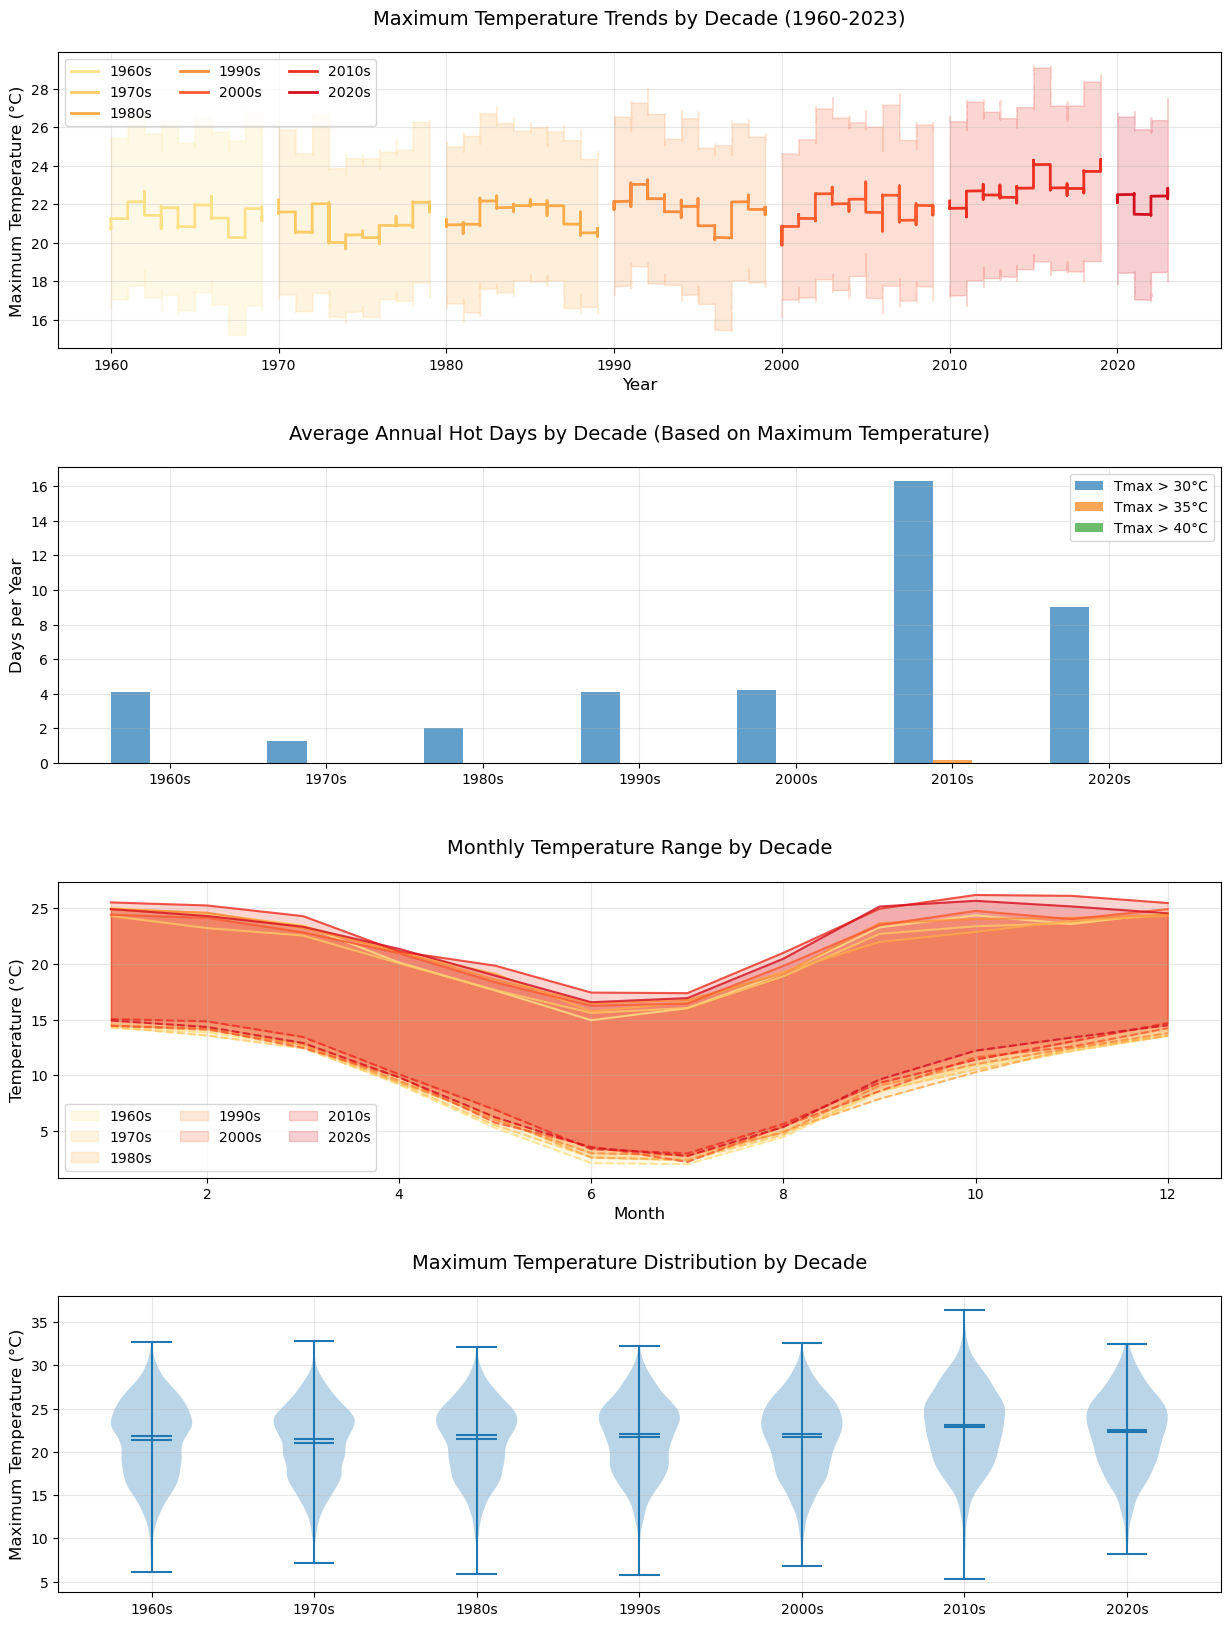


Decadal Maximum Temperature Statistics:
         tmax                      tmin              precipitation
         mean   std   min    max   mean   min    max           sum
decade                                                            
1960    21.35  4.50  6.15  32.67   9.06 -4.40  18.56          7.61
1970    21.01  4.18  7.21  32.81   9.13 -4.71  18.20          8.60
1980    21.44  4.19  5.85  32.17   9.24 -3.97  18.41          8.38
1990    21.71  4.27  5.78  32.18   9.47 -3.99  18.58          7.93
2000    21.67  4.33  6.81  32.61   9.56 -3.79  19.38          7.76
2010    22.84  4.50  5.33  36.44  10.05 -3.81  21.16          7.40
2020    22.24  4.37  8.21  32.52   9.95 -2.83  19.87          3.14

Changes in Hot Days (based on Maximum Temperature):

Days above 30°C by decade:
1960s: 1.1% of days
1970s: 0.4% of days
1980s: 0.5% of days
1990s: 1.1% of days
2000s: 1.1% of days
2010s: 4.5% of days
2020s: 2.5% of days

Days above 35°C by decade:
1960s: nan% of days
1970s: nan% of days


: 

: 

In [27]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

class JohannesburgClimateAnalyzer:
    def __init__(self, latitude=-26.2041, longitude=28.0473):
        self.latitude = latitude
        self.longitude = longitude
        self.point = ee.Geometry.Point([longitude, latitude])
        
    def get_climate_data_chunked(self, start_year=1960, end_year=2023, chunk_size=2):
        """Retrieve climate data in smaller chunks to avoid timeout"""
        all_data = []
        
        for year in range(start_year, end_year + 1, chunk_size):
            chunk_end = min(year + chunk_size, end_year + 1)
            print(f"Processing years {year}-{chunk_end-1}...")
            
            try:
                start_date = f'{year}-01-01'
                end_date = f'{chunk_end}-01-01'
                
                era5_data = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
                    .filterDate(start_date, end_date) \
                    .filterBounds(self.point) \
                    .select([
                        'temperature_2m_max',  # Maximum temperature
                        'temperature_2m_min',  # Minimum temperature
                        'temperature_2m',      # Mean temperature
                        'dewpoint_temperature_2m',
                        'total_precipitation_sum'
                    ])
                
                def extract_data(image):
                    data = image.reduceRegion(
                        reducer=ee.Reducer.mean(),
                        geometry=self.point,
                        scale=11132
                    )
                    return ee.Feature(None, {
                        'date': image.date().format('YYYY-MM-dd'),
                        'tmax': data.get('temperature_2m_max'),
                        'tmin': data.get('temperature_2m_min'),
                        'tmean': data.get('temperature_2m'),
                        'dewpoint': data.get('dewpoint_temperature_2m'),
                        'precipitation': data.get('total_precipitation_sum')
                    })
                
                features = era5_data.map(extract_data)
                chunk_data = features.getInfo()
                
                if chunk_data and 'features' in chunk_data:
                    chunk_df = pd.DataFrame([
                        {
                            'date': datetime.strptime(f['properties']['date'], '%Y-%m-%d'),
                            'tmax': f['properties']['tmax'] - 273.15,
                            'tmin': f['properties']['tmin'] - 273.15,
                            'tmean': f['properties']['tmean'] - 273.15,
                            'dewpoint': f['properties']['dewpoint'] - 273.15,
                            'precipitation': f['properties'].get('precipitation', 0)
                        }
                        for f in chunk_data['features']
                    ])
                    all_data.append(chunk_df)
                
            except Exception as e:
                print(f"Error processing years {year}-{chunk_end-1}: {str(e)}")
                continue
        
        if not all_data:
            return pd.DataFrame()
            
        df = pd.concat(all_data, ignore_index=True)
        df = df.sort_values('date')
        
        # Add decade information
        df['decade'] = (df['date'].dt.year // 10) * 10
        
        return df

    def plot_temperature_trends(self, df):
        """Create enhanced visualization of temperature trends"""
        if df.empty:
            print("No data to plot")
            return None
        
        fig = plt.figure(figsize=(15, 20))
        gs = fig.add_gridspec(4, 1, height_ratios=[1, 1, 1, 1], hspace=0.4)
        
        # 1. Long-term Temperature Trends (Tmax)
        ax1 = fig.add_subplot(gs[0])
        
        decades = sorted(df['decade'].unique())
        colors = plt.cm.YlOrRd(np.linspace(0.2, 0.8, len(decades)))
        
        for decade, color in zip(decades, colors):
            decade_data = df[df['decade'] == decade]
            years = decade_data['date'].dt.year
            temps = decade_data['tmax']
            
            ax1.fill_between(years, 
                           temps.rolling(365, center=True).mean() - temps.rolling(365, center=True).std(),
                           temps.rolling(365, center=True).mean() + temps.rolling(365, center=True).std(),
                           alpha=0.2, color=color)
            ax1.plot(years, temps.rolling(365, center=True).mean(), 
                    color=color, label=f'{decade}s', linewidth=2)
        
        ax1.set_title('Maximum Temperature Trends by Decade (1960-2023)', fontsize=14, pad=20)
        ax1.set_xlabel('Year', fontsize=12)
        ax1.set_ylabel('Maximum Temperature (°C)', fontsize=12)
        ax1.legend(ncol=3, loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # 2. Hot Days Analysis (using Tmax)
        ax2 = fig.add_subplot(gs[1])
        
        thresholds = [30, 35, 40]  # Adjusted thresholds for maximum temperature
        width = 0.25
        x = np.arange(len(decades))
        
        for i, threshold in enumerate(thresholds):
            counts = []
            for decade in decades:
                decade_data = df[df['decade'] == decade]
                count = (decade_data['tmax'] > threshold).sum() / len(decade_data) * 365
                counts.append(count)
            
            ax2.bar(x + i*width, counts, width, 
                   label=f'Tmax > {threshold}°C',
                   alpha=0.7)
        
        ax2.set_title('Average Annual Hot Days by Decade (Based on Maximum Temperature)', 
                     fontsize=14, pad=20)
        ax2.set_xticks(x + width)
        ax2.set_xticklabels([f'{d}s' for d in decades])
        ax2.set_ylabel('Days per Year', fontsize=12)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Temperature Range by Decade
        ax3 = fig.add_subplot(gs[2])
        
        for decade, color in zip(decades, colors):
            decade_data = df[df['decade'] == decade]
            monthly_max = decade_data.groupby(decade_data['date'].dt.month)['tmax'].mean()
            monthly_min = decade_data.groupby(decade_data['date'].dt.month)['tmin'].mean()
            
            ax3.fill_between(monthly_max.index, monthly_min, monthly_max,
                           alpha=0.2, color=color, label=f'{decade}s')
            ax3.plot(monthly_max.index, monthly_max, color=color, linestyle='-', alpha=0.8)
            ax3.plot(monthly_max.index, monthly_min, color=color, linestyle='--', alpha=0.8)
        
        ax3.set_title('Monthly Temperature Range by Decade', fontsize=14, pad=20)
        ax3.set_xlabel('Month', fontsize=12)
        ax3.set_ylabel('Temperature (°C)', fontsize=12)
        ax3.legend(ncol=3)
        ax3.grid(True, alpha=0.3)
        
        # 4. Maximum Temperature Distribution
        ax4 = fig.add_subplot(gs[3])
        
        violin_data = [df[df['decade'] == decade]['tmax'] for decade in decades]
        ax4.violinplot(violin_data, positions=range(len(decades)), 
                      showmeans=True, showmedians=True)
        
        ax4.set_title('Maximum Temperature Distribution by Decade', fontsize=14, pad=20)
        ax4.set_xticks(range(len(decades)))
        ax4.set_xticklabels([f'{d}s' for d in decades])
        ax4.set_ylabel('Maximum Temperature (°C)', fontsize=12)
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

def main():
    try:
        ee.Initialize()
    except:
        ee.Authenticate()
        ee.Initialize()
        
    analyzer = JohannesburgClimateAnalyzer()
    
    # Get climate data
    print("Retrieving climate data from Earth Engine...")
    climate_data = analyzer.get_climate_data_chunked(start_year=1960, end_year=2023)
    
    if not climate_data.empty:
        # Create visualization
        print("\nGenerating temperature trend visualization...")
        fig = analyzer.plot_temperature_trends(climate_data)
        plt.show()
        
        # Print decadal statistics
        print("\nDecadal Maximum Temperature Statistics:")
        decadal_stats = climate_data.groupby('decade').agg({
            'tmax': ['mean', 'std', 'min', 'max'],
            'tmin': ['mean', 'min', 'max'],
            'precipitation': 'sum'
        }).round(2)
        print(decadal_stats)
        
        # Calculate changes in hot days
        print("\nChanges in Hot Days (based on Maximum Temperature):")
        for threshold in [30, 35, 40]:
            print(f"\nDays above {threshold}°C by decade:")
            decade_hot_days = climate_data[climate_data['tmax'] > threshold].groupby('decade').size()
            decade_total_days = climate_data.groupby('decade').size()
            decade_percentages = (decade_hot_days / decade_total_days * 100).round(1)
            
            for decade, percentage in decade_percentages.items():
                print(f"{decade}s: {percentage}% of days")
    
    else:
        print("Error: Failed to retrieve climate data")

if __name__ == "__main__":
    main()

Retrieving climate data...
Processing years 1960-1961...
Processing years 1962-1963...
Processing years 1964-1965...
Processing years 1966-1967...
Processing years 1968-1969...
Processing years 1970-1971...
Processing years 1972-1973...
Processing years 1974-1975...
Processing years 1976-1977...
Processing years 1978-1979...
Processing years 1980-1981...
Processing years 1982-1983...
Processing years 1984-1985...
Processing years 1986-1987...
Processing years 1988-1989...
Processing years 1990-1991...
Processing years 1992-1993...
Processing years 1994-1995...
Processing years 1996-1997...
Processing years 1998-1999...
Processing years 2000-2001...
Processing years 2002-2003...
Processing years 2004-2005...
Processing years 2006-2007...
Processing years 2008-2009...
Processing years 2010-2011...
Processing years 2012-2013...
Processing years 2014-2015...
Processing years 2016-2017...
Processing years 2018-2019...
Processing years 2020-2021...
Processing years 2022-2023...
Creating visu

C:\Users\CraigParker\AppData\Local\Temp\ipykernel_29632\2072586975.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


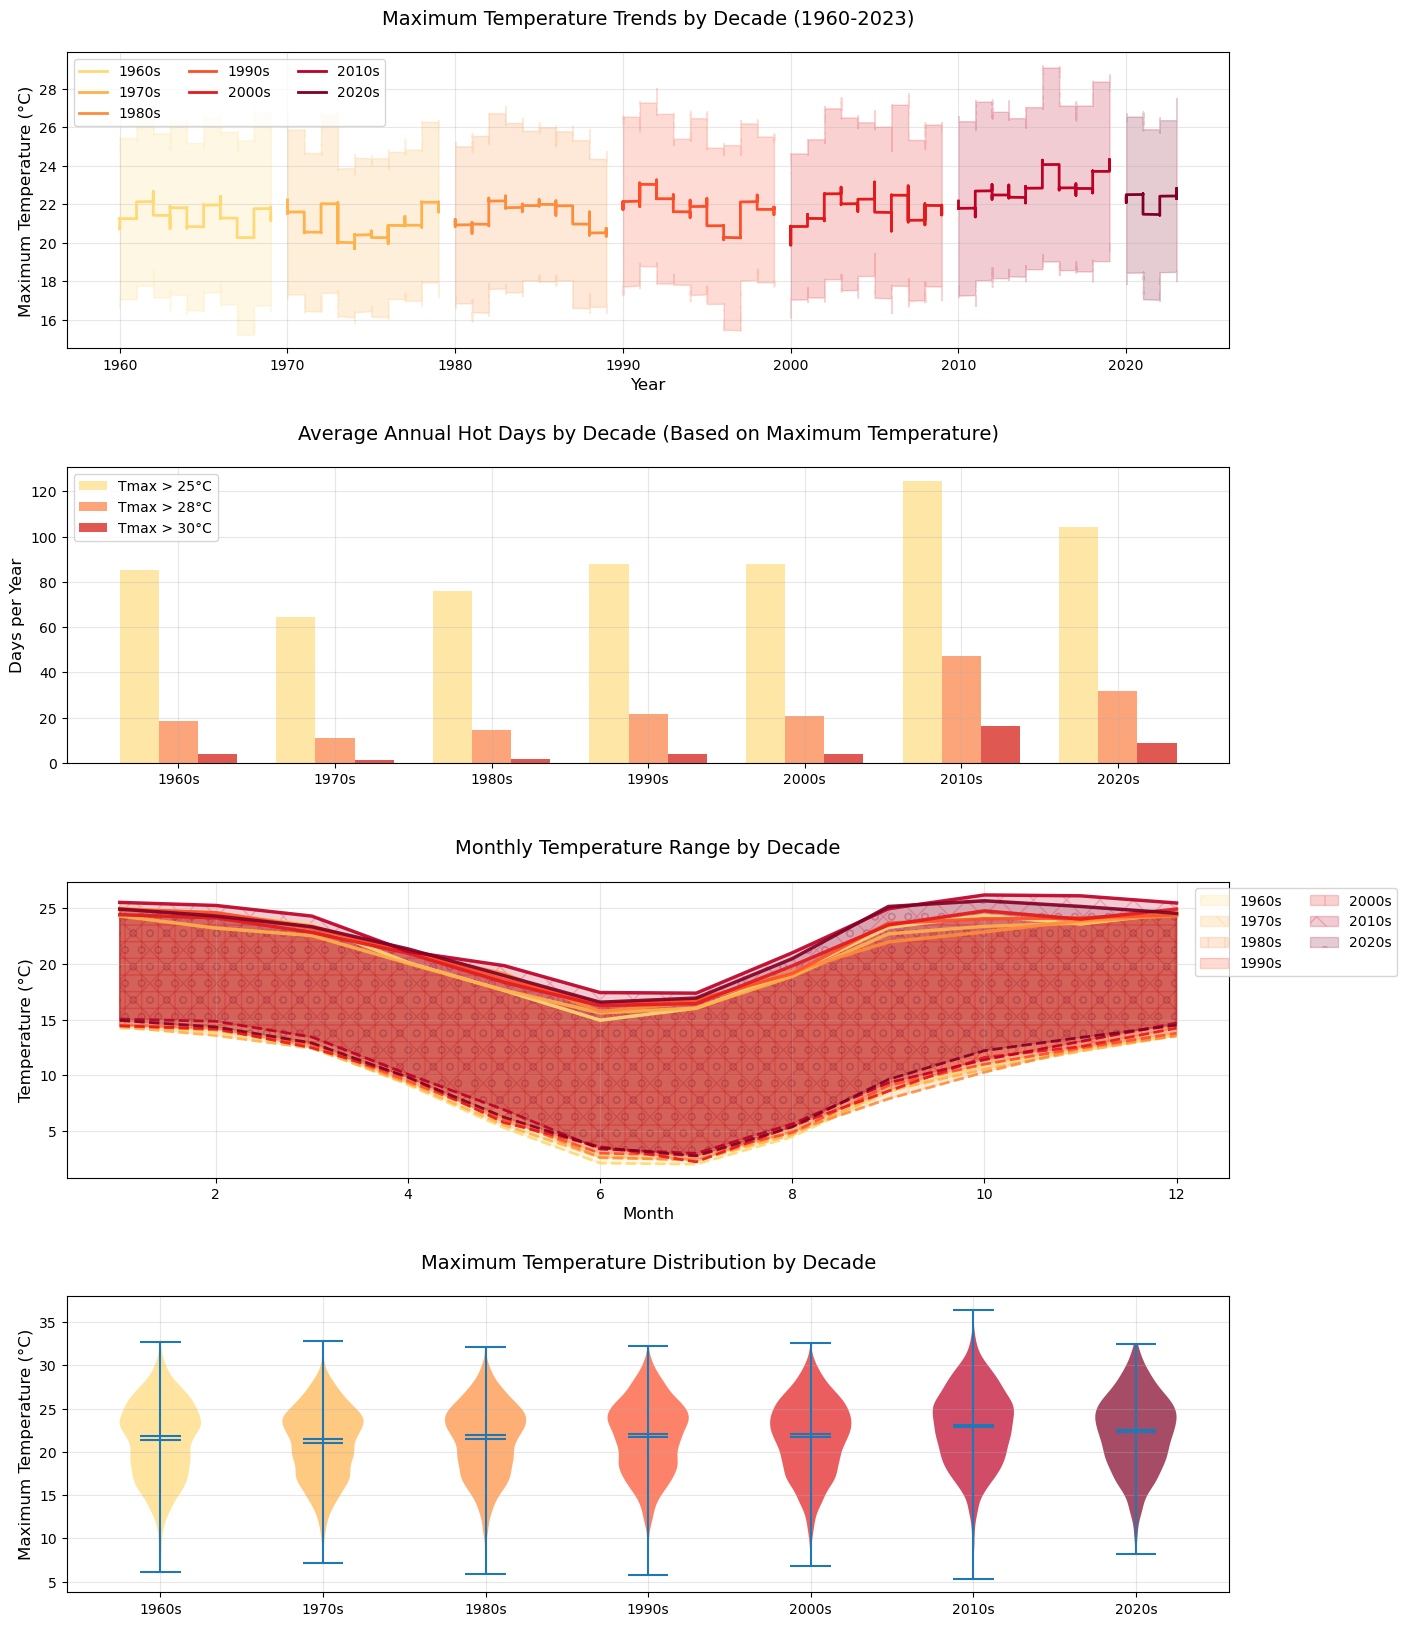


Decadal Temperature Statistics:
         tmax                   
         mean   std   min    max
decade                          
1960    21.35  4.50  6.15  32.67
1970    21.01  4.18  7.21  32.81
1980    21.44  4.19  5.85  32.17
1990    21.71  4.27  5.78  32.18
2000    21.67  4.33  6.81  32.61
2010    22.84  4.50  5.33  36.44
2020    22.24  4.37  8.21  32.52


: 

: 

In [28]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Initialize Earth Engine
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

class JohannesburgClimateAnalyzer:
    def __init__(self, latitude=-26.2041, longitude=28.0473):
        self.latitude = latitude
        self.longitude = longitude
        self.point = ee.Geometry.Point([longitude, latitude])
        
    def get_climate_data_chunked(self, start_year=1960, end_year=2023, chunk_size=2):
        """Retrieve climate data in smaller chunks to avoid timeout"""
        all_data = []
        
        for year in range(start_year, end_year + 1, chunk_size):
            chunk_end = min(year + chunk_size, end_year + 1)
            print(f"Processing years {year}-{chunk_end-1}...")
            
            try:
                start_date = f'{year}-01-01'
                end_date = f'{chunk_end}-01-01'
                
                era5_data = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
                    .filterDate(start_date, end_date) \
                    .filterBounds(self.point) \
                    .select([
                        'temperature_2m_max',
                        'temperature_2m_min',
                        'temperature_2m',
                        'dewpoint_temperature_2m',
                        'total_precipitation_sum'
                    ])
                
                def extract_data(image):
                    data = image.reduceRegion(
                        reducer=ee.Reducer.mean(),
                        geometry=self.point,
                        scale=11132
                    )
                    return ee.Feature(None, {
                        'date': image.date().format('YYYY-MM-dd'),
                        'tmax': data.get('temperature_2m_max'),
                        'tmin': data.get('temperature_2m_min'),
                        'tmean': data.get('temperature_2m'),
                        'dewpoint': data.get('dewpoint_temperature_2m'),
                        'precipitation': data.get('total_precipitation_sum')
                    })
                
                features = era5_data.map(extract_data)
                chunk_data = features.getInfo()
                
                if chunk_data and 'features' in chunk_data:
                    chunk_df = pd.DataFrame([
                        {
                            'date': datetime.strptime(f['properties']['date'], '%Y-%m-%d'),
                            'tmax': f['properties']['tmax'] - 273.15,
                            'tmin': f['properties']['tmin'] - 273.15,
                            'tmean': f['properties']['tmean'] - 273.15,
                            'dewpoint': f['properties']['dewpoint'] - 273.15,
                            'precipitation': f['properties'].get('precipitation', 0)
                        }
                        for f in chunk_data['features']
                    ])
                    all_data.append(chunk_df)
                
            except Exception as e:
                print(f"Error processing years {year}-{chunk_end-1}: {str(e)}")
                continue
        
        if not all_data:
            return pd.DataFrame()
            
        df = pd.concat(all_data, ignore_index=True)
        df = df.sort_values('date')
        df['decade'] = (df['date'].dt.year // 10) * 10
        
        return df

def plot_improved_temperature_trends(df):
    """Create enhanced visualization with improved color scheme and thresholds"""
    if df.empty:
        print("No data to plot")
        return None
    
    fig = plt.figure(figsize=(15, 20))
    gs = fig.add_gridspec(4, 1, height_ratios=[1, 1, 1, 1], hspace=0.4)
    
    # Create custom colormap for better decade distinction
    colors = ['#FED976', '#FEB24C', '#FD8D3C', '#FC4E2A', '#E31A1C', '#BD0026', '#800026']
    decades = sorted(df['decade'].unique())
    
    # 1. Long-term Temperature Trends (Tmax)
    ax1 = fig.add_subplot(gs[0])
    
    for i, decade in enumerate(decades):
        decade_data = df[df['decade'] == decade]
        years = decade_data['date'].dt.year
        temps = decade_data['tmax']
        
        ax1.fill_between(years, 
                        temps.rolling(365, center=True).mean() - temps.rolling(365, center=True).std(),
                        temps.rolling(365, center=True).mean() + temps.rolling(365, center=True).std(),
                        alpha=0.2, color=colors[i])
        ax1.plot(years, temps.rolling(365, center=True).mean(), 
                color=colors[i], label=f'{decade}s', linewidth=2)
    
    ax1.set_title('Maximum Temperature Trends by Decade (1960-2023)', fontsize=14, pad=20)
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Maximum Temperature (°C)', fontsize=12)
    ax1.legend(ncol=3, loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # 2. Hot Days Analysis
    ax2 = fig.add_subplot(gs[1])
    
    thresholds = [25, 28, 30]  # Adjusted thresholds
    width = 0.25
    x = np.arange(len(decades))
    bar_colors = ['#FEE090', '#FC8D59', '#D73027']
    
    for i, threshold in enumerate(thresholds):
        counts = []
        for decade in decades:
            decade_data = df[df['decade'] == decade]
            count = (decade_data['tmax'] > threshold).sum() / len(decade_data) * 365
            counts.append(count)
        
        ax2.bar(x + i*width, counts, width, 
               label=f'Tmax > {threshold}°C',
               color=bar_colors[i],
               alpha=0.8)
    
    ax2.set_title('Average Annual Hot Days by Decade (Based on Maximum Temperature)', 
                 fontsize=14, pad=20)
    ax2.set_xticks(x + width)
    ax2.set_xticklabels([f'{d}s' for d in decades])
    ax2.set_ylabel('Days per Year', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Temperature Range
    ax3 = fig.add_subplot(gs[2])
    
    hatches = ['/', '\\', '|', '-', '+', 'x', 'o']
    
    for i, (decade, color) in enumerate(zip(decades, colors)):
        decade_data = df[df['decade'] == decade]
        monthly_max = decade_data.groupby(decade_data['date'].dt.month)['tmax'].mean()
        monthly_min = decade_data.groupby(decade_data['date'].dt.month)['tmin'].mean()
        
        ax3.fill_between(monthly_max.index, monthly_min, monthly_max,
                        alpha=0.2, color=color, 
                        hatch=hatches[i], label=f'{decade}s')
        ax3.plot(monthly_max.index, monthly_max, color=color, 
                linestyle='-', linewidth=2.5, alpha=0.9)
        ax3.plot(monthly_min.index, monthly_min, color=color, 
                linestyle='--', linewidth=2, alpha=0.9)
    
    ax3.set_title('Monthly Temperature Range by Decade', fontsize=14, pad=20)
    ax3.set_xlabel('Month', fontsize=12)
    ax3.set_ylabel('Temperature (°C)', fontsize=12)
    ax3.legend(ncol=2, loc='upper right', bbox_to_anchor=(1.15, 1))
    ax3.grid(True, alpha=0.3)
    
    # 4. Maximum Temperature Distribution
    ax4 = fig.add_subplot(gs[3])
    
    violin_parts = ax4.violinplot([df[df['decade'] == decade]['tmax'] for decade in decades],
                                showmeans=True, showmedians=True)
    
    for i, pc in enumerate(violin_parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)
    
    ax4.set_title('Maximum Temperature Distribution by Decade', fontsize=14, pad=20)
    ax4.set_xticks(range(1, len(decades) + 1))
    ax4.set_xticklabels([f'{d}s' for d in decades])
    ax4.set_ylabel('Maximum Temperature (°C)', fontsize=12)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Create analyzer and get data
analyzer = JohannesburgClimateAnalyzer()
print("Retrieving climate data...")
climate_data = analyzer.get_climate_data_chunked(start_year=1960, end_year=2023)

# Create and show visualization
if not climate_data.empty:
    print("Creating visualization...")
    fig = plot_improved_temperature_trends(climate_data)
    plt.show()
    
    # Print some summary statistics
    print("\nDecadal Temperature Statistics:")
    decadal_stats = climate_data.groupby('decade').agg({
        'tmax': ['mean', 'std', 'min', 'max']
    }).round(2)
    print(decadal_stats)

In [29]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def animate_hot_days(df):
    """Animate hot days visualization with full time range"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Calculate year range
    start_year = df['date'].dt.year.min()
    end_year = df['date'].dt.year.max()
    total_years = end_year - start_year + 1
    
    decades = sorted(df['decade'].unique())
    thresholds = [25, 28, 30]
    bar_colors = ['#FEE090', '#FC8D59', '#D73027']
    width = 0.25
    x = np.arange(len(decades))
    
    def update(frame):
        ax.clear()
        # Calculate current year based on frame
        current_year = start_year + int((frame / 50) * total_years)
        
        for i, threshold in enumerate(thresholds):
            counts = []
            for decade in decades:
                decade_data = df[(df['decade'] == decade) & (df['date'].dt.year <= current_year)]
                if not decade_data.empty:
                    # Calculate annual average for the decade
                    days_in_decade = len(decade_data)
                    hot_days = (decade_data['tmax'] > threshold).sum()
                    annual_average = (hot_days / days_in_decade) * 365.25
                    counts.append(annual_average)
                else:
                    counts.append(0)
            
            ax.bar(x + i*width, counts, width,
                  label=f'Tmax > {threshold}°C',
                  color=bar_colors[i],
                  alpha=0.8)
        
        ax.set_title(f'Average Annual Hot Days by Decade (Through {current_year})')
        ax.set_xticks(x + width)
        ax.set_xticklabels([f'{d}s' for d in decades])
        ax.set_ylabel('Days per Year')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 250)  # Adjusted based on your data
        
    # 50 frames, 300ms interval for smooth progression
    anim = animation.FuncAnimation(fig, update, frames=50, interval=300)
    return anim

def save_animations(df):
    """Save animations with consistent settings"""
    print("Creating hot days animation...")
    anim = animate_hot_days(df)
    anim.save('hot_days.gif', writer='pillow', fps=4)  # Slower fps for clarity
    
    plt.close('all')  # Clean up

# To run directly:
"""
anim = animate_hot_days(climate_data)
plt.show()
"""

# Or to save:
save_animations(climate_data)

2024-12-19 17:19:36,610 - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


Creating hot days animation...


: 

: 

c:\Users\CraigParker\anaconda3\Lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


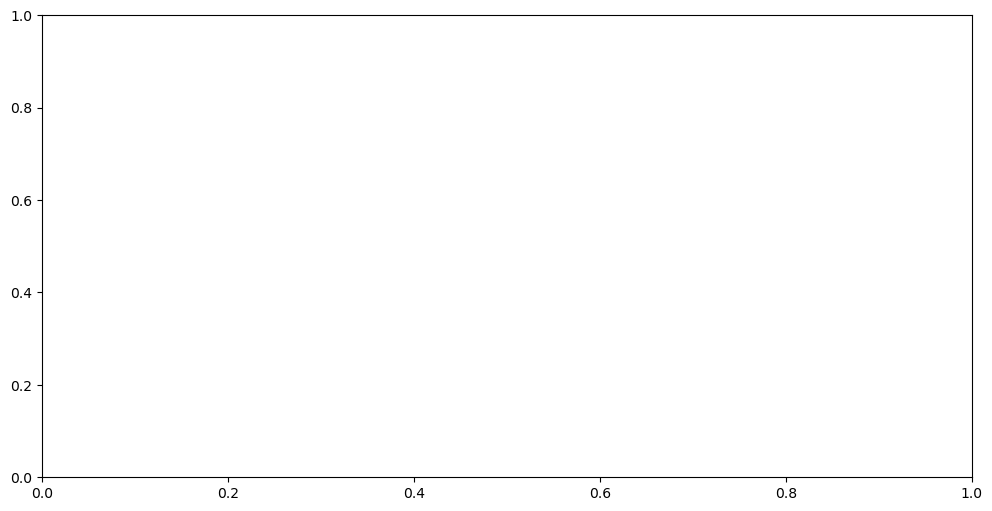

2024-12-18 09:23:52,774 - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


Creating temperature trend animation...


2024-12-18 09:23:56,260 - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


Creating hot days animation...


: 

: 

In [26]:
# To display an animation in the notebook:
anim = animate_temperature_trend(climate_data)
plt.show()

# Or save them all as GIFs:
save_animations(climate_data)

In [33]:
# In your Python code:
analyzer = JohannesburgClimateAnalyzer()
climate_data = analyzer.get_climate_data_chunked()

# Process data for the two periods
period1 = climate_data[(climate_data['date'].dt.year >= 1985) & 
                      (climate_data['date'].dt.year <= 1995)]
period2 = climate_data[(climate_data['date'].dt.year >= 2015) & 
                      (climate_data['date'].dt.year <= 2024)]

# Create monthly distributions
monthly_data = []

for month in range(1, 13):
    # Get data for each period and month
    p1_month = period1[period1['date'].dt.month == month]['tmax']
    p2_month = period2[period2['date'].dt.month == month]['tmax']
    
    monthly_data.append({
        'month': month,
        'period1_temps': p1_month.tolist(),
        'period2_temps': p2_month.tolist()
    })

Processing years 1960-1961...
Processing years 1962-1963...
Processing years 1964-1965...
Processing years 1966-1967...
Processing years 1968-1969...
Processing years 1970-1971...
Processing years 1972-1973...
Processing years 1974-1975...
Processing years 1976-1977...
Processing years 1978-1979...
Processing years 1980-1981...
Processing years 1982-1983...
Processing years 1984-1985...
Processing years 1986-1987...
Processing years 1988-1989...
Processing years 1990-1991...
Processing years 1992-1993...
Processing years 1994-1995...
Processing years 1996-1997...
Processing years 1998-1999...
Processing years 2000-2001...
Processing years 2002-2003...
Processing years 2004-2005...
Processing years 2006-2007...
Processing years 2008-2009...
Processing years 2010-2011...
Processing years 2012-2013...
Processing years 2014-2015...
Processing years 2016-2017...
Processing years 2018-2019...
Processing years 2020-2021...
Processing years 2022-2023...


: 

: 

In [35]:
class JohannesburgClimateAnalyzer:
    def __init__(self, latitude=-26.2041, longitude=28.0473):
        self.latitude = latitude
        self.longitude = longitude
        self.point = ee.Geometry.Point([longitude, latitude])

    def get_climate_data_chunked(self, start_year=1960, end_year=2023, chunk_size=2):
        all_data = []
        
        for year in range(start_year, end_year + 1, chunk_size):
            chunk_end = min(year + chunk_size, end_year + 1)
            print(f"Processing years {year}-{chunk_end-1}...")
            
            try:
                start_date = f'{year}-01-01'
                end_date = f'{chunk_end}-01-01'
                
                era5_data = (ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
                            .filterDate(start_date, end_date)
                            .filterBounds(self.point)
                            .select([
                                'temperature_2m_max',
                                'temperature_2m_min',
                                'temperature_2m',
                                'dewpoint_temperature_2m',
                                'total_precipitation_sum'
                            ]))
                
                def extract_data(image):
                    data = image.reduceRegion(
                        reducer=ee.Reducer.mean(),
                        geometry=self.point,
                        scale=11132
                    )
                    return ee.Feature(None, {
                        'date': image.date().format('YYYY-MM-dd'),
                        'tmax': data.get('temperature_2m_max'),
                        'tmin': data.get('temperature_2m_min'),
                        'tmean': data.get('temperature_2m'),
                        'dewpoint': data.get('dewpoint_temperature_2m'),
                        'precipitation': data.get('total_precipitation_sum')
                    })
                
                features = era5_data.map(extract_data)
                chunk_data = features.getInfo()
                
                if chunk_data and 'features' in chunk_data:
                    chunk_df = pd.DataFrame([{
                        'date': datetime.strptime(f['properties']['date'], '%Y-%m-%d'),
                        'tmax': f['properties']['tmax'] - 273.15,
                        'tmin': f['properties']['tmin'] - 273.15,
                        'tmean': f['properties']['tmean'] - 273.15,
                        'dewpoint': f['properties']['dewpoint'] - 273.15,
                        'precipitation': f['properties'].get('precipitation', 0)
                    } for f in chunk_data['features']])
                    all_data.append(chunk_df)
                
            except Exception as e:
                print(f"Error processing years {year}-{chunk_end-1}: {str(e)}")
                continue
        
        if not all_data:
            return pd.DataFrame()
            
        df = pd.concat(all_data, ignore_index=True)
        df = df.sort_values('date')
        return df

def main():
    try:
        ee.Initialize()
        analyzer = JohannesburgClimateAnalyzer()
        
        # Get climate data
        print("Retrieving climate data...")
        climate_data = analyzer.get_climate_data_chunked()

        if not climate_data.empty:
            # Process data for the two periods
            period1 = climate_data[(climate_data['date'].dt.year >= 1985) & 
                                 (climate_data['date'].dt.year <= 1995)]
            period2 = climate_data[(climate_data['date'].dt.year >= 2015) & 
                                 (climate_data['date'].dt.year <= 2024)]

            # Create monthly distributions
            monthly_data = []
            for month in range(1, 13):
                # Get data for each period and month
                p1_month = period1[period1['date'].dt.month == month]['tmax']
                p2_month = period2[period2['date'].dt.month == month]['tmax']
                
                monthly_data.append({
                    'month': month,
                    'period1_temps': p1_month.tolist(),
                    'period2_temps': p2_month.tolist()
                })
            
            print("Data processing complete")
            return monthly_data
        else:
            print("Error: Failed to retrieve climate data")
            
    except Exception as e:
        print(f"Error in analysis: {str(e)}")

if __name__ == "__main__":
    main()

Retrieving climate data...
Processing years 1960-1961...
Processing years 1962-1963...
Processing years 1964-1965...
Processing years 1966-1967...
Processing years 1968-1969...
Processing years 1970-1971...
Processing years 1972-1973...
Processing years 1974-1975...
Processing years 1976-1977...
Processing years 1978-1979...
Processing years 1980-1981...
Processing years 1982-1983...
Processing years 1984-1985...
Processing years 1986-1987...
Processing years 1988-1989...
Processing years 1990-1991...
Processing years 1992-1993...
Processing years 1994-1995...
Processing years 1996-1997...
Processing years 1998-1999...
Processing years 2000-2001...
Processing years 2002-2003...
Processing years 2004-2005...
Processing years 2006-2007...
Processing years 2008-2009...
Processing years 2010-2011...
Processing years 2012-2013...
Processing years 2014-2015...
Processing years 2016-2017...
Processing years 2018-2019...
Processing years 2020-2021...
Processing years 2022-2023...
Data processi

: 

: 

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

def create_ridge_plot(climate_data):
    # Set the style
    plt.style.use('seaborn')
    sns.set_palette("husl")
    
    # Filter data for the two periods
    period1 = climate_data[(climate_data['date'].dt.year >= 1985) & 
                          (climate_data['date'].dt.year <= 1995)]
    period2 = climate_data[(climate_data['date'].dt.year >= 2015) & 
                          (climate_data['date'].dt.year <= 2024)]

    # Create figure
    fig, axes = plt.subplots(12, 1, figsize=(12, 20), sharex=True)
    fig.suptitle('Temperature Distribution: 1985-1995 vs 2015-2024', y=0.95)
    plt.subplots_adjust(hspace=0)

    # Temperature range for KDE
    temp_range = np.linspace(15, 40, 200)
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Plot each month
    for month_num in range(12):
        ax = axes[month_num]
        
        # Get data for each period for this month
        month_data1 = period1[period1['date'].dt.month == month_num + 1]['tmax'].dropna()
        month_data2 = period2[period2['date'].dt.month == month_num + 1]['tmax'].dropna()
        
        # Calculate KDE for each period
        if len(month_data1) > 1:
            kde1 = stats.gaussian_kde(month_data1)
            density1 = kde1(temp_range)
            ax.fill_between(temp_range, density1, alpha=0.5, color='#69b3a2', 
                          label='1985-1995')
        
        if len(month_data2) > 1:
            kde2 = stats.gaussian_kde(month_data2)
            density2 = kde2(temp_range)
            ax.fill_between(temp_range, density2, alpha=0.5, color='#ff7f50', 
                          label='2015-2024')
        
        # Customize each subplot
        ax.set_ylabel(months[month_num], rotation=0, ha='right', va='center')
        ax.set_ylim(bottom=0)
        ax.set_xlim(15, 40)
        
        # Remove most of the spines and ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.tick_params(left=False)
        
        # Only show x-axis labels for bottom plot
        if month_num != 11:
            ax.set_xticks([])
        
        # Add legend to top subplot
        if month_num == 0:
            ax.legend()

    # Add x-label to bottom subplot
    axes[-1].set_xlabel('Temperature (°C)')
    
    return fig

def main():
    try:
        # Initialize and get climate data
        analyzer = JohannesburgClimateAnalyzer()
        climate_data = analyzer.get_climate_data_chunked()
        
        if not climate_data.empty:
            # Create and save the ridge plot
            fig = create_ridge_plot(climate_data)
            plt.savefig('temperature_ridges.png', dpi=300, bbox_inches='tight')
            plt.close()
            
            print("Ridge plot has been saved as 'temperature_ridges.png'")
            
            # Calculate and print summary statistics
            print("\nSummary of Temperature Changes:")
            for month in range(1, 13):
                period1 = climate_data[
                    (climate_data['date'].dt.year >= 1985) & 
                    (climate_data['date'].dt.year <= 1995) &
                    (climate_data['date'].dt.month == month)
                ]['tmax']
                
                period2 = climate_data[
                    (climate_data['date'].dt.year >= 2015) & 
                    (climate_data['date'].dt.year <= 2024) &
                    (climate_data['date'].dt.month == month)
                ]['tmax']
                
                print(f"\nMonth {month}:")
                print(f"1985-1995 mean: {period1.mean():.1f}°C")
                print(f"2015-2024 mean: {period2.mean():.1f}°C")
                print(f"Change: {period2.mean() - period1.mean():+.1f}°C")
        
        else:
            print("Error: No climate data available")
            
    except Exception as e:
        print(f"Error creating visualization: {str(e)}")

if __name__ == "__main__":
    main()

Processing years 1960-1961...
Processing years 1962-1963...
Processing years 1964-1965...
Processing years 1966-1967...
Processing years 1968-1969...
Processing years 1970-1971...
Processing years 1972-1973...
Processing years 1974-1975...
Processing years 1976-1977...
Processing years 1978-1979...
Processing years 1980-1981...
Processing years 1982-1983...
Processing years 1984-1985...
Processing years 1986-1987...
Processing years 1988-1989...
Processing years 1990-1991...
Processing years 1992-1993...
Processing years 1994-1995...
Processing years 1996-1997...
Processing years 1998-1999...
Processing years 2000-2001...
Processing years 2002-2003...
Processing years 2004-2005...
Processing years 2006-2007...
Processing years 2008-2009...
Processing years 2010-2011...
Processing years 2012-2013...
Processing years 2014-2015...
Processing years 2016-2017...
Processing years 2018-2019...
Processing years 2020-2021...
Processing years 2022-2023...
Error creating visualization: 'seaborn' 

: 

: 

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

def create_ridge_plot(climate_data):
    # Use a clean style
    plt.style.use('default')
    
    # Filter data for the two periods
    period1 = climate_data[(climate_data['date'].dt.year >= 1985) & 
                          (climate_data['date'].dt.year <= 1995)]
    period2 = climate_data[(climate_data['date'].dt.year >= 2015) & 
                          (climate_data['date'].dt.year <= 2024)]

    # Create figure
    fig, axes = plt.subplots(12, 1, figsize=(12, 20), sharex=True)
    fig.suptitle('Temperature Distribution: 1985-1995 vs 2015-2024', y=0.95, fontsize=14)
    plt.subplots_adjust(hspace=0)

    # Temperature range for KDE
    temp_range = np.linspace(15, 40, 200)
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Store statistics for later reporting
    stats_data = []

    # Plot each month
    for month_num in range(12):
        ax = axes[month_num]
        
        # Get data for each period for this month
        month_data1 = period1[period1['date'].dt.month == month_num + 1]['tmax'].dropna()
        month_data2 = period2[period2['date'].dt.month == month_num + 1]['tmax'].dropna()
        
        # Store statistics
        stats_data.append({
            'month': months[month_num],
            'period1_mean': month_data1.mean(),
            'period2_mean': month_data2.mean(),
            'change': month_data2.mean() - month_data1.mean()
        })
        
        # Calculate KDE for each period
        if len(month_data1) > 1:
            kde1 = stats.gaussian_kde(month_data1)
            density1 = kde1(temp_range)
            ax.fill_between(temp_range, density1, alpha=0.5, color='#69b3a2', 
                          label='1985-1995')
        
        if len(month_data2) > 1:
            kde2 = stats.gaussian_kde(month_data2)
            density2 = kde2(temp_range)
            ax.fill_between(temp_range, density2, alpha=0.5, color='#ff7f50', 
                          label='2015-2024')
        
        # Customize each subplot
        ax.set_ylabel(months[month_num], rotation=0, ha='right', va='center')
        ax.set_ylim(bottom=0)
        ax.set_xlim(15, 40)
        
        # Remove most of the spines and ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.tick_params(left=False)
        
        # Only show x-axis labels for bottom plot
        if month_num != 11:
            ax.set_xticks([])
        
        # Add legend to top subplot
        if month_num == 0:
            ax.legend(loc='upper right')

    # Add x-label to bottom subplot
    axes[-1].set_xlabel('Temperature (°C)')
    
    return fig, stats_data

def main():
    try:
        # Initialize and get climate data
        analyzer = JohannesburgClimateAnalyzer()
        climate_data = analyzer.get_climate_data_chunked()
        
        if not climate_data.empty:
            # Create and save the ridge plot
            fig, stats_data = create_ridge_plot(climate_data)
            plt.savefig('temperature_ridges.png', dpi=300, bbox_inches='tight')
            plt.close()
            
            print("Ridge plot has been saved as 'temperature_ridges.png'")
            
            # Print summary statistics
            print("\nSummary of Temperature Changes:")
            print("-" * 50)
            print(f"{'Month':<6} {'1985-1995':>10} {'2015-2024':>10} {'Change':>10}")
            print("-" * 50)
            
            for stat in stats_data:
                print(f"{stat['month']:<6} {stat['period1_mean']:10.1f} "
                      f"{stat['period2_mean']:10.1f} {stat['change']:+10.1f}")
            
            print("-" * 50)
            # Calculate and print overall average change
            avg_change = np.mean([s['change'] for s in stats_data])
            print(f"Average temperature change: {avg_change:+.1f}°C")
        
        else:
            print("Error: No climate data available")
            
    except Exception as e:
        print(f"Error creating visualization: {str(e)}")

if __name__ == "__main__":
    main()

Processing years 1960-1961...
Processing years 1962-1963...
Processing years 1964-1965...
Processing years 1966-1967...
Processing years 1968-1969...
Processing years 1970-1971...
Processing years 1972-1973...
Processing years 1974-1975...
Processing years 1976-1977...
Processing years 1978-1979...
Processing years 1980-1981...
Processing years 1982-1983...
Processing years 1984-1985...
Processing years 1986-1987...
Processing years 1988-1989...
Processing years 1990-1991...
Processing years 1992-1993...
Processing years 1994-1995...
Processing years 1996-1997...
Processing years 1998-1999...
Processing years 2000-2001...
Processing years 2002-2003...
Processing years 2004-2005...
Processing years 2006-2007...
Processing years 2008-2009...
Processing years 2010-2011...
Processing years 2012-2013...
Processing years 2014-2015...
Processing years 2016-2017...
Processing years 2018-2019...
Processing years 2020-2021...
Processing years 2022-2023...
Ridge plot has been saved as 'temperatur

: 

: 

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap

def create_nyt_style_plot(climate_data):
    # Create figure
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(12, 16))
    
    # Filter data for the two periods
    period1 = climate_data[(climate_data['date'].dt.year >= 1985) & 
                          (climate_data['date'].dt.year <= 1995)]
    period2 = climate_data[(climate_data['date'].dt.year >= 2015) & 
                          (climate_data['date'].dt.year <= 2024)]

    # Custom color scheme inspired by NYT
    colors = {
        'past': '#a8d5e2',     # Light blue
        'present': '#fb9f89'   # Coral
    }
    
    # Temperature range for KDE
    temp_range = np.linspace(15, 40, 200)
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Plot settings
    spacing = 0.15  # Vertical spacing between months
    current_y = 0
    
    # Store the max density for scaling
    max_density = 0
    
    # First pass to get max density for scaling
    for month_num in range(12):
        month_data1 = period1[period1['date'].dt.month == month_num + 1]['tmax'].dropna()
        month_data2 = period2[period2['date'].dt.month == month_num + 1]['tmax'].dropna()
        
        if len(month_data1) > 1:
            kde1 = stats.gaussian_kde(month_data1, bw_method=0.3)
            density1 = kde1(temp_range)
            max_density = max(max_density, np.max(density1))
        
        if len(month_data2) > 1:
            kde2 = stats.gaussian_kde(month_data2, bw_method=0.3)
            density2 = kde2(temp_range)
            max_density = max(max_density, np.max(density2))
    
    # Plot each month
    for month_num in range(12):
        month_data1 = period1[period1['date'].dt.month == month_num + 1]['tmax'].dropna()
        month_data2 = period2[period2['date'].dt.month == month_num + 1]['tmax'].dropna()
        
        # Plot filled distributions
        if len(month_data1) > 1:
            kde1 = stats.gaussian_kde(month_data1, bw_method=0.3)
            density1 = kde1(temp_range)
            scaled_density1 = density1 / max_density * spacing
            ax.fill_between(temp_range, current_y, current_y + scaled_density1, 
                          color=colors['past'], alpha=0.7, zorder=2)
        
        if len(month_data2) > 1:
            kde2 = stats.gaussian_kde(month_data2, bw_method=0.3)
            density2 = kde2(temp_range)
            scaled_density2 = density2 / max_density * spacing
            ax.fill_between(temp_range, current_y, current_y + scaled_density2, 
                          color=colors['present'], alpha=0.7, zorder=1)
        
        # Add month label
        ax.text(14, current_y + spacing/2, months[month_num], 
                ha='right', va='center', fontsize=10)
        
        current_y += spacing

    # Customize the plot
    ax.set_xlim(15, 40)
    ax.set_ylim(-spacing/2, current_y + spacing/2)
    
    # Set title and labels
    plt.title('Temperature Distribution: 1985-1995 vs 2015-2024', 
              y=1.02, fontsize=14, fontweight='bold')
    plt.xlabel('Temperature (°C)', fontsize=12)
    
    # Remove y-axis ticks and labels
    ax.set_yticks([])
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=colors['past'], alpha=0.7, label='1985-1995'),
        Patch(facecolor=colors['present'], alpha=0.7, label='2015-2024')
    ]
    ax.legend(handles=legend_elements, loc='upper right', 
             bbox_to_anchor=(1.15, 1), fontsize=10)
    
    # Customize grid
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.tight_layout()
    
    return fig

def main():
    try:
        # Initialize and get climate data
        analyzer = JohannesburgClimateAnalyzer()
        climate_data = analyzer.get_climate_data_chunked()
        
        if not climate_data.empty:
            # Create and save the plot
            fig = create_nyt_style_plot(climate_data)
            plt.savefig('temperature_distribution_nyt.png', dpi=300, bbox_inches='tight')
            plt.close()
            
            print("NYT-style plot has been saved as 'temperature_distribution_nyt.png'")
            
    except Exception as e:
        print(f"Error creating visualization: {str(e)}")

if __name__ == "__main__":
    main()

Processing years 1960-1961...
Processing years 1962-1963...
Processing years 1964-1965...
Processing years 1966-1967...
Processing years 1968-1969...
Processing years 1970-1971...
Processing years 1972-1973...
Processing years 1974-1975...
Processing years 1976-1977...
Processing years 1978-1979...
Processing years 1980-1981...
Processing years 1982-1983...
Processing years 1984-1985...
Processing years 1986-1987...
Processing years 1988-1989...
Processing years 1990-1991...
Processing years 1992-1993...
Processing years 1994-1995...
Processing years 1996-1997...
Processing years 1998-1999...
Processing years 2000-2001...
Processing years 2002-2003...
Processing years 2004-2005...
Processing years 2006-2007...
Processing years 2008-2009...
Processing years 2010-2011...
Processing years 2012-2013...
Processing years 2014-2015...
Processing years 2016-2017...
Processing years 2018-2019...
Processing years 2020-2021...
Processing years 2022-2023...
NYT-style plot has been saved as 'temper

: 

: 

Processing years 1960-1961...
Processing years 1962-1963...
Processing years 1964-1965...
Processing years 1966-1967...
Processing years 1968-1969...
Processing years 1970-1971...
Processing years 1972-1973...
Processing years 1974-1975...
Processing years 1976-1977...
Processing years 1978-1979...
Processing years 1980-1981...
Processing years 1982-1983...
Processing years 1984-1985...
Processing years 1986-1987...
Processing years 1988-1989...
Processing years 1990-1991...
Processing years 1992-1993...
Processing years 1994-1995...
Processing years 1996-1997...
Processing years 1998-1999...
Processing years 2000-2001...
Processing years 2002-2003...
Processing years 2004-2005...
Processing years 2006-2007...
Processing years 2008-2009...
Processing years 2010-2011...
Processing years 2012-2013...
Processing years 2014-2015...
Processing years 2016-2017...
Processing years 2018-2019...
Processing years 2020-2021...
Processing years 2022-2023...


2024-12-19 17:51:46,298 - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


Animation has been saved as 'temperature_distribution_animated.gif'


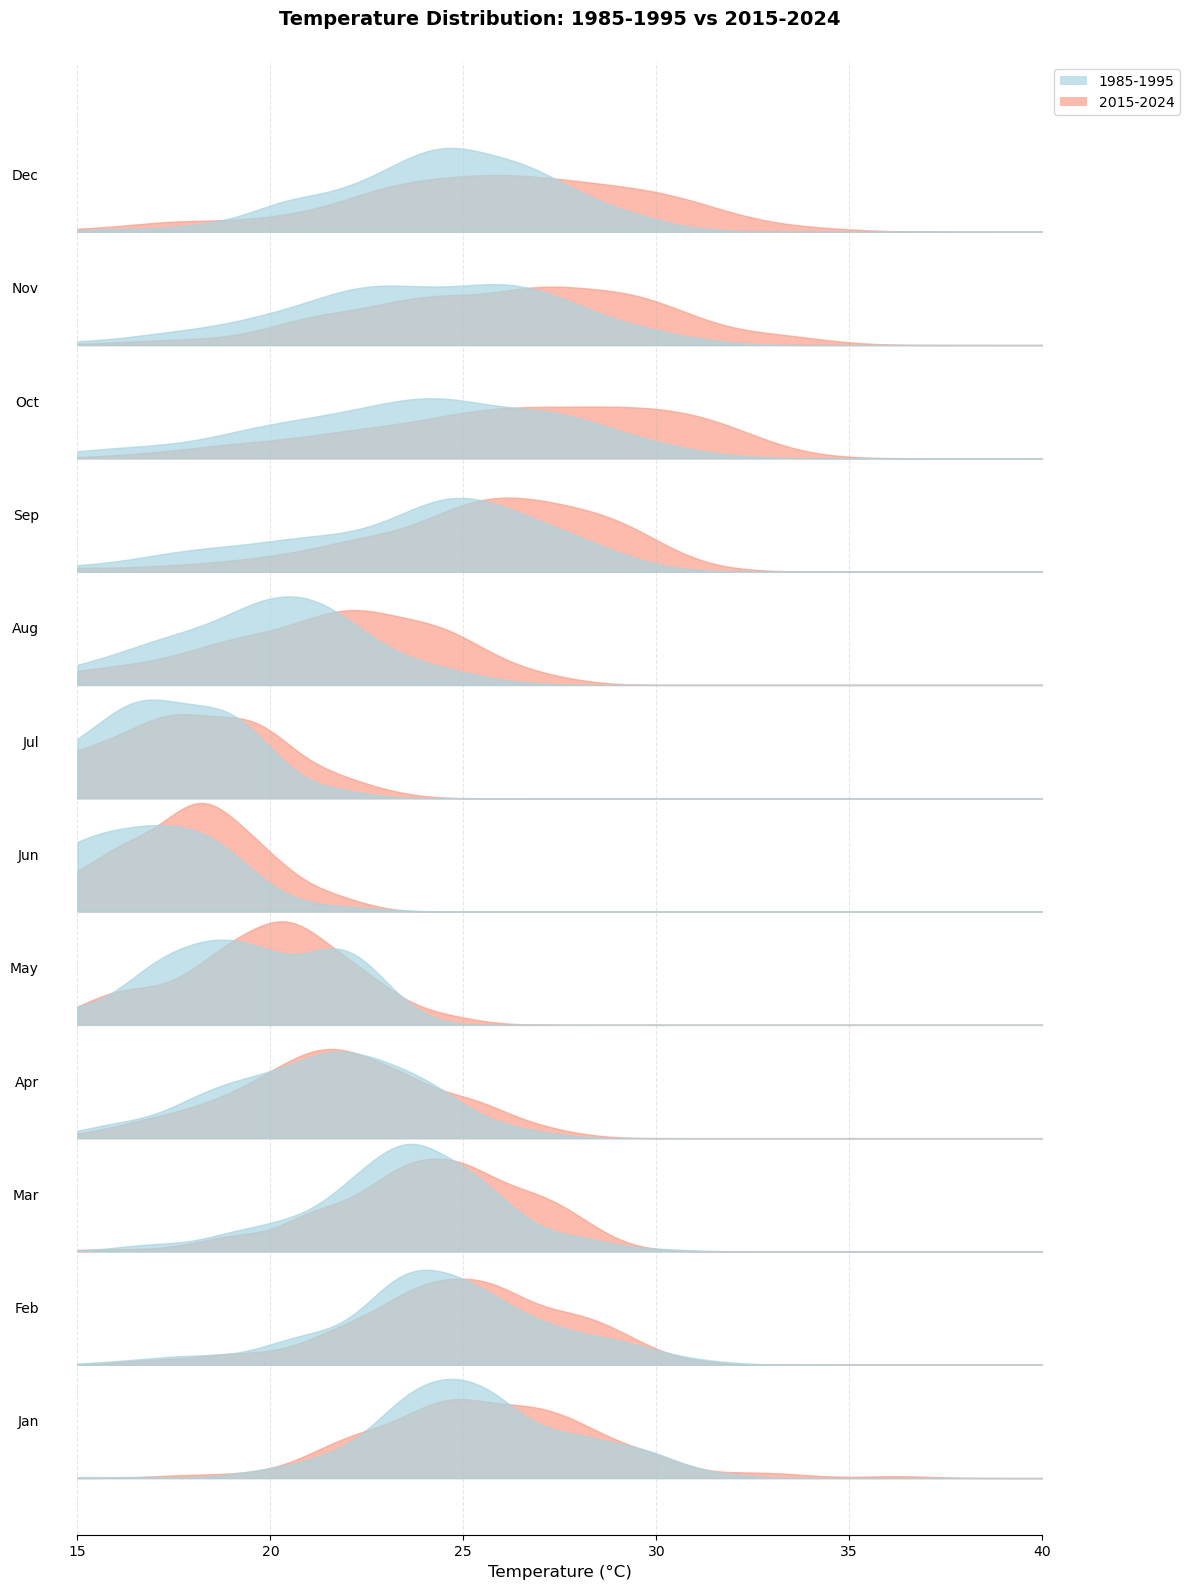

: 

: 

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.animation as animation

def create_animated_distribution(climate_data):
    # Set up the figure
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(12, 16))
    
    # Filter data for the two periods
    period1 = climate_data[(climate_data['date'].dt.year >= 1985) & 
                          (climate_data['date'].dt.year <= 1995)]
    period2 = climate_data[(climate_data['date'].dt.year >= 2015) & 
                          (climate_data['date'].dt.year <= 2024)]
    
    # Colors
    colors = {
        'past': '#a8d5e2',    # Light blue
        'present': '#fb9f89'  # Coral
    }
    
    # Temperature range for KDE
    temp_range = np.linspace(15, 40, 200)
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Animation settings
    spacing = 0.15
    n_frames = 24  # More frames for smoother animation
    
    def init():
        ax.clear()
        ax.set_xlim(15, 40)
        return []
    
    def animate(frame):
        ax.clear()
        current_y = 0
        progress = frame / n_frames
        
        # Get max density for scaling
        max_density = 0
        for month_num in range(12):
            month_data1 = period1[period1['date'].dt.month == month_num + 1]['tmax'].dropna()
            month_data2 = period2[period2['date'].dt.month == month_num + 1]['tmax'].dropna()
            
            if len(month_data1) > 1:
                kde1 = stats.gaussian_kde(month_data1, bw_method=0.3)
                density1 = kde1(temp_range)
                max_density = max(max_density, np.max(density1))
            
            if len(month_data2) > 1:
                kde2 = stats.gaussian_kde(month_data2, bw_method=0.3)
                density2 = kde2(temp_range)
                max_density = max(max_density, np.max(density2))
        
        # Plot each month with animation progress
        for month_num in range(12):
            month_data1 = period1[period1['date'].dt.month == month_num + 1]['tmax'].dropna()
            month_data2 = period2[period2['date'].dt.month == month_num + 1]['tmax'].dropna()
            
            # Plot filled distributions with animation
            if len(month_data1) > 1:
                kde1 = stats.gaussian_kde(month_data1, bw_method=0.3)
                density1 = kde1(temp_range)
                scaled_density1 = density1 / max_density * spacing * progress
                ax.fill_between(temp_range, current_y, 
                              current_y + scaled_density1, 
                              color=colors['past'], alpha=0.7, zorder=2)
            
            if len(month_data2) > 1:
                kde2 = stats.gaussian_kde(month_data2, bw_method=0.3)
                density2 = kde2(temp_range)
                scaled_density2 = density2 / max_density * spacing * progress
                ax.fill_between(temp_range, current_y, 
                              current_y + scaled_density2, 
                              color=colors['present'], alpha=0.7, zorder=1)
            
            # Add month label
            ax.text(14, current_y + spacing/2, months[month_num], 
                   ha='right', va='center', fontsize=10)
            
            current_y += spacing
        
        # Customize the plot
        ax.set_xlim(15, 40)
        ax.set_ylim(-spacing/2, current_y + spacing/2)
        
        # Set title and labels
        plt.title('Temperature Distribution: 1985-1995 vs 2015-2024', 
                 y=1.02, fontsize=14, fontweight='bold')
        plt.xlabel('Temperature (°C)', fontsize=12)
        
        # Remove y-axis ticks and labels
        ax.set_yticks([])
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor=colors['past'], alpha=0.7, label='1985-1995'),
            Patch(facecolor=colors['present'], alpha=0.7, label='2015-2024')
        ]
        ax.legend(handles=legend_elements, loc='upper right', 
                 bbox_to_anchor=(1.15, 1), fontsize=10)
        
        # Customize grid
        ax.grid(True, axis='x', linestyle='--', alpha=0.3)
        
        # Remove spines
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        plt.tight_layout()
        return []

    # Create animation
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=n_frames, interval=100, 
                                 blit=True)
    
    return anim

def main():
    try:
        # Initialize and get climate data
        analyzer = JohannesburgClimateAnalyzer()
        climate_data = analyzer.get_climate_data_chunked()
        
        if not climate_data.empty:
            # Create animation
            anim = create_animated_distribution(climate_data)
            
            # Save as GIF
            anim.save('temperature_distribution_animated.gif', 
                     writer='pillow', fps=10)
            
            print("Animation has been saved as 'temperature_distribution_animated.gif'")
            
    except Exception as e:
        print(f"Error creating animation: {str(e)}")

if __name__ == "__main__":
    main()

: 

: 